# LSTM Neural Network Fitting Analysis

## Preamble

The aim of this analysis is to develop a pipeline that consists of a LSTM Neural Network (LSTM NN) that given the opening stock price of a stock over the previous 40 days, can accurately predict the current opening stock price.  This project was inspired by the work done by Yacoub Ahmed that can be found here https://towardsdatascience.com/getting-rich-quick-with-machine-learning-and-stock-market-predictions-696802da94fe.  The aim is while using his original LSTM NN as a starting point, is to improve it and then leverage it to create a simulation of some stock trading on a few automobile stocks.  In the interest of academic honesty, it must be noted that while we took our inspiration from Yacoub and used his original LSTM model, all code used here is original.

Note, in call cases where we train a LSTM NN, we have commented it out and replaced it with code that loads in the models from memory.  This is done to save the markers time from having to retrain the models.  Which I certainly do not recommend unless you have a GPU at your disposal.

In [2]:
# Reading in neccessary packages
from datetime import date, timedelta
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.utils import resample

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

ImportError: cannot import name 'issparse' from 'scipy.sparse' (unknown location)

In [19]:
data = pd.read_csv('Data/ford.csv', index_col='Date')

## Check for Reasonable Predictor

To begin, we will build our model on Ford stock from January 1st, 2000 to November 17, 2020 (The day I am creating this).  Lets first as a formality check that the daily opening stock price is actually correlated to the previous days opening stock price.  To check this, we will create a plot of the sample correlation (ACF) below.  If we examine the AF plot below, we can clearly see that the opening price is highly correlated to the previous days opening stock price.  We can actually see this continues for many lags k.  Of course the reader may be wondering what we mean by lag k?  Let the opening stock price of ford be represented by the time series process ${Y_t}$.  The current days opening stock price we are interested in can be denated as $Y_t$.  Then in the plot below we can a high correlation between $Y_t$ and $Y_{t-k}$ where k is some integer k that denotes some number of units back in time.  For instance, from the plot below we can see that the sample ACF between $Y_t$ and $Y_{t-2}$ produces a sample ACF very close to 1.  Moving on, our conclusion from this plot is simply that the current opening stock price of Ford has a high correlation with its past opening stock prices.  Thus, it could be a strong predictor.  Lastly, the question remains how far back in the past to predict the current opening stock price.  That is many many past days should we use to predict the current day.  To choose this we arbitrarilty chose 4.

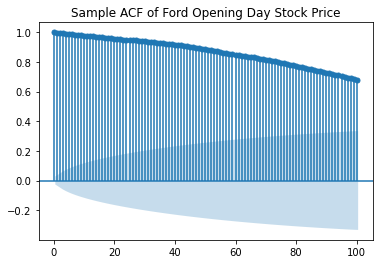

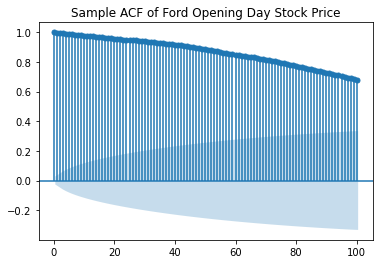

In [20]:
# CITATION: https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711
plot_acf(data['Open'], lags=100, title='Sample ACF of Ford Opening Day Stock Price')

# NOTE: for some reason this produces 2 of the same plot, it could not be removed.

## Set Up Code

The following few cells contain code that will be use to create, and evaluate the models

In [21]:
# This defines the numpy of days in the past we will use to predict the current price
LAG = 40

In [22]:
# Plots the results of a mode.
def plot(yHat, y, title):
    plt.plot(y)
    plt.plot(yHat)
    plt.legend(['Real', 'Predicted'])
    plt.title(title)
    plt.show()
    

In [23]:
# Calculates the MSE
def mse(x, y):
    preds = model.predict(x)
    preds = scaler.inverse_transform(preds)
    unscaled_yTest = scaler.inverse_transform(np.reshape(y, (-1, 1)))
    return np.mean(np.square(preds-unscaled_yTest)), preds, unscaled_yTest

In [24]:
# This function accepts the raw data and transforms it into the form required for the LSTM NN.  
# - It removes unneccessary columns
# - scales the data between 0 and 1
# - transforms into numpy arrays
def transform(df, n=40):
    df = pd.DataFrame(df['Open'])  # Removing all the other columns as we are only predicting if we should buy based on the opening stock price

    
    # Normalizing to 0-1 range
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df)
    df = pd.DataFrame(scaler.transform(df), columns=df.columns, index=pd.to_datetime(df.index))


    # Creating 40 columns that give the past 40 day opening stock price
    for i in range(1, n + 1):
        df[f'Open-{i}'] = df['Open'].shift(i)

    # Subsetting for the neccessary columns
    df = df.iloc[40:, 0:]

    # Splitting into training and testing data (test size is about last 2 years)
    dt = pd.to_datetime(date(2020, 11, 17) - timedelta(days=730))
    train = df[df.index < dt]
    test = df[df.index >= dt]     

    # Splitting into appropriat x and y values
    xTrain = train.iloc[:, 1:]
    yTrain = train.iloc[:, 0]
    xTest = test.iloc[:, 1:]
    yTest = test.iloc[:, 0]

    # Converting to numpy arrays to feed into model
    xTrain = xTrain.to_numpy()
    yTrain = yTrain.to_numpy()
    xTest = xTest.to_numpy()
    yTest = yTest.to_numpy()

    # Reshaping to get correct form
    xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
    xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

    return xTrain, yTrain, xTest, yTest, scaler

In [8]:
def saveModel(model, name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # serialize model to JSON
    model_json = model.to_json()
    with open(f"{location}/{name}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{location}/{name}.h5")
    print("Saved model to disk")

def loadModel(name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # load json and create model
    json_file = open(f"{location}/{name}.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(f"{location}/{name}.h5")
    return model
    print("Loaded model from disk")



In [9]:
xTrain, yTrain, xTest, yTest, scaler = transform(data, LAG)

In [10]:
# Setting the batch size for the model.
BATCH_SIZE = int(xTrain.shape[0]/3)
# BATCH_SIZE = xTrain.shape[0]

In [11]:
def modelTraining(epoch, batchSize, neuronsLSTM1=50,neuronsLSTM2=128, neuronsDense=64, learningRate=0.0005):
    with tf.device("gpu:0"):
        model = Sequential()
        model.add(LSTM(neuronsLSTM1,input_shape=(xTrain.shape[1],xTrain.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(neuronsDense))
        model.add(Activation('sigmoid'))
        model.add(Dense(1))
        model.add(Activation('linear'))
        opt = tf.keras.optimizers.Adam(lr=learningRate)
        model.compile(optimizer=opt, loss='mse')
        model.fit(xTrain,yTrain, batch_size=batchSize, epochs=epoch, shuffle=True)
    return model

## Model Training

### Model Tuning 1: Batch Size

Using our model as defined above, we explore the affect of batch sizes using of 10, 32(Default), 100, 500, 1000, 1500, and 2000.  All with a standard of 1000 epochs.

In [12]:
# batches = pd.DataFrame(columns=['batchSize', 'mseTrain','mseTest'])
# for batchSize in [10,32 ,100, 500, 1000, 1500, 2000, 2500, 3000]:
#     model = modelTraining(1000, batchSize)
#     mseTrain, yHat, y = mse(xTrain,yTrain)
#     mseTest, yHat, y = mse(xTest,yTest)
#     batches = batches.append({'batchSize':batchSize, 'mseTrain': mseTrain, 'mseTest':mseTest}, ignore_index=True)

#     saveModel(model, f"fordBatchTraining{batchSize}", location='Data')

# batches.to_csv('Data/fordBatchTraining.csv')

results = pd.read_csv('Data/fordBatchTraining.csv')
results
    


batchSize  mseTrain   mseTest
0         10  0.053750  0.007168
1         32  0.069077  0.006059
2        100  0.096221  0.005149
3        500  0.135626  0.013121
4       1000  0.181391  0.006829
5       1500  0.246180  0.010500
6       2000  0.363314  0.035387
7       2500  0.421914  0.046237
8       3000  0.215748  0.005812

Looking at the above results of changing the batch size, we see mixed results with the potential that our predictions get worse as we increase the batch size.  We can see this as the MSof the training data does appear to increase as our batch size increases.  To verify the results, lets plot the results of the models with a batch size 10, 2000 and 3000 respectively.

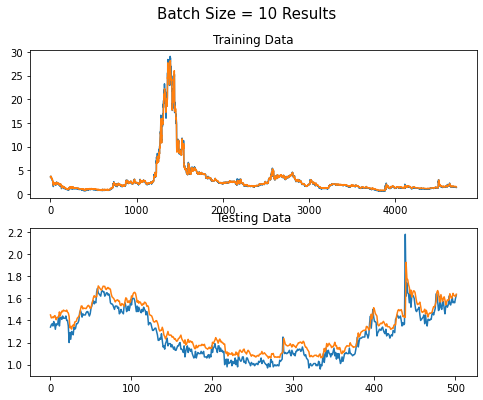

In [14]:
model = loadModel(name='fordBatchTraining10')

# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Batch Size = 10 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")

meanSquared, yHat, y = mse(xTest,yTest)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")

plt.show()

0.36331427200357713
0.035387185616672805


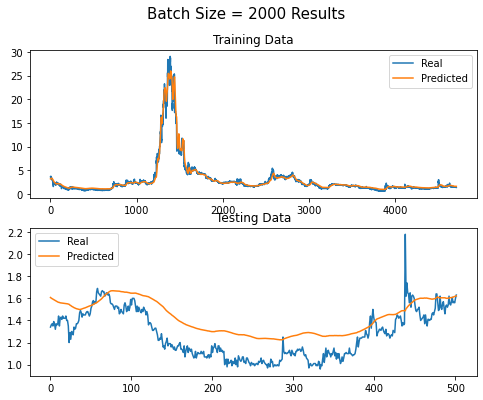

In [15]:
model = loadModel(name='fordBatchTraining2000')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Batch Size = 2000 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

0.21574778866367464
0.00581204641572969


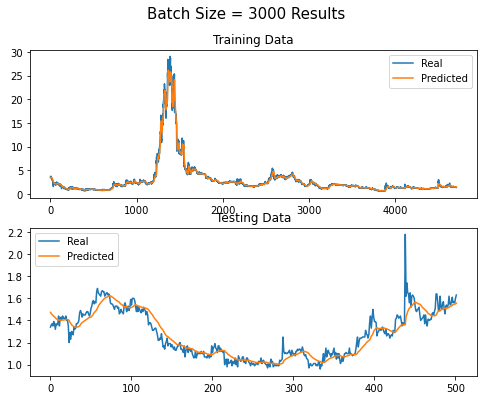

In [16]:
model = loadModel(name='fordBatchTraining3000')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Batch Size = 3000 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

We can clearly see that as the batch sizes increases, the fit of the model on the testing data worsens significantly.  This is particularly interesting for the batch size = 3000 where the testing MSE is actually quite good, but the training MSE is poor.  Ultimatly, we conclude that a smaller batch size is best.

### Model Tuning 2: Epochs

To achieve a better fit, we will now try to tune the number of epochs the model must iterate through to train the model.  To do so we will try epochs of 50, 100, 500, 1000, 2000, and 3000.  Using our results from tuning the batch size, we will use a constant batch size of 10.

In [26]:
# batches = pd.DataFrame(columns=['epochs', 'mseTrain','mseTest'])
# for epoch in [50,100, 500, 1000, 2000, 3000]:
#     model = modelTraining(epoch, 10)
#     mseTrain, yHat, y = mse(xTrain,yTrain)
#     mseTest, yHat, y = mse(xTest,yTest)
#     batches = batches.append({'epochs':epoch, 'mseTrain': mseTrain, 'mseTest':mseTest}, ignore_index=True)

#     saveModel(model, f"fordEpochTraining{epoch}", location='Data')

# batches.to_csv('Data/fordEpochTraining.csv')

results = pd.read_csv('Data/fordEpochTraining.csv')
results
    

epochs  mseTrain   mseTest
0      50  0.914686  0.362143
1     100  0.267374  0.044504
2     500  0.128154  0.052861
3    1000  0.054909  0.003233
4    2000  0.026806  0.004708
5    3000  0.139692  0.008902

Looking at the results of increasing the number of epochs in our model, we can clearly see that increasing it reduces the MSE of both the training and test data.  However, we can see that after 1000 epochs the decreases dimish and in fact increases for the epoch=3000.  To investigate further, lets plots the results.

0.9146856378208328
0.3621430746025449


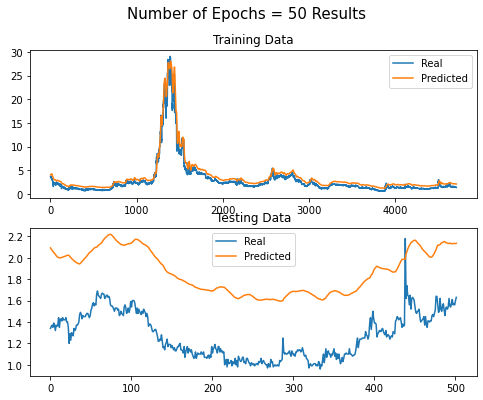

In [28]:
model = loadModel(name='fordEpochTraining50')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Number of Epochs = 50 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

0.026805853110043028
0.004708414955350479


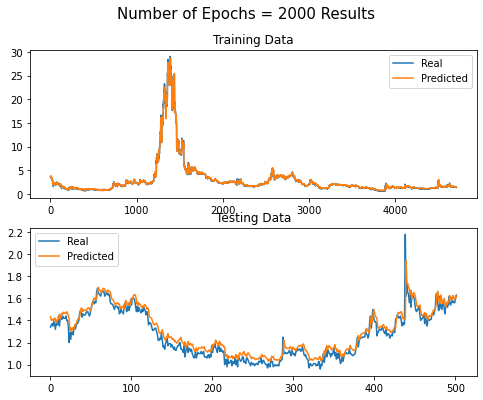

In [33]:
model = loadModel(name='fordEpochTraining2000')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Number of Epochs = 2000 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

0.13969178935393936
0.008901925384064287


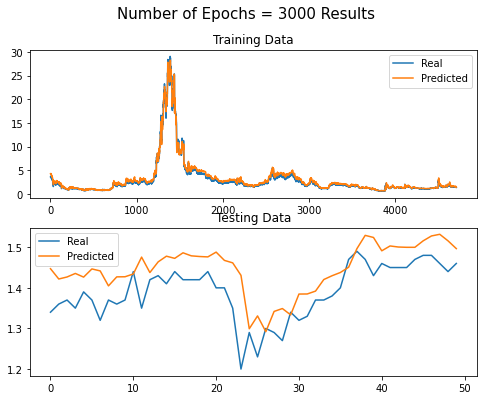

In [17]:
model = loadModel(name='fordEpochTraining3000')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Number of Epochs = 3000 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

We can clearly see that for epochs=50, the model is far away from the test data.  It is likely that it is simply undertrained.  For epochs=2000 and 3000, we see our predictions get much closer to the truth.  However for epochs=3000, our predictions appear to start deviating from the truth, perhaps it is now overtrained.  Thus, we will use epochs=2000 going forward.

### Model Tuning 3: Learning Rate


In [36]:
def modelTraining(epoch, batchSize, neuronsLSTM1=50, neuronsDense=64, learningRate=0.0005):
    with tf.device("gpu:0"):
        model = Sequential()
        model.add(LSTM(neuronsLSTM1,input_shape=(xTrain.shape[1],xTrain.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(neuronsDense))
        model.add(Activation('sigmoid'))
        model.add(Dense(1))
        model.add(Activation('linear'))
        opt = tf.keras.optimizers.Adam(lr=learningRate)
        model.compile(optimizer=opt, loss='mse')
        model.fit(xTrain,yTrain, batch_size=batchSize, epochs=epoch, shuffle=True)
    return model

cvModels = pd.DataFrame(columns=['epochs', 'batch','neuronsLSTM','neuronsDense','learningRate','mseTrain','mseTest'])
for epoch in [2000]:
    for batch in [100]:
#         for neuronsLSTM in [20, 40, 80, 100]:
        for neuronsLSTM in [80, 100]:
            for neuronsDense in [20, 40, 80, 100]:
                for learningRate in [0.05, 0.005, 0.0005,0.00005,0.000005]:
                    model = modelTraining(epoch, batch, neuronsLSTM, neuronsDense, learningRate)
                    mseTrain, yHat, y = mse(xTrain,yTrain)
                    mseTest, yHat, y = mse(xTest,yTest)
                    cvModels = cvModels.append({'epochs':epoch, 
                                                'batch':batch,
                                                'neuronsLSTM':neuronsLSTM,
                                                'neuronsDense':neuronsDense,
                                                'learningRate':learningRate,
                                                'mseTrain':mseTrain,
                                                'mseTest':mseTest}, ignore_index=True)
                    saveModel(model, f"fordCVTraining_{epoch}_{batch}_{neuronsLSTM}_{neuronsDense}_{learningRate}", location='Data/CVTraining')
                    cvModels.to_csv('cvModelsResult.csv')

                    
cvModels.to_csv('cvModelsResult2.csv')



Epoch 1/2000
48/48 [==============================] - 2s 6ms/step - loss: 0.5052
Epoch 2/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0151
Epoch 3/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0125
Epoch 4/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 5/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0128
Epoch 6/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0121
Epoch 7/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0099
Epoch 8/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 9/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 10/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 11/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 12/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 13/2000
48/48 [====

48/48 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 102/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 103/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 104/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0026
Epoch 105/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 106/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 107/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 108/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 109/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 110/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 111/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 112/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 113/2000
48/4

48/48 [==============================] - 0s 7ms/step - loss: 6.7995e-04
Epoch 294/2000
48/48 [==============================] - 0s 7ms/step - loss: 8.7874e-04
Epoch 295/2000
48/48 [==============================] - 0s 7ms/step - loss: 7.7825e-04
Epoch 296/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2270e-04
Epoch 297/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.5917e-04
Epoch 298/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.0912e-04
Epoch 299/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.4707e-04
Epoch 300/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.8418e-04
Epoch 301/2000
48/48 [==============================] - 0s 7ms/step - loss: 7.6575e-04
Epoch 302/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 303/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7149e-04
Epoch 304/2000
48/48 [==============================] - 0s 6ms

48/48 [==============================] - 0s 6ms/step - loss: 5.5473e-04
Epoch 482/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.0158e-04
Epoch 483/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.5860e-04
Epoch 484/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.9918e-04
Epoch 485/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6376e-04
Epoch 486/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2889e-04
Epoch 487/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 488/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3655e-04
Epoch 489/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2369e-04
Epoch 490/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9737e-04
Epoch 491/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6045e-04
Epoch 492/2000
48/48 [==============================] - 0s 6ms

48/48 [==============================] - 0s 6ms/step - loss: 3.8617e-04
Epoch 670/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7387e-04
Epoch 671/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0510e-04
Epoch 672/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4979e-04
Epoch 673/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5334e-04
Epoch 674/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0021e-04
Epoch 675/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5641e-04
Epoch 676/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7974e-04
Epoch 677/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.3926e-04
Epoch 678/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7797e-04
Epoch 679/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7661e-04
Epoch 680/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.9424e-04
Epoch 764/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0657e-04
Epoch 765/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3752e-04
Epoch 766/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1109e-04
Epoch 767/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7044e-04
Epoch 768/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5353e-04
Epoch 769/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4770e-04
Epoch 770/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6542e-04
Epoch 771/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6433e-04
Epoch 772/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8066e-04
Epoch 773/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2606e-04
Epoch 774/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 7ms/step - loss: 3.5038e-04
Epoch 951/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6273e-04
Epoch 952/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0925e-04
Epoch 953/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8125e-04
Epoch 954/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3722e-04
Epoch 955/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0654e-04
Epoch 956/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3786e-04
Epoch 957/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.0149e-04
Epoch 958/2000
48/48 [==============================] - 0s 8ms/step - loss: 3.4221e-04
Epoch 959/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 960/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3393e-04
Epoch 961/2000
48/48 [==============================] - 0s 6ms

48/48 [==============================] - 0s 6ms/step - loss: 5.9462e-04
Epoch 1136/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8841e-04
Epoch 1137/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6528e-04
Epoch 1138/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7057e-04A: 0s - loss: 7.7129
Epoch 1139/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3469e-04
Epoch 1140/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5523e-04
Epoch 1141/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9968e-04
Epoch 1142/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9394e-04
Epoch 1143/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6649e-04
Epoch 1144/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7328e-04
Epoch 1145/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4714e-04
Epoch 1146/2000
48/48 [=====

48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 1229/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5161e-04
Epoch 1230/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5452e-04
Epoch 1231/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9776e-04
Epoch 1232/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1414e-04
Epoch 1233/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6705e-04
Epoch 1234/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7660e-04
Epoch 1235/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2723e-04
Epoch 1236/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1113e-04
Epoch 1237/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2209e-04
Epoch 1238/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1039e-04
Epoch 1239/2000
48/48 [=============================

48/48 [==============================] - 0s 6ms/step - loss: 2.8778e-04
Epoch 1414/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9796e-04
Epoch 1415/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3751e-04
Epoch 1416/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6655e-04
Epoch 1417/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3262e-04
Epoch 1418/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4205e-04
Epoch 1419/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0739e-04
Epoch 1420/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3809e-04
Epoch 1421/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8083e-04
Epoch 1422/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5806e-04
Epoch 1423/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7549e-04
Epoch 1424/2000
48/48 [=========================

48/48 [==============================] - 0s 7ms/step - loss: 2.3197e-04
Epoch 1599/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.3248e-04
Epoch 1600/2000
48/48 [==============================] - 0s 7ms/step - loss: 7.5842e-04
Epoch 1601/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.9416e-04
Epoch 1602/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9391e-04
Epoch 1603/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.5284e-04
Epoch 1604/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.4702e-04
Epoch 1605/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.9230e-04
Epoch 1606/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.5269e-04
Epoch 1607/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0198e-04
Epoch 1608/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8442e-04
Epoch 1609/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.1301e-04
Epoch 1785/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.5565e-04
Epoch 1786/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.6634e-04
Epoch 1787/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2363e-04
Epoch 1788/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.6426e-04
Epoch 1789/2000
48/48 [==============================] - 0s 7ms/step - loss: 6.2510e-04
Epoch 1790/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 1791/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5537e-04
Epoch 1792/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9229e-04
Epoch 1793/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1330e-04
Epoch 1794/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2874e-04
Epoch 1795/2000
48/48 [=============================

48/48 [==============================] - 0s 6ms/step - loss: 3.1886e-04
Epoch 1878/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7352e-04
Epoch 1879/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7347e-04
Epoch 1880/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3182e-04
Epoch 1881/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2754e-04
Epoch 1882/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5258e-04
Epoch 1883/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8860e-04
Epoch 1884/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2162e-04
Epoch 1885/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7551e-04
Epoch 1886/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5269e-04
Epoch 1887/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0915e-04
Epoch 1888/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.5614e-04
Epoch 66/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5102e-04
Epoch 67/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0659e-04
Epoch 68/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2853e-04
Epoch 69/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1862e-04
Epoch 70/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7907e-04
Epoch 71/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2800e-04
Epoch 72/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9411e-04
Epoch 73/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6068e-04
Epoch 74/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0561e-04
Epoch 75/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8883e-04
Epoch 76/2000
48/48 [==============================] - 0s 6ms/step -

48/48 [==============================] - 0s 6ms/step - loss: 2.0345e-04
Epoch 254/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8499e-04
Epoch 255/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6593e-04
Epoch 256/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8853e-04
Epoch 257/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3320e-04
Epoch 258/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.3180e-04
Epoch 259/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6470e-04
Epoch 260/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8289e-04
Epoch 261/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8562e-04
Epoch 262/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6096e-04
Epoch 263/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8086e-04
Epoch 264/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.3303e-04
Epoch 442/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2739e-04
Epoch 443/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6591e-04
Epoch 444/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3995e-04
Epoch 445/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9320e-04
Epoch 446/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3783e-04
Epoch 447/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1429e-04
Epoch 448/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5069e-04
Epoch 449/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2498e-04
Epoch 450/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2821e-04
Epoch 451/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3442e-04
Epoch 452/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.4124e-04
Epoch 630/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3675e-04
Epoch 631/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4441e-04
Epoch 632/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2181e-04
Epoch 633/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3770e-04
Epoch 634/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4565e-04
Epoch 635/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3895e-04
Epoch 636/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2921e-04
Epoch 637/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1519e-04
Epoch 638/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3667e-04
Epoch 639/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5162e-04
Epoch 640/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 7ms/step - loss: 1.3219e-04
Epoch 817/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0255e-04
Epoch 818/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3636e-04
Epoch 819/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1461e-04
Epoch 820/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0559e-04
Epoch 821/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0718e-04
Epoch 822/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1853e-04
Epoch 823/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3772e-04
Epoch 824/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6926e-05
Epoch 825/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.8166e-05
Epoch 826/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2124e-04
Epoch 827/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.5067e-04
Epoch 911/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6280e-04
Epoch 912/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6649e-04
Epoch 913/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6439e-04
Epoch 914/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8516e-04
Epoch 915/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8158e-04
Epoch 916/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5908e-04
Epoch 917/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0142e-04
Epoch 918/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2435e-04
Epoch 919/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6078e-04
Epoch 920/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.7821e-04
Epoch 921/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.9925e-04
Epoch 1098/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4081e-04
Epoch 1099/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7817e-04
Epoch 1100/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4003e-04
Epoch 1101/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3805e-04
Epoch 1102/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3173e-04
Epoch 1103/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1705e-04
Epoch 1104/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3347e-04
Epoch 1105/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4392e-04
Epoch 1106/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3705e-04
Epoch 1107/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2334e-04
Epoch 1108/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 8.1292e-05
Epoch 1283/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.2382e-05
Epoch 1284/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7045e-05
Epoch 1285/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2680e-04
Epoch 1286/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5525e-05
Epoch 1287/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0541e-04
Epoch 1288/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0683e-05
Epoch 1289/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1704e-04
Epoch 1290/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3105e-05
Epoch 1291/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6752e-05
Epoch 1292/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7281e-05
Epoch 1293/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 7.4130e-05
Epoch 1467/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.0891e-05
Epoch 1468/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1186e-05
Epoch 1469/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4724e-05
Epoch 1470/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.9787e-05
Epoch 1471/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2390e-05
Epoch 1472/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4305e-05
Epoch 1473/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.4772e-05
Epoch 1474/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.3486e-05
Epoch 1475/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2982e-05
Epoch 1476/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7436e-05
Epoch 1477/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 8.7861e-05
Epoch 1560/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.1856e-05
Epoch 1561/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.9783e-05
Epoch 1562/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.4040e-05
Epoch 1563/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4730e-05
Epoch 1564/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.3593e-05
Epoch 1565/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2737e-04
Epoch 1566/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.1151e-05
Epoch 1567/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6058e-05
Epoch 1568/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4212e-05
Epoch 1569/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4831e-05
Epoch 1570/2000
48/48 [=========================

48/48 [==============================] - 0s 7ms/step - loss: 5.1135e-05
Epoch 1653/2000
48/48 [==============================] - 0s 7ms/step - loss: 6.0146e-05
Epoch 1654/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8341e-05
Epoch 1655/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8367e-05
Epoch 1656/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7035e-05
Epoch 1657/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8030e-05
Epoch 1658/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0426e-05
Epoch 1659/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2061e-05
Epoch 1660/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.9388e-05
Epoch 1661/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4980e-05
Epoch 1662/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1993e-05
Epoch 1663/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 6.1338e-05
Epoch 1839/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8374e-05
Epoch 1840/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6612e-05
Epoch 1841/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9663e-05
Epoch 1842/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7273e-05
Epoch 1843/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0639e-05
Epoch 1844/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.7530e-05
Epoch 1845/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.8689e-05
Epoch 1846/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7787e-05
Epoch 1847/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8710e-05
Epoch 1848/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5767e-05
Epoch 1849/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.6273e-04
Epoch 1932/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3486e-04
Epoch 1933/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.3076e-04
Epoch 1934/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2479e-04
Epoch 1935/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1988e-04
Epoch 1936/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.4278e-04
Epoch 1937/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.5008e-04
Epoch 1938/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.3006e-04
Epoch 1939/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1271e-04
Epoch 1940/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5176e-04
Epoch 1941/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2831e-04
Epoch 1942/2000
48/48 [=========================

48/48 [==============================] - 0s 8ms/step - loss: 4.7807e-04
Epoch 121/2000
48/48 [==============================] - 0s 8ms/step - loss: 4.2765e-04
Epoch 122/2000
48/48 [==============================] - 0s 8ms/step - loss: 5.7441e-04
Epoch 123/2000
48/48 [==============================] - 0s 7ms/step - loss: 7.3335e-04
Epoch 124/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.8368e-04
Epoch 125/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6064e-04
Epoch 126/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1617e-04
Epoch 127/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0079e-04
Epoch 128/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2264e-04
Epoch 129/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7074e-04
Epoch 130/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4394e-04
Epoch 131/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.2760e-04
Epoch 308/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2714e-04
Epoch 309/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2637e-04
Epoch 310/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7748e-04
Epoch 311/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3527e-04
Epoch 312/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3964e-04
Epoch 313/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3169e-04
Epoch 314/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6956e-04
Epoch 315/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6399e-04
Epoch 316/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.3649e-04
Epoch 317/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2128e-04
Epoch 318/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.8693e-04
Epoch 402/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0691e-04
Epoch 403/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4857e-04
Epoch 404/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1075e-04
Epoch 405/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9420e-04
Epoch 406/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3046e-04
Epoch 407/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0111e-04
Epoch 408/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8839e-04
Epoch 409/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6246e-04
Epoch 410/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2755e-04
Epoch 411/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3593e-04
Epoch 412/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.4599e-04
Epoch 496/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3295e-04
Epoch 497/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8423e-04
Epoch 498/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3719e-04
Epoch 499/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0977e-04
Epoch 500/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9157e-04
Epoch 501/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3090e-04
Epoch 502/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0024e-04
Epoch 503/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7548e-04
Epoch 504/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.3522e-04
Epoch 505/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.8028e-04
Epoch 506/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.1570e-04
Epoch 590/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8426e-04
Epoch 591/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7296e-04
Epoch 592/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5956e-04
Epoch 593/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6816e-04
Epoch 594/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8862e-04
Epoch 595/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0830e-04
Epoch 596/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8127e-04
Epoch 597/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8333e-04
Epoch 598/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5365e-04
Epoch 599/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5915e-04
Epoch 600/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.4022e-04
Epoch 777/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4072e-04
Epoch 778/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7060e-04
Epoch 779/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4443e-04
Epoch 780/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0078e-04
Epoch 781/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6117e-04
Epoch 782/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5934e-04
Epoch 783/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5573e-04
Epoch 784/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6048e-04
Epoch 785/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6696e-04
Epoch 786/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2356e-04
Epoch 787/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.4235e-04
Epoch 964/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9661e-04
Epoch 965/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3256e-04
Epoch 966/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3983e-04
Epoch 967/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3293e-04
Epoch 968/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3976e-04
Epoch 969/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8747e-04
Epoch 970/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3414e-04
Epoch 971/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5251e-04
Epoch 972/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5037e-04
Epoch 973/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7856e-04
Epoch 974/2000
48/48 [==============================] - 0s

Epoch 1056/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3447e-04
Epoch 1057/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2940e-04
Epoch 1058/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4197e-04
Epoch 1059/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3691e-04
Epoch 1060/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3882e-04
Epoch 1061/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0208e-04
Epoch 1062/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5821e-04
Epoch 1063/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5945e-04
Epoch 1064/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6843e-04
Epoch 1065/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.4498e-04
Epoch 1066/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2757e-04
Epoch 1067/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 1.2000e-04
Epoch 1241/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2326e-04
Epoch 1242/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1013e-04
Epoch 1243/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1988e-04
Epoch 1244/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2553e-04
Epoch 1245/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1655e-04
Epoch 1246/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1891e-04
Epoch 1247/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1836e-04
Epoch 1248/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1386e-04
Epoch 1249/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1692e-04
Epoch 1250/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2875e-04
Epoch 1251/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.2120e-04
Epoch 1425/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0778e-04
Epoch 1426/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3760e-04
Epoch 1427/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2753e-04
Epoch 1428/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3225e-04
Epoch 1429/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1230e-04
Epoch 1430/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1598e-04
Epoch 1431/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2033e-04
Epoch 1432/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0851e-04
Epoch 1433/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0657e-04
Epoch 1434/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3238e-04
Epoch 1435/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.0998e-04
Epoch 1518/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1244e-04
Epoch 1519/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2082e-04
Epoch 1520/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1669e-04
Epoch 1521/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.0364e-04
Epoch 1522/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1269e-04
Epoch 1523/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3342e-05
Epoch 1524/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0756e-04
Epoch 1525/2000
48/48 [==============================] - 0s 7ms/step - loss: 9.8543e-05A: 0s - loss: 1.097
Epoch 1526/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0460e-04
Epoch 1527/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1962e-04
Epoch 1528/2000
48/48 [======

48/48 [==============================] - 0s 6ms/step - loss: 1.0367e-04
Epoch 1611/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1655e-04
Epoch 1612/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7465e-05
Epoch 1613/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0780e-04
Epoch 1614/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1035e-04
Epoch 1615/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1744e-04
Epoch 1616/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1902e-04
Epoch 1617/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8158e-05
Epoch 1618/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0160e-04
Epoch 1619/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1750e-04
Epoch 1620/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0746e-04
Epoch 1621/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.0341e-04
Epoch 1704/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0367e-04
Epoch 1705/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0041e-04
Epoch 1706/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0210e-04
Epoch 1707/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0195e-04
Epoch 1708/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7153e-05
Epoch 1709/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1213e-04
Epoch 1710/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0586e-04
Epoch 1711/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6869e-05
Epoch 1712/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9105e-05
Epoch 1713/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1080e-05
Epoch 1714/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.2764e-04
Epoch 1889/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7183e-05
Epoch 1890/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3947e-05
Epoch 1891/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1959e-04
Epoch 1892/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.8987e-05
Epoch 1893/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9222e-05
Epoch 1894/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0025e-04
Epoch 1895/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6114e-05
Epoch 1896/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0437e-04
Epoch 1897/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3569e-05
Epoch 1898/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7601e-05
Epoch 1899/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 6.4102e-04
Epoch 77/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4701e-04
Epoch 78/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6017e-04
Epoch 79/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3523e-04
Epoch 80/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1824e-04
Epoch 81/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.0768e-04
Epoch 82/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.8744e-04
Epoch 83/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.1415e-04
Epoch 84/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5701e-04
Epoch 85/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4680e-04
Epoch 86/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.0985e-04
Epoch 87/2000
48/48 [==============================] - 0s 6ms/step -

48/48 [==============================] - 0s 6ms/step - loss: 4.5759e-04
Epoch 265/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7071e-04
Epoch 266/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0038e-04
Epoch 267/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3564e-04
Epoch 268/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8523e-04
Epoch 269/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5584e-04
Epoch 270/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2073e-04
Epoch 271/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3930e-04
Epoch 272/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0124e-04
Epoch 273/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7609e-04
Epoch 274/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1433e-04
Epoch 275/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.6191e-04
Epoch 359/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3661e-04
Epoch 360/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3594e-04
Epoch 361/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9021e-04
Epoch 362/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.8031e-04
Epoch 363/2000
48/48 [==============================] - 0s 7ms/step - loss: 6.3102e-04
Epoch 364/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2413e-04
Epoch 365/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3756e-04
Epoch 366/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3999e-04
Epoch 367/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.2945e-04
Epoch 368/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4713e-04
Epoch 369/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.7751e-04
Epoch 545/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0357e-04
Epoch 546/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1746e-04
Epoch 547/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1862e-04
Epoch 548/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7329e-04
Epoch 549/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9030e-04
Epoch 550/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2037e-04
Epoch 551/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0508e-04
Epoch 552/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0230e-04
Epoch 553/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9691e-04
Epoch 554/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7945e-04
Epoch 555/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.1832e-04
Epoch 732/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6495e-04
Epoch 733/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.1821e-04
Epoch 734/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.5704e-04
Epoch 735/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5672e-04
Epoch 736/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5166e-04
Epoch 737/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0107e-04
Epoch 738/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3613e-04
Epoch 739/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7105e-04
Epoch 740/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6977e-04
Epoch 741/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6054e-04
Epoch 742/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.2352e-04
Epoch 826/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7016e-04
Epoch 827/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4160e-04
Epoch 828/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2253e-04
Epoch 829/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1122e-04
Epoch 830/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1242e-04
Epoch 831/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4440e-04
Epoch 832/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5115e-04
Epoch 833/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4909e-04
Epoch 834/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1184e-04
Epoch 835/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0899e-04
Epoch 836/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.7127e-04
Epoch 920/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7737e-04
Epoch 921/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0457e-04
Epoch 922/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6747e-04
Epoch 923/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9336e-04
Epoch 924/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9199e-04
Epoch 925/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6426e-04
Epoch 926/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1965e-04
Epoch 927/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1052e-04
Epoch 928/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5040e-04
Epoch 929/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2633e-04
Epoch 930/2000
48/48 [==============================] - 0s

Epoch 1013/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.0602e-04
Epoch 1014/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.7329e-04
Epoch 1015/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7629e-04
Epoch 1016/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1046e-04
Epoch 1017/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8449e-04
Epoch 1018/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9246e-04
Epoch 1019/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4739e-04
Epoch 1020/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2721e-04A: 0s - loss: 3.760
Epoch 1021/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6400e-04
Epoch 1022/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9136e-04
Epoch 1023/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5733e-04
Epoch 1024/20

48/48 [==============================] - 0s 6ms/step - loss: 2.9733e-04
Epoch 1198/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8105e-04
Epoch 1199/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.7931e-04
Epoch 1200/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.9856e-04
Epoch 1201/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8424e-04
Epoch 1202/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.4343e-04
Epoch 1203/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.8240e-04
Epoch 1204/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.3821e-04
Epoch 1205/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.0554e-04
Epoch 1206/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.7508e-04
Epoch 1207/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5615e-04
Epoch 1208/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.4670e-04
Epoch 1384/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6512e-04
Epoch 1385/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8729e-04
Epoch 1386/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7019e-04
Epoch 1387/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9482e-04
Epoch 1388/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9786e-04
Epoch 1389/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0789e-04
Epoch 1390/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7145e-04
Epoch 1391/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.8370e-04
Epoch 1392/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.6510e-04
Epoch 1393/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7205e-04
Epoch 1394/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.8983e-04
Epoch 1477/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5715e-04
Epoch 1478/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7279e-04
Epoch 1479/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4499e-04
Epoch 1480/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.9529e-04
Epoch 1481/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.8524e-04
Epoch 1482/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.7988e-04
Epoch 1483/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9027e-04
Epoch 1484/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9989e-04
Epoch 1485/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7876e-04
Epoch 1486/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.7532e-04
Epoch 1487/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.8119e-04
Epoch 1570/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7247e-04
Epoch 1571/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4719e-04
Epoch 1572/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0178e-04
Epoch 1573/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2598e-04
Epoch 1574/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0999e-04
Epoch 1575/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0244e-04
Epoch 1576/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8334e-04
Epoch 1577/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3047e-04
Epoch 1578/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8056e-04
Epoch 1579/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9431e-04
Epoch 1580/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.4029e-04
Epoch 1755/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2048e-04
Epoch 1756/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0698e-04
Epoch 1757/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7161e-04
Epoch 1758/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1719e-04
Epoch 1759/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5593e-04
Epoch 1760/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0351e-04
Epoch 1761/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8944e-04
Epoch 1762/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5277e-04
Epoch 1763/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6114e-04
Epoch 1764/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1172e-04
Epoch 1765/2000
48/48 [=========================

48/48 [==============================] - 0s 7ms/step - loss: 2.9386e-04
Epoch 1941/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7403e-04
Epoch 1942/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3162e-04
Epoch 1943/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3291e-04
Epoch 1944/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.0802e-04
Epoch 1945/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.7476e-04
Epoch 1946/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.9932e-04
Epoch 1947/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2888e-04
Epoch 1948/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5259e-04
Epoch 1949/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2939e-04
Epoch 1950/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8454e-04
Epoch 1951/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 135/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 136/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 137/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 138/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 139/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 140/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 141/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 142/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 143/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 144/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 145/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 146/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 331/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 332/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 333/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 334/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 335/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 336/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 337/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 338/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 339/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 340/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 341/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 342/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 527/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 528/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 529/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 530/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 531/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 532/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 533/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7089e-04
Epoch 534/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 535/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 536/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 537/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 538/2000


48/48 [==============================] - 0s 6ms/step - loss: 8.6094e-04
Epoch 717/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8585e-04
Epoch 718/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8536e-04
Epoch 719/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8040e-04A: 0s - loss: 7.5611e
Epoch 720/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3783e-04
Epoch 721/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.2191e-04
Epoch 722/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5778e-04
Epoch 723/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.7969e-04
Epoch 724/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.0495e-04
Epoch 725/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.9801e-04
Epoch 726/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.2999e-04A: 0s - loss: 7.949
Epoch 727/2000
48/

48/48 [==============================] - 0s 6ms/step - loss: 6.2511e-04
Epoch 904/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2676e-04
Epoch 905/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.1085e-04
Epoch 906/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6198e-04
Epoch 907/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2290e-04
Epoch 908/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.1986e-04
Epoch 909/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.9460e-04
Epoch 910/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7889e-04
Epoch 911/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.8598e-04
Epoch 912/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.8298e-04
Epoch 913/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2034e-04
Epoch 914/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 5.8598e-04
Epoch 998/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.1697e-04
Epoch 999/2000
48/48 [==============================] - 0s 7ms/step - loss: 6.3864e-04
Epoch 1000/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7553e-04
Epoch 1001/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6490e-04
Epoch 1002/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6845e-04
Epoch 1003/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.9452e-04
Epoch 1004/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0626e-04
Epoch 1005/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5702e-04
Epoch 1006/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.9921e-04
Epoch 1007/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8182e-04
Epoch 1008/2000
48/48 [===========================

48/48 [==============================] - 0s 6ms/step - loss: 5.1987e-04
Epoch 1183/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0074e-04
Epoch 1184/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4078e-04
Epoch 1185/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2322e-04
Epoch 1186/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2421e-04
Epoch 1187/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0712e-04
Epoch 1188/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8248e-04
Epoch 1189/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3327e-04
Epoch 1190/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2485e-04
Epoch 1191/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8987e-04
Epoch 1192/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1000e-04
Epoch 1193/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 5.7990e-04
Epoch 1276/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8057e-04
Epoch 1277/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2704e-04
Epoch 1278/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8823e-04
Epoch 1279/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4193e-04
Epoch 1280/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8888e-04
Epoch 1281/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3202e-04
Epoch 1282/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0818e-04
Epoch 1283/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5450e-04
Epoch 1284/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2818e-04
Epoch 1285/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1743e-04
Epoch 1286/2000
48/48 [=========================

48/48 [==============================] - 0s 7ms/step - loss: 5.1002e-04
Epoch 1369/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.8142e-04
Epoch 1370/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.1706e-04
Epoch 1371/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.5412e-04
Epoch 1372/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.7225e-04
Epoch 1373/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.6235e-04
Epoch 1374/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.9853e-04
Epoch 1375/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.3401e-04
Epoch 1376/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5398e-04
Epoch 1377/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.9092e-04
Epoch 1378/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6945e-04
Epoch 1379/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.2152e-04
Epoch 1554/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5855e-04
Epoch 1555/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7549e-04
Epoch 1556/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9177e-04
Epoch 1557/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7496e-04
Epoch 1558/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7757e-04
Epoch 1559/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7458e-04
Epoch 1560/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8379e-04
Epoch 1561/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8860e-04
Epoch 1562/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8804e-04
Epoch 1563/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9440e-04
Epoch 1564/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.8627e-04
Epoch 1739/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7196e-04
Epoch 1740/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6479e-04
Epoch 1741/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8864e-04
Epoch 1742/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0556e-04
Epoch 1743/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0252e-04
Epoch 1744/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7494e-04
Epoch 1745/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2910e-04
Epoch 1746/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2822e-04
Epoch 1747/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0935e-04
Epoch 1748/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8408e-04
Epoch 1749/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.4587e-04
Epoch 1832/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1238e-04
Epoch 1833/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0210e-04
Epoch 1834/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2217e-04
Epoch 1835/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2932e-04
Epoch 1836/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7983e-04
Epoch 1837/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6636e-04
Epoch 1838/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1172e-04
Epoch 1839/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2158e-04
Epoch 1840/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1287e-04
Epoch 1841/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2014e-04
Epoch 1842/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 19/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0176
Epoch 20/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 21/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0210
Epoch 22/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 23/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0116
Epoch 24/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 25/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 26/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 27/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 28/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 29/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 30/2000
48/48 [=========

Epoch 117/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.8117e-04
Epoch 118/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.2605e-04
Epoch 119/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 120/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.9944e-04
Epoch 121/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7993e-04
Epoch 122/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.4539e-04
Epoch 123/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 124/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.4998e-04
Epoch 125/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.4697e-04
Epoch 126/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5857e-04
Epoch 127/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7562e-04
Epoch 128/2000
48/48 [=============================

48/48 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 215/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 216/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 217/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 218/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 219/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 220/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0195
Epoch 221/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0222
Epoch 222/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 223/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0181
Epoch 224/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 225/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0194
Epoch 226/2000
48/4

48/48 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 411/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 412/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 413/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 414/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 415/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 416/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 417/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 418/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 419/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 420/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 421/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 422/2000
48/4

Epoch 605/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4083e-04
Epoch 606/2000
48/48 [==============================] - 0s 7ms/step - loss: 6.0805e-04
Epoch 607/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9693e-04
Epoch 608/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6433e-04
Epoch 609/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.4034e-04
Epoch 610/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 611/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 612/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8308e-04
Epoch 613/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8295e-04
Epoch 614/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7461e-04
Epoch 615/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.9758e-04
Epoch 616/2000
48/48 [=============================

48/48 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 801/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 802/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 803/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 804/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 805/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 806/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0213
Epoch 807/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 808/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 809/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0192
Epoch 810/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0208
Epoch 811/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0194
Epoch 812/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 997/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207A: 0s - loss: 0.
Epoch 998/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0185
Epoch 999/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 1000/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 1001/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0193
Epoch 1002/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0181
Epoch 1003/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 1004/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0182
Epoch 1005/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 1006/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0181
Epoch 1007/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.

48/48 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 1094/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 1095/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0187
Epoch 1096/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 1097/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0227
Epoch 1098/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0200
Epoch 1099/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0185
Epoch 1100/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0215
Epoch 1101/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0181
Epoch 1102/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 1103/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0195
Epoch 1104/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 11

48/48 [==============================] - 0s 7ms/step - loss: 0.0204
Epoch 1288/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0217
Epoch 1289/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0187
Epoch 1290/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0222
Epoch 1291/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 1292/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0191
Epoch 1293/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0178
Epoch 1294/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 1295/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 1296/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0208
Epoch 1297/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 1298/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0189
Epoch 12

48/48 [==============================] - 0s 6ms/step - loss: 0.0185
Epoch 1482/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 1483/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0198
Epoch 1484/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 1485/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0217
Epoch 1486/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 1487/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0212
Epoch 1488/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 1489/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0212
Epoch 1490/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 1491/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0193A: 0s - loss: 0.0
Epoch 1492/2000
48/48 [==============================] - 0s 6ms/step - loss

48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 1579/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 1580/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 1581/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 1582/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0210
Epoch 1583/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0200
Epoch 1584/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0200
Epoch 1585/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0223
Epoch 1586/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 1587/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0193
Epoch 1588/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0228
Epoch 1589/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 15

48/48 [==============================] - 0s 6ms/step - loss: 0.0171
Epoch 1773/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 1774/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 1775/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0192
Epoch 1776/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0191
Epoch 1777/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0190
Epoch 1778/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0188
Epoch 1779/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 1780/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 1781/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 1782/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 1783/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0181
Epoch 17

Epoch 1869/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 1870/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 1871/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 1872/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 1873/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0195
Epoch 1874/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 1875/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0177
Epoch 1876/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 1877/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0192
Epoch 1878/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 1879/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0182
Epoch 1880/2000
48/48 [==============================] - 0s 6ms/step - loss:

48/48 [==============================] - 0s 6ms/step - loss: 4.0974e-04A: 0s - loss: 5.4473
Epoch 63/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5367e-04
Epoch 64/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9946e-04
Epoch 65/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4471e-04
Epoch 66/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6965e-04
Epoch 67/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0062e-04
Epoch 68/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2717e-04
Epoch 69/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4049e-04
Epoch 70/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.6344e-04
Epoch 71/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.4246e-04
Epoch 72/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2261e-04
Epoch 73/2000
48/48 [===========================

48/48 [==============================] - 0s 8ms/step - loss: 1.8590e-04
Epoch 251/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.0268e-04
Epoch 252/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.5169e-04
Epoch 253/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.3493e-04
Epoch 254/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.1091e-04
Epoch 255/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.5000e-04
Epoch 256/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.0308e-04
Epoch 257/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.3363e-04
Epoch 258/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.9983e-04
Epoch 259/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.5775e-04
Epoch 260/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.7818e-04
Epoch 261/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.3760e-04
Epoch 438/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2119e-04
Epoch 439/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4266e-04
Epoch 440/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4312e-04
Epoch 441/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6684e-04
Epoch 442/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6195e-04
Epoch 443/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9596e-04
Epoch 444/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8002e-04
Epoch 445/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8554e-04
Epoch 446/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7536e-04
Epoch 447/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9987e-04
Epoch 448/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.2969e-04
Epoch 625/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2905e-04
Epoch 626/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6322e-04
Epoch 627/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7199e-04
Epoch 628/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4531e-04
Epoch 629/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3469e-04
Epoch 630/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.4948e-05
Epoch 631/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2078e-04
Epoch 632/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2388e-04
Epoch 633/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0723e-04
Epoch 634/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0065e-04
Epoch 635/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 7ms/step - loss: 1.3653e-04
Epoch 719/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2714e-04
Epoch 720/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.5487e-04
Epoch 721/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.9034e-04
Epoch 722/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2790e-04
Epoch 723/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1599e-04
Epoch 724/2000
48/48 [==============================] - 0s 8ms/step - loss: 1.1211e-04
Epoch 725/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2837e-04
Epoch 726/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.5947e-04
Epoch 727/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.3009e-04
Epoch 728/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.3528e-04
Epoch 729/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 8ms/step - loss: 1.3566e-04
Epoch 907/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0967e-04
Epoch 908/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0018e-04
Epoch 909/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2447e-04
Epoch 910/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2238e-04
Epoch 911/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2161e-04
Epoch 912/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1000e-04
Epoch 913/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0850e-04
Epoch 914/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.3812e-04
Epoch 915/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2155e-04
Epoch 916/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3243e-04
Epoch 917/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 8.2457e-05
Epoch 1094/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6994e-05
Epoch 1095/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6836e-05
Epoch 1096/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0819e-04
Epoch 1097/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6409e-05
Epoch 1098/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8400e-05
Epoch 1099/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1058e-04
Epoch 1100/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6745e-05
Epoch 1101/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0563e-04
Epoch 1102/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0033e-04
Epoch 1103/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.5631e-05
Epoch 1104/2000
48/48 [=========================

Epoch 1186/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0685e-04
Epoch 1187/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.8297e-04
Epoch 1188/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1426e-04
Epoch 1189/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0503e-04A: 0s - loss: 8.740
Epoch 1190/2000
48/48 [==============================] - 0s 7ms/step - loss: 9.0528e-05
Epoch 1191/2000
48/48 [==============================] - 0s 7ms/step - loss: 8.8053e-05
Epoch 1192/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1319e-04
Epoch 1193/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7814e-05
Epoch 1194/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2677e-04
Epoch 1195/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0063e-04
Epoch 1196/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6920e-05
Epoch 1197/20

48/48 [==============================] - 0s 6ms/step - loss: 5.7499e-05
Epoch 1371/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4099e-05
Epoch 1372/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.8222e-05
Epoch 1373/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0734e-05
Epoch 1374/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6510e-05
Epoch 1375/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7964e-05
Epoch 1376/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2143e-04
Epoch 1377/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1597e-04
Epoch 1378/2000
48/48 [==============================] - 0s 7ms/step - loss: 8.9517e-05
Epoch 1379/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.8710e-05
Epoch 1380/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6676e-05
Epoch 1381/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.8484e-05
Epoch 1464/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6114e-05A: 0s - loss: 3.653
Epoch 1465/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.0961e-05
Epoch 1466/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5308e-05
Epoch 1467/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7288e-05
Epoch 1468/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5322e-05
Epoch 1469/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0806e-05
Epoch 1470/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1029e-05
Epoch 1471/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4537e-05
Epoch 1472/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3565e-05
Epoch 1473/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2130e-05
Epoch 1474/2000
48/48 [======

48/48 [==============================] - 0s 6ms/step - loss: 5.2679e-05
Epoch 1649/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.0336e-05
Epoch 1650/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.0350e-05
Epoch 1651/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3309e-05
Epoch 1652/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4517e-05
Epoch 1653/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8657e-05
Epoch 1654/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1784e-05
Epoch 1655/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0943e-05
Epoch 1656/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5243e-05
Epoch 1657/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5001e-05
Epoch 1658/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7803e-05
Epoch 1659/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 6.3098e-05A: 0s - loss: 6.9616
Epoch 1835/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5187e-05
Epoch 1836/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6159e-05
Epoch 1837/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.1233e-05
Epoch 1838/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0879e-05
Epoch 1839/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2319e-05
Epoch 1840/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3166e-05
Epoch 1841/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0288e-05
Epoch 1842/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4304e-05
Epoch 1843/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3221e-05
Epoch 1844/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2200e-05
Epoch 1845/2000
48/48 [=====

48/48 [==============================] - 0s 7ms/step - loss: 1.1784e-04
Epoch 1928/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6680e-05
Epoch 1929/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0327e-05
Epoch 1930/2000
48/48 [==============================] - 0s 7ms/step - loss: 7.5119e-05
Epoch 1931/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8315e-05
Epoch 1932/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.8048e-05
Epoch 1933/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6950e-05
Epoch 1934/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.5038e-05
Epoch 1935/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4934e-05
Epoch 1936/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5083e-05
Epoch 1937/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7722e-05
Epoch 1938/2000
48/48 [=========================

48/48 [==============================] - 0s 7ms/step - loss: 6.2384e-04
Epoch 117/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.9421e-04
Epoch 118/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.7061e-04
Epoch 119/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.9673e-04
Epoch 120/2000
48/48 [==============================] - 0s 8ms/step - loss: 4.9329e-04
Epoch 121/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.0201e-04
Epoch 122/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.3358e-04
Epoch 123/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.8759e-04
Epoch 124/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.2379e-04
Epoch 125/2000
48/48 [==============================] - 0s 8ms/step - loss: 6.2936e-04
Epoch 126/2000
48/48 [==============================] - 0s 8ms/step - loss: 4.7818e-04
Epoch 127/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 6.1580e-04
Epoch 305/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1408e-04
Epoch 306/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0979e-04
Epoch 307/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6196e-04
Epoch 308/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0987e-04
Epoch 309/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.9578e-04
Epoch 310/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.5941e-04
Epoch 311/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.6516e-04
Epoch 312/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.7168e-04
Epoch 313/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2240e-04
Epoch 314/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5019e-04
Epoch 315/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.9013e-04
Epoch 399/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0460e-04
Epoch 400/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6712e-04
Epoch 401/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3896e-04
Epoch 402/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.8839e-04
Epoch 403/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.9951e-04
Epoch 404/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2246e-04
Epoch 405/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4378e-04
Epoch 406/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7794e-04
Epoch 407/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7021e-04
Epoch 408/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7240e-04
Epoch 409/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.8119e-04
Epoch 493/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1565e-04
Epoch 494/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1641e-04
Epoch 495/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6594e-04
Epoch 496/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4361e-04
Epoch 497/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8301e-04
Epoch 498/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2186e-04
Epoch 499/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7019e-04
Epoch 500/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4061e-04
Epoch 501/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8187e-04
Epoch 502/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9095e-04
Epoch 503/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.4890e-04
Epoch 681/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1632e-04
Epoch 682/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5272e-04
Epoch 683/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8543e-04
Epoch 684/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3618e-04
Epoch 685/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8567e-04
Epoch 686/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8020e-04
Epoch 687/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6834e-04
Epoch 688/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5419e-04
Epoch 689/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5064e-04
Epoch 690/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8756e-04
Epoch 691/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.1696e-04
Epoch 867/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1843e-04
Epoch 868/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4052e-04
Epoch 869/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5129e-04
Epoch 870/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5925e-04
Epoch 871/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4704e-04
Epoch 872/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4062e-04
Epoch 873/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8686e-04
Epoch 874/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3209e-04
Epoch 875/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5058e-04
Epoch 876/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2999e-04
Epoch 877/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.6454e-04
Epoch 1053/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8416e-04
Epoch 1054/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3329e-04
Epoch 1055/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5000e-04
Epoch 1056/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3813e-04
Epoch 1057/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1568e-04
Epoch 1058/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2318e-04
Epoch 1059/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3413e-04
Epoch 1060/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4078e-04
Epoch 1061/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2389e-04
Epoch 1062/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3118e-04
Epoch 1063/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.3444e-04
Epoch 1146/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9340e-04
Epoch 1147/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3690e-04
Epoch 1148/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6841e-04
Epoch 1149/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4730e-04
Epoch 1150/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1259e-04
Epoch 1151/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3013e-04
Epoch 1152/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4681e-04
Epoch 1153/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6169e-04
Epoch 1154/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3663e-04
Epoch 1155/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3730e-04
Epoch 1156/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.3859e-04
Epoch 1331/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1446e-04
Epoch 1332/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5918e-04
Epoch 1333/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3226e-04
Epoch 1334/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2923e-04
Epoch 1335/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3075e-04
Epoch 1336/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3786e-04
Epoch 1337/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2985e-04
Epoch 1338/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5353e-04
Epoch 1339/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8366e-04
Epoch 1340/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5051e-04
Epoch 1341/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.8412e-04
Epoch 1517/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2454e-04
Epoch 1518/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3012e-04
Epoch 1519/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3334e-04
Epoch 1520/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2667e-04
Epoch 1521/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2360e-04
Epoch 1522/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2332e-04
Epoch 1523/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1709e-04
Epoch 1524/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1174e-04
Epoch 1525/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4073e-04
Epoch 1526/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1050e-04
Epoch 1527/2000
48/48 [=========================

48/48 [==============================] - 0s 7ms/step - loss: 1.0537e-04
Epoch 1610/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.3221e-04
Epoch 1611/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0541e-04
Epoch 1612/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1150e-04
Epoch 1613/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0567e-04
Epoch 1614/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2568e-04
Epoch 1615/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1475e-04
Epoch 1616/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2617e-04
Epoch 1617/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2557e-04
Epoch 1618/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0821e-04
Epoch 1619/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3579e-04
Epoch 1620/2000
48/48 [=========================

Epoch 1702/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2449e-04
Epoch 1703/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8696e-04
Epoch 1704/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2220e-04
Epoch 1705/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1767e-04
Epoch 1706/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4180e-04
Epoch 1707/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5464e-04
Epoch 1708/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2429e-04
Epoch 1709/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2278e-04
Epoch 1710/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1479e-04
Epoch 1711/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5441e-04
Epoch 1712/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2660e-04
Epoch 1713/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 1.0495e-04
Epoch 1888/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1419e-04
Epoch 1889/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0548e-04A: 0s - loss: 1.0005e
Epoch 1890/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0068e-04
Epoch 1891/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0451e-04
Epoch 1892/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0318e-04
Epoch 1893/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2680e-04
Epoch 1894/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3897e-05
Epoch 1895/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0622e-04
Epoch 1896/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2870e-04
Epoch 1897/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2794e-04
Epoch 1898/2000
48/48 [====

48/48 [==============================] - 0s 6ms/step - loss: 1.7593e-04
Epoch 1981/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.3328e-04
Epoch 1982/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.0673e-04
Epoch 1983/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2449e-04
Epoch 1984/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.5043e-04
Epoch 1985/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.5859e-04
Epoch 1986/2000
48/48 [==============================] - 0s 8ms/step - loss: 9.8382e-05
Epoch 1987/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1157e-04
Epoch 1988/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2469e-04
Epoch 1989/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3834e-04
Epoch 1990/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.4757e-04
Epoch 1991/2000
48/48 [=========================

Epoch 78/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 79/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 80/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 81/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 82/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 83/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 84/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 85/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 86/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 87/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 88/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 89/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 90/2000
48

48/48 [==============================] - 0s 6ms/step - loss: 6.3316e-04
Epoch 271/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2661e-04
Epoch 272/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.9600e-04
Epoch 273/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6192e-04
Epoch 274/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.9801e-04
Epoch 275/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.3706e-04
Epoch 276/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.3464e-04
Epoch 277/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.3026e-04
Epoch 278/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0695e-04
Epoch 279/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1305e-04
Epoch 280/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2685e-04
Epoch 281/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.9437e-04
Epoch 458/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5705e-04
Epoch 459/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.1773e-04
Epoch 460/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4593e-04
Epoch 461/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.3019e-04
Epoch 462/2000
48/48 [==============================] - 0s 8ms/step - loss: 5.7272e-04
Epoch 463/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.4628e-04
Epoch 464/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2098e-04
Epoch 465/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1911e-04
Epoch 466/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7654e-04
Epoch 467/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.8391e-04
Epoch 468/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.4673e-04
Epoch 552/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0790e-04
Epoch 553/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.2895e-04
Epoch 554/2000
48/48 [==============================] - 0s 8ms/step - loss: 3.8656e-04
Epoch 555/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5629e-04
Epoch 556/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1651e-04
Epoch 557/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.3816e-04
Epoch 558/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.6656e-04
Epoch 559/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0605e-04
Epoch 560/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1487e-04
Epoch 561/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1033e-04
Epoch 562/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.6945e-04
Epoch 740/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5178e-04
Epoch 741/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1000e-04
Epoch 742/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4434e-04
Epoch 743/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0103e-04
Epoch 744/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2619e-04
Epoch 745/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5307e-04
Epoch 746/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8172e-04
Epoch 747/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7922e-04
Epoch 748/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3781e-04
Epoch 749/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1294e-04
Epoch 750/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 7ms/step - loss: 3.0542e-04
Epoch 834/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4865e-04
Epoch 835/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6396e-04
Epoch 836/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4483e-04
Epoch 837/2000
48/48 [==============================] - ETA: 0s - loss: 3.2557e-0 - 0s 6ms/step - loss: 3.2599e-04
Epoch 838/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6965e-04
Epoch 839/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6375e-04
Epoch 840/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4345e-04
Epoch 841/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8340e-04
Epoch 842/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7963e-04
Epoch 843/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6674e-04
Epoch 844/2000
48/48 [========

48/48 [==============================] - 0s 6ms/step - loss: 3.0575e-04
Epoch 928/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2162e-04
Epoch 929/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1565e-04
Epoch 930/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8098e-04
Epoch 931/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6597e-04
Epoch 932/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2118e-04
Epoch 933/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0866e-04
Epoch 934/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3975e-04
Epoch 935/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9648e-04
Epoch 936/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0377e-04
Epoch 937/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3569e-04
Epoch 938/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.2922e-04
Epoch 1022/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1303e-04
Epoch 1023/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2112e-04
Epoch 1024/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9440e-04
Epoch 1025/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0219e-04
Epoch 1026/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0488e-04
Epoch 1027/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7353e-04
Epoch 1028/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8409e-04
Epoch 1029/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1832e-04
Epoch 1030/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6671e-04
Epoch 1031/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7517e-04
Epoch 1032/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.1113e-04
Epoch 1207/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8710e-04
Epoch 1208/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7079e-04
Epoch 1209/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1910e-04
Epoch 1210/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3320e-04A: 0s - loss: 4.304
Epoch 1211/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8832e-04
Epoch 1212/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2091e-04
Epoch 1213/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7186e-04
Epoch 1214/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5647e-04
Epoch 1215/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8210e-04
Epoch 1216/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8478e-04
Epoch 1217/2000
48/48 [======

48/48 [==============================] - 0s 7ms/step - loss: 2.5552e-04
Epoch 1392/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.8820e-04
Epoch 1393/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.6729e-04
Epoch 1394/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4962e-04
Epoch 1395/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5098e-04
Epoch 1396/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.6403e-04
Epoch 1397/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1437e-04
Epoch 1398/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.2491e-04
Epoch 1399/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.8342e-04
Epoch 1400/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.2484e-04
Epoch 1401/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.4785e-04
Epoch 1402/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.6228e-04
Epoch 1578/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6087e-04
Epoch 1579/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3082e-04
Epoch 1580/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1081e-04
Epoch 1581/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9667e-04
Epoch 1582/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6215e-04
Epoch 1583/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2915e-04
Epoch 1584/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7807e-04
Epoch 1585/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1149e-04
Epoch 1586/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2983e-04
Epoch 1587/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1891e-04
Epoch 1588/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.1508e-04
Epoch 1763/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1339e-04
Epoch 1764/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6271e-04
Epoch 1765/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2012e-04
Epoch 1766/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0985e-04
Epoch 1767/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4878e-04
Epoch 1768/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8922e-04
Epoch 1769/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2553e-04
Epoch 1770/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2706e-04
Epoch 1771/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5154e-04
Epoch 1772/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2667e-04
Epoch 1773/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.4931e-04
Epoch 1949/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9754e-04
Epoch 1950/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4903e-04
Epoch 1951/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0189e-04
Epoch 1952/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1194e-04
Epoch 1953/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4306e-04
Epoch 1954/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7264e-04
Epoch 1955/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3005e-04
Epoch 1956/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2501e-04
Epoch 1957/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0430e-04
Epoch 1958/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3595e-04
Epoch 1959/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 45/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 46/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 47/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 48/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 49/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 50/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 51/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 52/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 53/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 54/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 55/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 56/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 144/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 145/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 146/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9869e-04
Epoch 147/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 148/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 149/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 150/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 151/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 152/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 153/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8360e-04
Epoch 154/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 155/2

48/48 [==============================] - 0s 6ms/step - loss: 5.3816e-04
Epoch 333/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3136e-04
Epoch 334/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9421e-04
Epoch 335/2000
48/48 [==============================] - 0s 7ms/step - loss: 6.0084e-04
Epoch 336/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.7310e-04
Epoch 337/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1270e-04
Epoch 338/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0555e-04
Epoch 339/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8687e-04
Epoch 340/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2623e-04
Epoch 341/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5445e-04A: 0s - loss: 5.544
Epoch 342/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8544e-04
Epoch 343/2000
48/48 [=================

48/48 [==============================] - 0s 6ms/step - loss: 5.8066e-04
Epoch 427/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9466e-04
Epoch 428/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1369e-04
Epoch 429/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8221e-04
Epoch 430/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0989e-04
Epoch 431/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.9176e-04
Epoch 432/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3380e-04
Epoch 433/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8289e-04
Epoch 434/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1321e-04
Epoch 435/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5120e-04
Epoch 436/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9727e-04
Epoch 437/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 5.0731e-04
Epoch 521/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6019e-04
Epoch 522/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8728e-04
Epoch 523/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3220e-04
Epoch 524/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8155e-04
Epoch 525/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4545e-04
Epoch 526/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4136e-04
Epoch 527/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1960e-04
Epoch 528/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9894e-04
Epoch 529/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0746e-04
Epoch 530/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0176e-04
Epoch 531/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.6419e-04
Epoch 615/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7125e-04
Epoch 616/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8975e-04
Epoch 617/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4775e-04
Epoch 618/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6031e-04
Epoch 619/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1608e-04
Epoch 620/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5749e-04
Epoch 621/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8944e-04
Epoch 622/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4015e-04
Epoch 623/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.4882e-04
Epoch 624/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7888e-04
Epoch 625/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.3616e-04
Epoch 803/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2681e-04
Epoch 804/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.4229e-04
Epoch 805/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2418e-04
Epoch 806/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.4409e-04
Epoch 807/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.6505e-04
Epoch 808/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6373e-04
Epoch 809/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0910e-04
Epoch 810/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2625e-04
Epoch 811/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5567e-04
Epoch 812/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3541e-04
Epoch 813/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.8980e-04
Epoch 990/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7212e-04
Epoch 991/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0341e-04
Epoch 992/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2766e-04
Epoch 993/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6353e-04
Epoch 994/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6517e-04
Epoch 995/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7795e-04
Epoch 996/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6796e-04
Epoch 997/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6043e-04
Epoch 998/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4774e-04
Epoch 999/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5967e-04
Epoch 1000/2000
48/48 [==============================] - 0

48/48 [==============================] - 0s 6ms/step - loss: 4.1858e-04
Epoch 1176/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6785e-04
Epoch 1177/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5081e-04
Epoch 1178/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4847e-04
Epoch 1179/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9439e-04
Epoch 1180/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9145e-04
Epoch 1181/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2541e-04
Epoch 1182/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6437e-04
Epoch 1183/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7114e-04
Epoch 1184/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7474e-04
Epoch 1185/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8468e-04
Epoch 1186/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.1597e-04
Epoch 1269/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8106e-04A: 0s - loss: 3.7792
Epoch 1270/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6697e-04
Epoch 1271/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4455e-04
Epoch 1272/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7419e-04
Epoch 1273/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7032e-04
Epoch 1274/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5611e-04
Epoch 1275/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6723e-04
Epoch 1276/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3551e-04
Epoch 1277/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9885e-04
Epoch 1278/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4383e-04
Epoch 1279/2000
48/48 [=====

48/48 [==============================] - 0s 6ms/step - loss: 3.6666e-04
Epoch 1362/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9252e-04
Epoch 1363/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4925e-04
Epoch 1364/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2702e-04
Epoch 1365/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1020e-04
Epoch 1366/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1147e-04
Epoch 1367/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7043e-04
Epoch 1368/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5181e-04
Epoch 1369/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7822e-04
Epoch 1370/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2372e-04
Epoch 1371/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4204e-04
Epoch 1372/2000
48/48 [=========================

48/48 [==============================] - 0s 7ms/step - loss: 3.8294e-04
Epoch 1547/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.2133e-04
Epoch 1548/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2125e-04
Epoch 1549/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3931e-04
Epoch 1550/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4033e-04
Epoch 1551/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6910e-04
Epoch 1552/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0238e-04
Epoch 1553/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6950e-04
Epoch 1554/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6069e-04
Epoch 1555/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1367e-04
Epoch 1556/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1208e-04
Epoch 1557/2000
48/48 [=========================

48/48 [==============================] - 0s 7ms/step - loss: 3.5496e-04
Epoch 1733/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.7300e-04
Epoch 1734/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0733e-04
Epoch 1735/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9790e-04
Epoch 1736/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3440e-04
Epoch 1737/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5949e-04
Epoch 1738/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3745e-04
Epoch 1739/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5280e-04
Epoch 1740/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4801e-04
Epoch 1741/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5060e-04
Epoch 1742/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9251e-04
Epoch 1743/2000
48/48 [=========================

48/48 [==============================] - 0s 7ms/step - loss: 2.9416e-04
Epoch 1918/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.1027e-04
Epoch 1919/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4642e-04
Epoch 1920/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.5670e-04
Epoch 1921/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2867e-04
Epoch 1922/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8700e-04
Epoch 1923/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7986e-04
Epoch 1924/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6836e-04
Epoch 1925/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0248e-04
Epoch 1926/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1340e-04
Epoch 1927/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5757e-04
Epoch 1928/2000
48/48 [=========================

Epoch 110/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 111/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 112/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 113/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 114/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 115/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 116/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 117/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0056
Epoch 118/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 119/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 120/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 121/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0051
Epoc

48/48 [==============================] - 0s 7ms/step - loss: 0.0216
Epoch 307/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0189
Epoch 308/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 309/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 310/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0192A: 0s - loss: 0.0
Epoch 311/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0194
Epoch 312/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 313/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 314/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0185
Epoch 315/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 316/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 317/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0202
Ep

48/48 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 503/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0185
Epoch 504/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0226
Epoch 505/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 506/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 507/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 508/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0240
Epoch 509/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 510/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 511/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0213
Epoch 512/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 513/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 514/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 699/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 700/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0194
Epoch 701/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0215
Epoch 702/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0208
Epoch 703/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0178
Epoch 704/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0195
Epoch 705/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0223
Epoch 706/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0230
Epoch 707/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 708/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 709/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0221
Epoch 710/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 895/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0215
Epoch 896/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 897/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0208
Epoch 898/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0191
Epoch 899/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 900/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0187
Epoch 901/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 902/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0231
Epoch 903/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 904/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 905/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0224
Epoch 906/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0218
Epoch 1090/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0189
Epoch 1091/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 1092/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0208
Epoch 1093/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0195
Epoch 1094/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 1095/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 1096/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0198A: 0s - loss: 0
Epoch 1097/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 1098/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 1099/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 1100/2000
48/48 [==============================] - 0s 6ms/step - loss: 

48/48 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 1187/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 1188/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 1189/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 1190/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0178
Epoch 1191/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0233
Epoch 1192/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 1193/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0205
Epoch 1194/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 1195/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0215
Epoch 1196/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 1197/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 11

48/48 [==============================] - 0s 7ms/step - loss: 0.0210
Epoch 1381/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 1382/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 1383/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0215
Epoch 1384/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0197
Epoch 1385/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0205
Epoch 1386/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0201
Epoch 1387/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 1388/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0207
Epoch 1389/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0180
Epoch 1390/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0203
Epoch 1391/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0238
Epoch 13

48/48 [==============================] - 0s 6ms/step - loss: 0.0226
Epoch 1575/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 1576/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 1577/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0221
Epoch 1578/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0218
Epoch 1579/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 1580/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0219
Epoch 1581/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 1582/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0212
Epoch 1583/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 1584/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0182
Epoch 1585/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 15

48/48 [==============================] - 0s 6ms/step - loss: 0.0194
Epoch 1769/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0195
Epoch 1770/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 1771/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0191
Epoch 1772/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0214
Epoch 1773/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 1774/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0191
Epoch 1775/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 1776/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 1777/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 1778/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 1779/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0217
Epoch 17

48/48 [==============================] - 0s 7ms/step - loss: 0.0192
Epoch 1963/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 1964/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0224
Epoch 1965/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0211
Epoch 1966/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0206
Epoch 1967/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0200
Epoch 1968/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0195
Epoch 1969/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0221
Epoch 1970/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0217
Epoch 1971/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0214
Epoch 1972/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 1973/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 19

48/48 [==============================] - 0s 6ms/step - loss: 2.2204e-04
Epoch 154/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9639e-04
Epoch 155/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8510e-04
Epoch 156/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 157/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.2128e-04
Epoch 158/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7258e-04
Epoch 159/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0579e-04
Epoch 160/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0296e-04
Epoch 161/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5496e-04
Epoch 162/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0017e-04
Epoch 163/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0813e-04
Epoch 164/2000
48/48 [==============================] - 0s 6ms

48/48 [==============================] - 0s 6ms/step - loss: 1.7953e-04
Epoch 342/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8994e-04
Epoch 343/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8995e-04
Epoch 344/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8261e-04
Epoch 345/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7582e-04
Epoch 346/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6461e-04
Epoch 347/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6069e-04
Epoch 348/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8322e-04
Epoch 349/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.6776e-04
Epoch 350/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2331e-04
Epoch 351/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.5376e-04
Epoch 352/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.4166e-04A: 0s - loss: 2.4734e
Epoch 436/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5563e-04
Epoch 437/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3114e-04
Epoch 438/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4094e-04
Epoch 439/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5835e-04
Epoch 440/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3024e-04
Epoch 441/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7710e-04
Epoch 442/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.5413e-04
Epoch 443/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.7175e-04
Epoch 444/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6348e-04
Epoch 445/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4094e-04
Epoch 446/2000
48/48 [===============

48/48 [==============================] - 0s 6ms/step - loss: 1.6748e-04
Epoch 622/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5409e-04
Epoch 623/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1051e-04
Epoch 624/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5003e-04
Epoch 625/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1907e-04
Epoch 626/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6093e-04
Epoch 627/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8060e-04
Epoch 628/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5758e-04
Epoch 629/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.3309e-04
Epoch 630/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6615e-04
Epoch 631/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3976e-04
Epoch 632/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 9.3327e-05
Epoch 810/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0133e-05
Epoch 811/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0148e-04
Epoch 812/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.5559e-05
Epoch 813/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4244e-04
Epoch 814/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1148e-04
Epoch 815/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1854e-04
Epoch 816/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6018e-05
Epoch 817/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6471e-05
Epoch 818/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9970e-05
Epoch 819/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.4035e-04
Epoch 820/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 7ms/step - loss: 1.0944e-04
Epoch 998/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3992e-04
Epoch 999/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2448e-04A: 0s - loss: 1.1905e
Epoch 1000/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.3125e-04
Epoch 1001/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2541e-04
Epoch 1002/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1752e-04
Epoch 1003/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.8031e-04
Epoch 1004/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6403e-04
Epoch 1005/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0868e-04
Epoch 1006/2000
48/48 [==============================] - 0s 7ms/step - loss: 9.7970e-05
Epoch 1007/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1794e-04
Epoch 1008/2000
48/48 [======

48/48 [==============================] - 0s 6ms/step - loss: 9.2983e-05
Epoch 1091/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.4472e-04
Epoch 1092/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.0219e-04
Epoch 1093/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6232e-05
Epoch 1094/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0127e-04
Epoch 1095/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.5259e-05
Epoch 1096/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.2100e-05
Epoch 1097/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8175e-05
Epoch 1098/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0340e-04
Epoch 1099/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.7197e-05
Epoch 1100/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2499e-04
Epoch 1101/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.4443e-04
Epoch 1184/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2190e-04
Epoch 1185/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2320e-04
Epoch 1186/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3098e-04
Epoch 1187/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2672e-04
Epoch 1188/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0877e-04
Epoch 1189/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1120e-04
Epoch 1190/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1565e-04
Epoch 1191/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0581e-04
Epoch 1192/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.4732e-05
Epoch 1193/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2031e-04
Epoch 1194/2000
48/48 [=========================

48/48 [==============================] - 0s 7ms/step - loss: 1.0445e-04
Epoch 1370/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1537e-04
Epoch 1371/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.0424e-04
Epoch 1372/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.0028e-04
Epoch 1373/2000
48/48 [==============================] - 0s 7ms/step - loss: 8.9914e-05
Epoch 1374/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5138e-04
Epoch 1375/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1757e-04
Epoch 1376/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6568e-05
Epoch 1377/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9529e-05
Epoch 1378/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0208e-04
Epoch 1379/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0169e-04
Epoch 1380/2000
48/48 [=========================

Epoch 1462/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1342e-04
Epoch 1463/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2211e-04
Epoch 1464/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5304e-04
Epoch 1465/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2010e-04
Epoch 1466/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0900e-04
Epoch 1467/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1788e-05
Epoch 1468/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1657e-05
Epoch 1469/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0740e-04
Epoch 1470/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3149e-05
Epoch 1471/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0412e-04
Epoch 1472/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0530e-04
Epoch 1473/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 5.4385e-05
Epoch 1648/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.0910e-05
Epoch 1649/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0981e-05
Epoch 1650/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1137e-05
Epoch 1651/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0552e-05
Epoch 1652/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9110e-05
Epoch 1653/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6157e-05
Epoch 1654/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.5191e-05
Epoch 1655/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1502e-05
Epoch 1656/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0088e-05
Epoch 1657/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.1041e-05
Epoch 1658/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.0597e-05
Epoch 1833/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7849e-05
Epoch 1834/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7647e-05
Epoch 1835/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1233e-05
Epoch 1836/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5829e-05
Epoch 1837/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3765e-05
Epoch 1838/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2897e-05
Epoch 1839/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7543e-05
Epoch 1840/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0022e-05
Epoch 1841/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9474e-05
Epoch 1842/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1708e-05
Epoch 1843/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 20/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 21/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 22/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 23/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 24/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 25/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 26/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 27/2000
48/48 [==============================] - 0s 7ms/step - loss: 8.4248e-04
Epoch 28/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 29/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 30/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 31/2000
48/48 [=====

48/48 [==============================] - 0s 6ms/step - loss: 7.7844e-04
Epoch 209/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.5488e-04
Epoch 210/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.7620e-04
Epoch 211/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9410e-04
Epoch 212/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.9746e-04
Epoch 213/2000
48/48 [==============================] - 0s 7ms/step - loss: 6.1119e-04
Epoch 214/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.3369e-04
Epoch 215/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.2479e-04
Epoch 216/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.2398e-04
Epoch 217/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1939e-04
Epoch 218/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8071e-04
Epoch 219/2000
48/48 [==============================] - 0s

Epoch 302/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8504e-04
Epoch 303/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3661e-04
Epoch 304/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9516e-04
Epoch 305/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1397e-04
Epoch 306/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.8593e-04
Epoch 307/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.2079e-04
Epoch 308/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0509e-04
Epoch 309/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3413e-04
Epoch 310/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4260e-04
Epoch 311/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2759e-04
Epoch 312/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1174e-04
Epoch 313/2000
48/48 [=====================

48/48 [==============================] - 0s 6ms/step - loss: 2.5901e-04
Epoch 491/2000
48/48 [==============================] - 0s 7ms/step - loss: 6.9013e-04
Epoch 492/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.0844e-04
Epoch 493/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.4687e-04
Epoch 494/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.3212e-04
Epoch 495/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.6638e-04
Epoch 496/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.9629e-04
Epoch 497/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.7416e-04
Epoch 498/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.3428e-04
Epoch 499/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.9661e-04
Epoch 500/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.0659e-04
Epoch 501/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 7ms/step - loss: 2.4793e-04
Epoch 585/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.9660e-04
Epoch 586/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.9932e-04
Epoch 587/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.0301e-04
Epoch 588/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.2186e-04
Epoch 589/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3618e-04
Epoch 590/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.8863e-04
Epoch 591/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1723e-04
Epoch 592/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.1544e-04
Epoch 593/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.8026e-04
Epoch 594/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.0898e-04
Epoch 595/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.8713e-04
Epoch 772/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8196e-04
Epoch 773/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.6385e-04
Epoch 774/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.3512e-04
Epoch 775/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.6735e-04
Epoch 776/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.8418e-04
Epoch 777/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9848e-04
Epoch 778/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2427e-04
Epoch 779/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8579e-04
Epoch 780/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9025e-04
Epoch 781/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6708e-04
Epoch 782/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.4438e-04
Epoch 960/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7687e-04
Epoch 961/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0029e-04
Epoch 962/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7900e-04
Epoch 963/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7319e-04
Epoch 964/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6942e-04
Epoch 965/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5103e-04
Epoch 966/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3995e-04
Epoch 967/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4830e-04
Epoch 968/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4668e-04
Epoch 969/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5846e-04
Epoch 970/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 7ms/step - loss: 1.4165e-04
Epoch 1146/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.6726e-04
Epoch 1147/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.4499e-04
Epoch 1148/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3200e-04
Epoch 1149/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7101e-04
Epoch 1150/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1178e-04
Epoch 1151/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5319e-04
Epoch 1152/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3146e-04
Epoch 1153/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5195e-04
Epoch 1154/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2506e-04
Epoch 1155/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1492e-04
Epoch 1156/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.2820e-04A: 0s - loss: 9.617
Epoch 1330/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5248e-04
Epoch 1331/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1322e-04
Epoch 1332/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2200e-04
Epoch 1333/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.3983e-04
Epoch 1334/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1648e-04
Epoch 1335/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2143e-04
Epoch 1336/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2634e-04
Epoch 1337/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.3753e-04
Epoch 1338/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1600e-04
Epoch 1339/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1333e-04
Epoch 1340/2000
48/48 [======

48/48 [==============================] - 0s 7ms/step - loss: 1.2189e-04
Epoch 1423/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0254e-04
Epoch 1424/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3506e-04
Epoch 1425/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2777e-04
Epoch 1426/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1046e-04
Epoch 1427/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1754e-04
Epoch 1428/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3735e-04
Epoch 1429/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1500e-04
Epoch 1430/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3365e-04
Epoch 1431/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0670e-04
Epoch 1432/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2758e-04
Epoch 1433/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.1060e-04
Epoch 1516/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5026e-04
Epoch 1517/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.0580e-04
Epoch 1518/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1690e-04A: 0s - loss: 1.1974
Epoch 1519/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2010e-04
Epoch 1520/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3394e-04
Epoch 1521/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2507e-04
Epoch 1522/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2437e-04
Epoch 1523/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1027e-04
Epoch 1524/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5311e-04
Epoch 1525/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5821e-04
Epoch 1526/2000
48/48 [=====

48/48 [==============================] - 0s 6ms/step - loss: 1.3899e-04
Epoch 1609/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3465e-04
Epoch 1610/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2303e-04
Epoch 1611/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9774e-05
Epoch 1612/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3811e-04
Epoch 1613/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6843e-04
Epoch 1614/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2784e-04
Epoch 1615/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1020e-04
Epoch 1616/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4800e-04
Epoch 1617/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0926e-04
Epoch 1618/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0486e-04
Epoch 1619/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.4350e-04
Epoch 1795/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3346e-04
Epoch 1796/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0110e-04
Epoch 1797/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1943e-04
Epoch 1798/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8469e-05
Epoch 1799/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1680e-04
Epoch 1800/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0043e-04
Epoch 1801/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3120e-04
Epoch 1802/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6269e-04
Epoch 1803/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1007e-04
Epoch 1804/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1337e-04
Epoch 1805/2000
48/48 [=========================

48/48 [==============================] - 0s 7ms/step - loss: 1.1493e-04
Epoch 1888/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0043e-04
Epoch 1889/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0479e-04
Epoch 1890/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2176e-04
Epoch 1891/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9734e-05
Epoch 1892/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2744e-04
Epoch 1893/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.2240e-05
Epoch 1894/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1732e-04
Epoch 1895/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1081e-04
Epoch 1896/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0587e-04
Epoch 1897/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5318e-04
Epoch 1898/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.0666e-04
Epoch 1981/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4343e-04
Epoch 1982/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6842e-05
Epoch 1983/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0608e-05
Epoch 1984/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0727e-05
Epoch 1985/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9194e-05
Epoch 1986/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0740e-04
Epoch 1987/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9373e-05
Epoch 1988/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1878e-04
Epoch 1989/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6110e-05
Epoch 1990/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0405e-04
Epoch 1991/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 5.0974e-04
Epoch 171/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5260e-04
Epoch 172/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5140e-04
Epoch 173/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4809e-04
Epoch 174/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4233e-04
Epoch 175/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.3317e-04
Epoch 176/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.7066e-04
Epoch 177/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9928e-04
Epoch 178/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7183e-04
Epoch 179/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5827e-04
Epoch 180/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1536e-04
Epoch 181/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.6554e-04
Epoch 359/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3095e-04
Epoch 360/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2394e-04
Epoch 361/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5993e-04
Epoch 362/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.0975e-04
Epoch 363/2000
48/48 [==============================] - 0s 8ms/step - loss: 5.2715e-04
Epoch 364/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.2141e-04
Epoch 365/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.9766e-04
Epoch 366/2000
48/48 [==============================] - 0s 7ms/step - loss: 6.3923e-04
Epoch 367/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.9571e-04
Epoch 368/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.2177e-04
Epoch 369/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.2287e-04
Epoch 453/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6144e-04
Epoch 454/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5463e-04
Epoch 455/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5736e-04
Epoch 456/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4315e-04
Epoch 457/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9086e-04
Epoch 458/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7809e-04
Epoch 459/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1999e-04
Epoch 460/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1032e-04
Epoch 461/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4835e-04
Epoch 462/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7194e-04
Epoch 463/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 7ms/step - loss: 3.6608e-04
Epoch 641/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.3098e-04
Epoch 642/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.0643e-04
Epoch 643/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7272e-04
Epoch 644/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8261e-04
Epoch 645/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8050e-04
Epoch 646/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7118e-04
Epoch 647/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7217e-04
Epoch 648/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2747e-04
Epoch 649/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4444e-04
Epoch 650/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3748e-04
Epoch 651/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 6.1740e-04
Epoch 828/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1139e-04
Epoch 829/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9227e-04
Epoch 830/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2022e-04
Epoch 831/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8769e-04
Epoch 832/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9775e-04
Epoch 833/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5724e-04
Epoch 834/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3332e-04
Epoch 835/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1081e-04
Epoch 836/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4796e-04
Epoch 837/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2748e-04
Epoch 838/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 7ms/step - loss: 3.5074e-04
Epoch 922/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.8750e-04
Epoch 923/2000
48/48 [==============================] - 0s 8ms/step - loss: 3.2922e-04
Epoch 924/2000
48/48 [==============================] - 0s 8ms/step - loss: 3.3882e-04
Epoch 925/2000
48/48 [==============================] - 0s 9ms/step - loss: 3.0434e-04
Epoch 926/2000
48/48 [==============================] - 0s 8ms/step - loss: 3.2453e-04
Epoch 927/2000
48/48 [==============================] - 0s 9ms/step - loss: 3.3425e-04
Epoch 928/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.8879e-04
Epoch 929/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0771e-04
Epoch 930/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8599e-04
Epoch 931/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3481e-04
Epoch 932/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.9110e-04
Epoch 1016/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7344e-04
Epoch 1017/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8686e-04
Epoch 1018/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7800e-04
Epoch 1019/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0487e-04
Epoch 1020/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0233e-04
Epoch 1021/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0273e-04
Epoch 1022/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0257e-04
Epoch 1023/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2000e-04
Epoch 1024/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2225e-04
Epoch 1025/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3836e-04
Epoch 1026/2000
48/48 [=========================

48/48 [==============================] - 0s 7ms/step - loss: 2.5976e-04
Epoch 1202/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.8805e-04
Epoch 1203/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.4628e-04
Epoch 1204/2000
48/48 [==============================] - 0s 8ms/step - loss: 3.3605e-04
Epoch 1205/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.9355e-04
Epoch 1206/2000
48/48 [==============================] - 0s 8ms/step - loss: 2.6743e-04
Epoch 1207/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.0038e-04
Epoch 1208/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.8440e-04
Epoch 1209/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.0301e-04
Epoch 1210/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4513e-04
Epoch 1211/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5531e-04
Epoch 1212/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.9225e-04
Epoch 1388/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6786e-04
Epoch 1389/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5271e-04
Epoch 1390/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8716e-04
Epoch 1391/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0007e-04
Epoch 1392/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6093e-04
Epoch 1393/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7663e-04
Epoch 1394/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6523e-04
Epoch 1395/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4789e-04
Epoch 1396/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7859e-04
Epoch 1397/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7104e-04
Epoch 1398/2000
48/48 [=========================

Epoch 1480/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.9868e-04
Epoch 1481/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.5471e-04
Epoch 1482/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.2500e-04
Epoch 1483/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.8098e-04
Epoch 1484/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.6624e-04
Epoch 1485/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.2316e-04
Epoch 1486/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.0357e-04
Epoch 1487/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.6712e-04
Epoch 1488/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.1440e-04
Epoch 1489/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.3097e-04
Epoch 1490/2000
48/48 [==============================] - 0s 8ms/step - loss: 3.2069e-04
Epoch 1491/2000
48/48 [=========

48/48 [==============================] - 0s 7ms/step - loss: 2.3576e-04
Epoch 1574/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.7617e-04
Epoch 1575/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.5342e-04
Epoch 1576/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.3100e-04
Epoch 1577/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.2780e-04
Epoch 1578/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.4772e-04
Epoch 1579/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.1963e-04
Epoch 1580/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.5954e-04
Epoch 1581/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.2323e-04
Epoch 1582/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.4177e-04
Epoch 1583/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.6517e-04
Epoch 1584/2000
48/48 [=========================

Epoch 1759/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5317e-04
Epoch 1760/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7990e-04
Epoch 1761/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5261e-04
Epoch 1762/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4728e-04
Epoch 1763/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0941e-04
Epoch 1764/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6322e-04
Epoch 1765/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4197e-04
Epoch 1766/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0326e-04
Epoch 1767/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1918e-04
Epoch 1768/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.4862e-04
Epoch 1769/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3730e-04
Epoch 1770/2000
48/48 [=========

48/48 [==============================] - 0s 7ms/step - loss: 2.4476e-04
Epoch 1945/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.5206e-04
Epoch 1946/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.9658e-04
Epoch 1947/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.4100e-04
Epoch 1948/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.5491e-04
Epoch 1949/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.0089e-04
Epoch 1950/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.4562e-04
Epoch 1951/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.7056e-04
Epoch 1952/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.5436e-04
Epoch 1953/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1534e-04
Epoch 1954/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.1879e-04
Epoch 1955/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 139/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 140/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 141/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 142/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 143/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 144/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 145/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 146/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 147/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 148/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 149/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 150/2000
48/4

48/48 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 335/2000
48/48 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 336/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 337/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 338/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 339/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 340/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 341/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 342/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 343/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 344/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 345/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 346/2000
48/4

48/48 [==============================] - 0s 7ms/step - loss: 7.4601e-04
Epoch 527/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.0470e-04
Epoch 528/2000
48/48 [==============================] - 0s 7ms/step - loss: 7.5136e-04
Epoch 529/2000
48/48 [==============================] - 0s 8ms/step - loss: 8.4221e-04
Epoch 530/2000
48/48 [==============================] - 0s 8ms/step - loss: 8.7589e-04
Epoch 531/2000
48/48 [==============================] - 0s 7ms/step - loss: 7.6776e-04
Epoch 532/2000
48/48 [==============================] - 0s 7ms/step - loss: 6.6742e-04
Epoch 533/2000
48/48 [==============================] - 0s 7ms/step - loss: 7.6690e-04
Epoch 534/2000
48/48 [==============================] - 0s 7ms/step - loss: 8.9450e-04
Epoch 535/2000
48/48 [==============================] - 0s 7ms/step - loss: 7.5607e-04
Epoch 536/2000
48/48 [==============================] - 0s 7ms/step - loss: 7.6795e-04
Epoch 537/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 6.3953e-04
Epoch 714/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8863e-04
Epoch 715/2000
48/48 [==============================] - 0s 7ms/step - loss: 6.6345e-04
Epoch 716/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6780e-04
Epoch 717/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4867e-04
Epoch 718/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2751e-04
Epoch 719/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9525e-04
Epoch 720/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9827e-04
Epoch 721/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4063e-04
Epoch 722/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.9665e-04
Epoch 723/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.6306e-04
Epoch 724/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 8ms/step - loss: 4.4583e-04
Epoch 902/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.2407e-04
Epoch 903/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.4219e-04
Epoch 904/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9889e-04
Epoch 905/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.9195e-04
Epoch 906/2000
48/48 [==============================] - 0s 8ms/step - loss: 5.1947e-04
Epoch 907/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6885e-04
Epoch 908/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.0675e-04
Epoch 909/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2428e-04
Epoch 910/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9669e-04
Epoch 911/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1882e-04
Epoch 912/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.1582e-04
Epoch 1089/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8778e-04
Epoch 1090/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4201e-04
Epoch 1091/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9265e-04
Epoch 1092/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9525e-04
Epoch 1093/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2329e-04
Epoch 1094/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7127e-04
Epoch 1095/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.5034e-04
Epoch 1096/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.2638e-04
Epoch 1097/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4913e-04
Epoch 1098/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6604e-04
Epoch 1099/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.6330e-04
Epoch 1275/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9517e-04
Epoch 1276/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8894e-04
Epoch 1277/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4186e-04
Epoch 1278/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5728e-04
Epoch 1279/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7590e-04
Epoch 1280/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6108e-04
Epoch 1281/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3624e-04
Epoch 1282/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3943e-04
Epoch 1283/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7602e-04
Epoch 1284/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.9382e-04
Epoch 1285/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.1458e-04
Epoch 1368/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5038e-04
Epoch 1369/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1966e-04
Epoch 1370/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0156e-04
Epoch 1371/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5984e-04
Epoch 1372/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.5925e-04
Epoch 1373/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.8654e-04
Epoch 1374/2000
48/48 [==============================] - ETA: 0s - loss: 4.9692e-0 - 0s 6ms/step - loss: 4.9530e-04
Epoch 1375/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7024e-04
Epoch 1376/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.2985e-04
Epoch 1377/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.0007e-04
Epoch 1378/2000
48/4

Epoch 1460/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6243e-04
Epoch 1461/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3965e-04
Epoch 1462/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9852e-04
Epoch 1463/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1989e-04
Epoch 1464/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6192e-04
Epoch 1465/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7074e-04
Epoch 1466/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6389e-04
Epoch 1467/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9160e-04
Epoch 1468/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0096e-04
Epoch 1469/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1993e-04
Epoch 1470/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5966e-04
Epoch 1471/2000
48/48 [=========

48/48 [==============================] - 0s 7ms/step - loss: 3.3728e-04
Epoch 1554/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9489e-04
Epoch 1555/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9850e-04
Epoch 1556/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2719e-04
Epoch 1557/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1954e-04
Epoch 1558/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1538e-04
Epoch 1559/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5200e-04
Epoch 1560/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5968e-04
Epoch 1561/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9154e-04
Epoch 1562/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.2342e-04
Epoch 1563/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.6856e-04
Epoch 1564/2000
48/48 [=========================

48/48 [==============================] - 0s 7ms/step - loss: 4.0562e-04
Epoch 1740/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.5160e-04
Epoch 1741/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.5415e-04
Epoch 1742/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9643e-04
Epoch 1743/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.6239e-04
Epoch 1744/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.7135e-04
Epoch 1745/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.4854e-04
Epoch 1746/2000
48/48 [==============================] - 0s 8ms/step - loss: 3.6190e-04
Epoch 1747/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.3441e-04
Epoch 1748/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.0963e-04
Epoch 1749/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0768e-04
Epoch 1750/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.8891e-04
Epoch 1926/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3823e-04
Epoch 1927/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2633e-04
Epoch 1928/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4734e-04
Epoch 1929/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6034e-04
Epoch 1930/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7884e-04
Epoch 1931/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0530e-04
Epoch 1932/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2468e-04A: 0s - loss: 2.9752e
Epoch 1933/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7282e-04
Epoch 1934/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.8780e-04
Epoch 1935/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1711e-04
Epoch 1936/2000
48/48 [====

48/48 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 117/2000
48/48 [==============================] - 0s 7ms/step - loss: 8.1714e-04
Epoch 118/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1540e-04
Epoch 119/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 120/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5575e-04
Epoch 121/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.0357e-04
Epoch 122/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1534e-04
Epoch 123/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 124/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.4891e-04
Epoch 125/2000
48/48 [==============================] - 0s 8ms/step - loss: 8.7817e-04
Epoch 126/2000
48/48 [==============================] - 0s 7ms/step - loss: 5.9523e-04
Epoch 127/2000
48/48 [==============================] - 0s 6ms/step - 

48/48 [==============================] - 0s 6ms/step - loss: 2.9246e-04
Epoch 305/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3091e-04
Epoch 306/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 307/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 308/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8887e-04
Epoch 309/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8395e-04
Epoch 310/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4829e-04
Epoch 311/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9911e-04
Epoch 312/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6531e-04
Epoch 313/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7073e-04
Epoch 314/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6956e-04
Epoch 315/2000
48/48 [==============================] - 0s 6ms/ste

48/48 [==============================] - 0s 6ms/step - loss: 4.7004e-04
Epoch 493/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8002e-04
Epoch 494/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7618e-04
Epoch 495/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6364e-04
Epoch 496/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4175e-04
Epoch 497/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3649e-04
Epoch 498/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5301e-04
Epoch 499/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9118e-04
Epoch 500/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3400e-04
Epoch 501/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2550e-04
Epoch 502/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1269e-04
Epoch 503/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.1696e-04
Epoch 681/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8734e-04
Epoch 682/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3763e-04
Epoch 683/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4249e-04
Epoch 684/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9567e-04
Epoch 685/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0826e-04
Epoch 686/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7007e-04
Epoch 687/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5769e-04
Epoch 688/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4117e-04
Epoch 689/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2130e-04
Epoch 690/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2824e-04
Epoch 691/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.1455e-04
Epoch 868/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3464e-04
Epoch 869/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3183e-04
Epoch 870/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6769e-04
Epoch 871/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4520e-04
Epoch 872/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3058e-04
Epoch 873/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9992e-04
Epoch 874/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0501e-04
Epoch 875/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3553e-04
Epoch 876/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6477e-04
Epoch 877/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1244e-04
Epoch 878/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 1062/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 1063/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 1064/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 1065/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 1066/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 1067/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 1068/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 1069/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 1070/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 1071/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 1072/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 10

48/48 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 1255/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 1256/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 1257/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 1258/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 1259/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 1260/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 1261/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 1262/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 1263/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 1264/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 1265/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 12

48/48 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 1449/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 1450/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 1451/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 1452/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 1453/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 1454/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 1455/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 1456/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 1457/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 1458/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 1459/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 14

48/48 [==============================] - 0s 6ms/step - loss: 0.0066
Epoch 1643/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 1644/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0071
Epoch 1645/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch 1646/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 1647/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 1648/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0061
Epoch 1649/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0060
Epoch 1650/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 1651/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 1652/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 1653/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 16

48/48 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 1837/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 1838/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 1839/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 1840/2000
48/48 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 1841/2000
48/48 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 1842/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 1843/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 1844/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 1845/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 1846/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 1847/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 18

48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 32/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 33/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 34/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 35/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 36/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 37/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 38/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 39/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 40/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 41/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 42/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 43/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 3.5552e-04
Epoch 222/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8677e-04
Epoch 223/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9885e-04
Epoch 224/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5506e-04
Epoch 225/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7960e-04
Epoch 226/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5891e-04
Epoch 227/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5899e-04
Epoch 228/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8657e-04
Epoch 229/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0806e-04A: 0s - loss: 3.2145
Epoch 230/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3341e-04
Epoch 231/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4243e-04
Epoch 232/2000
48/48 [================

48/48 [==============================] - 0s 6ms/step - loss: 1.6137e-04
Epoch 316/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7506e-04
Epoch 317/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2157e-04
Epoch 318/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8882e-04
Epoch 319/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.4132e-04
Epoch 320/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.9030e-04
Epoch 321/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.7826e-04
Epoch 322/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5482e-04
Epoch 323/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2341e-04
Epoch 324/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6182e-04
Epoch 325/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2879e-04
Epoch 326/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 7ms/step - loss: 5.6390e-04
Epoch 503/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.7754e-04
Epoch 504/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.9828e-04
Epoch 505/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.7665e-04
Epoch 506/2000
48/48 [==============================] - 0s 8ms/step - loss: 3.4110e-04
Epoch 507/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.4959e-04
Epoch 508/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.7326e-04
Epoch 509/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.7508e-04
Epoch 510/2000
48/48 [==============================] - 0s 8ms/step - loss: 1.6047e-04
Epoch 511/2000
48/48 [==============================] - 0s 8ms/step - loss: 1.7314e-04
Epoch 512/2000
48/48 [==============================] - 0s 8ms/step - loss: 1.2642e-04
Epoch 513/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 8ms/step - loss: 1.6327e-04
Epoch 691/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.5228e-04
Epoch 692/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.0000e-04
Epoch 693/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.4654e-04
Epoch 694/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2135e-04
Epoch 695/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4816e-04
Epoch 696/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.7282e-04
Epoch 697/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0342e-04
Epoch 698/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7253e-04
Epoch 699/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.4476e-04
Epoch 700/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5873e-04
Epoch 701/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 9.4026e-05
Epoch 879/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3595e-04
Epoch 880/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2655e-04
Epoch 881/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1013e-04
Epoch 882/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4014e-04
Epoch 883/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3302e-04
Epoch 884/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3299e-04
Epoch 885/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5152e-04
Epoch 886/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2759e-04
Epoch 887/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2334e-04
Epoch 888/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0016e-04
Epoch 889/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.7761e-04
Epoch 1066/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0892e-04
Epoch 1067/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7156e-05
Epoch 1068/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.2547e-05
Epoch 1069/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1625e-04
Epoch 1070/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6398e-05
Epoch 1071/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7050e-05
Epoch 1072/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1531e-04
Epoch 1073/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0905e-05
Epoch 1074/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1904e-05
Epoch 1075/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3056e-05
Epoch 1076/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 9.4602e-05
Epoch 1251/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0198e-05
Epoch 1252/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1780e-05
Epoch 1253/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8794e-05
Epoch 1254/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0526e-05
Epoch 1255/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.7109e-05
Epoch 1256/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.0253e-05
Epoch 1257/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7309e-05
Epoch 1258/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6449e-05
Epoch 1259/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.2970e-05
Epoch 1260/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.9044e-05
Epoch 1261/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.0150e-04
Epoch 1437/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0949e-04
Epoch 1438/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3291e-04
Epoch 1439/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2425e-04
Epoch 1440/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7877e-05
Epoch 1441/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7622e-05
Epoch 1442/2000
48/48 [==============================] - 0s 7ms/step - loss: 9.3695e-05
Epoch 1443/2000
48/48 [==============================] - 0s 7ms/step - loss: 8.6305e-05
Epoch 1444/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.0107e-04
Epoch 1445/2000
48/48 [==============================] - 0s 7ms/step - loss: 8.7601e-05
Epoch 1446/2000
48/48 [==============================] - 0s 8ms/step - loss: 1.3166e-04
Epoch 1447/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 7.3070e-05
Epoch 1622/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7941e-05
Epoch 1623/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6740e-05
Epoch 1624/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0019e-04
Epoch 1625/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8869e-05
Epoch 1626/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8214e-05
Epoch 1627/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6844e-05
Epoch 1628/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.9545e-05
Epoch 1629/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.1971e-05
Epoch 1630/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.9563e-05
Epoch 1631/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.3738e-05
Epoch 1632/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 9.0534e-05
Epoch 1715/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3080e-04
Epoch 1716/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.2892e-04
Epoch 1717/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1747e-04
Epoch 1718/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3961e-04
Epoch 1719/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1879e-04
Epoch 1720/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1415e-04
Epoch 1721/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.0272e-04
Epoch 1722/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1127e-04
Epoch 1723/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.1732e-04
Epoch 1724/2000
48/48 [==============================] - 0s 7ms/step - loss: 1.4147e-04
Epoch 1725/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.0016e-04
Epoch 1901/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7140e-04
Epoch 1902/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1630e-04
Epoch 1903/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2105e-04
Epoch 1904/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3165e-04
Epoch 1905/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0421e-04
Epoch 1906/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0306e-04
Epoch 1907/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2521e-04
Epoch 1908/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2752e-04
Epoch 1909/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0915e-04
Epoch 1910/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.5245e-05
Epoch 1911/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.0469e-04
Epoch 1994/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6544e-05
Epoch 1995/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.1890e-05
Epoch 1996/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.1846e-05
Epoch 1997/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.4302e-05
Epoch 1998/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.4956e-05
Epoch 1999/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0211e-04
Epoch 2000/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1543e-05
Saved model to disk
Epoch 1/2000
48/48 [==============================] - 2s 6ms/step - loss: 0.0726
Epoch 2/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 3/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 4/2000
48/48 [=============================

Epoch 182/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0270e-04
Epoch 183/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4030e-04A: 0s - loss: 4.459
Epoch 184/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7463e-04
Epoch 185/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6616e-04
Epoch 186/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7945e-04
Epoch 187/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7050e-04
Epoch 188/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5127e-04
Epoch 189/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2201e-04
Epoch 190/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6102e-04
Epoch 191/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7560e-04A: 0s - loss: 5.1489e
Epoch 192/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4087e-04
Epo

48/48 [==============================] - 0s 6ms/step - loss: 7.6506e-04
Epoch 370/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7031e-04A: 0s - loss: 2.8038e
Epoch 371/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0068e-04
Epoch 372/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5497e-04
Epoch 373/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9491e-04
Epoch 374/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4256e-04
Epoch 375/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3205e-04
Epoch 376/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2964e-04
Epoch 377/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3414e-04
Epoch 378/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5533e-04
Epoch 379/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0350e-04
Epoch 380/2000
48/48 [===============

48/48 [==============================] - 0s 6ms/step - loss: 2.3872e-04
Epoch 557/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6845e-04
Epoch 558/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1462e-04
Epoch 559/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4480e-04
Epoch 560/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6589e-04
Epoch 561/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1021e-04
Epoch 562/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2871e-04
Epoch 563/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7989e-04
Epoch 564/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2819e-04
Epoch 565/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9002e-04
Epoch 566/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2099e-04
Epoch 567/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.1606e-04
Epoch 651/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9302e-04
Epoch 652/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3239e-04
Epoch 653/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1585e-04
Epoch 654/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8052e-04
Epoch 655/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8352e-04
Epoch 656/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9153e-04
Epoch 657/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6122e-04
Epoch 658/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5463e-04
Epoch 659/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5740e-04
Epoch 660/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9981e-04
Epoch 661/2000
48/48 [==============================] - 0s

Epoch 838/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6564e-04
Epoch 839/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6703e-04
Epoch 840/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2207e-04
Epoch 841/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5392e-04
Epoch 842/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5351e-04
Epoch 843/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0003e-04
Epoch 844/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9302e-04
Epoch 845/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6988e-04
Epoch 846/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7883e-04
Epoch 847/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6753e-04
Epoch 848/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5345e-04
Epoch 849/2000
48/48 [=====================

Epoch 932/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9722e-04
Epoch 933/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7769e-04
Epoch 934/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5802e-04
Epoch 935/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6289e-04
Epoch 936/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0162e-04
Epoch 937/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1549e-04
Epoch 938/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2350e-04
Epoch 939/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8542e-04
Epoch 940/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0914e-04
Epoch 941/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5601e-04
Epoch 942/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5154e-04
Epoch 943/2000
48/48 [=====================

48/48 [==============================] - 0s 6ms/step - loss: 1.6543e-04
Epoch 1118/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3573e-04
Epoch 1119/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6268e-04
Epoch 1120/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6163e-04
Epoch 1121/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1303e-04
Epoch 1122/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6724e-04
Epoch 1123/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7511e-04
Epoch 1124/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7163e-04
Epoch 1125/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0957e-04
Epoch 1126/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6064e-04
Epoch 1127/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3347e-04
Epoch 1128/2000
48/48 [=========================

Epoch 1210/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5460e-04
Epoch 1211/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6722e-04
Epoch 1212/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8633e-04
Epoch 1213/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3663e-04
Epoch 1214/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8803e-04
Epoch 1215/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6406e-04
Epoch 1216/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4375e-04
Epoch 1217/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4426e-04
Epoch 1218/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5652e-04
Epoch 1219/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8605e-04
Epoch 1220/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0589e-04A: 0s - loss: 2.0485
Epoch 1221/2

48/48 [==============================] - 0s 6ms/step - loss: 1.8118e-04
Epoch 1395/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4252e-04
Epoch 1396/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9976e-04
Epoch 1397/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4425e-04
Epoch 1398/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4463e-04
Epoch 1399/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3996e-04
Epoch 1400/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5289e-04
Epoch 1401/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1504e-04
Epoch 1402/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7527e-04
Epoch 1403/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5770e-04
Epoch 1404/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7347e-04
Epoch 1405/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.2792e-04
Epoch 1580/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7087e-04
Epoch 1581/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5627e-04
Epoch 1582/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2945e-04
Epoch 1583/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2507e-04
Epoch 1584/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3340e-04
Epoch 1585/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3799e-04
Epoch 1586/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2799e-04
Epoch 1587/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1649e-04
Epoch 1588/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3829e-04
Epoch 1589/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3975e-04
Epoch 1590/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.1448e-04
Epoch 1673/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4239e-04
Epoch 1674/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3385e-04
Epoch 1675/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2152e-04
Epoch 1676/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3687e-04
Epoch 1677/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2107e-04
Epoch 1678/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2583e-04
Epoch 1679/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1877e-04
Epoch 1680/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3736e-04
Epoch 1681/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1811e-04
Epoch 1682/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3879e-04
Epoch 1683/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.1089e-04
Epoch 1858/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2642e-04
Epoch 1859/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5157e-04
Epoch 1860/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0737e-04
Epoch 1861/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1545e-04
Epoch 1862/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1437e-04
Epoch 1863/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0594e-04
Epoch 1864/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0922e-04
Epoch 1865/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2798e-04
Epoch 1866/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7275e-04
Epoch 1867/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2572e-04
Epoch 1868/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 45/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 46/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 47/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9754e-04
Epoch 48/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 49/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 50/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.9212e-04
Epoch 51/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6190e-04
Epoch 52/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.2996e-04
Epoch 53/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.5575e-04
Epoch 54/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9383e-04
Epoch 55/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 

48/48 [==============================] - 0s 6ms/step - loss: 5.8907e-04
Epoch 233/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6119e-04
Epoch 234/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.3546e-04
Epoch 235/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1609e-04
Epoch 236/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1957e-04
Epoch 237/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2695e-04
Epoch 238/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2278e-04
Epoch 239/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7266e-04
Epoch 240/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8143e-04
Epoch 241/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2279e-04
Epoch 242/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0187e-04
Epoch 243/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.7856e-04
Epoch 420/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1559e-04A: 0s - loss: 4.003
Epoch 421/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0256e-04
Epoch 422/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9028e-04
Epoch 423/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0722e-04
Epoch 424/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4294e-04
Epoch 425/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5330e-04
Epoch 426/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1514e-04
Epoch 427/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6506e-04
Epoch 428/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4485e-04
Epoch 429/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6575e-04
Epoch 430/2000
48/48 [=================

48/48 [==============================] - 0s 6ms/step - loss: 4.7565e-04
Epoch 514/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2134e-04
Epoch 515/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2411e-04
Epoch 516/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1558e-04
Epoch 517/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4541e-04
Epoch 518/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.9841e-04
Epoch 519/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1487e-04
Epoch 520/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1829e-04
Epoch 521/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5439e-04
Epoch 522/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5810e-04
Epoch 523/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1956e-04
Epoch 524/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.5021e-04
Epoch 701/2000
48/48 [==============================] - 0s 7ms/step - loss: 2.8128e-04
Epoch 702/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2146e-04
Epoch 703/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5428e-04
Epoch 704/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6922e-04
Epoch 705/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2066e-04
Epoch 706/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7058e-04
Epoch 707/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4046e-04
Epoch 708/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0852e-04
Epoch 709/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8227e-04
Epoch 710/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2103e-04
Epoch 711/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.0591e-04
Epoch 889/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9259e-04
Epoch 890/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8187e-04
Epoch 891/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2855e-04
Epoch 892/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2084e-04
Epoch 893/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8205e-04
Epoch 894/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2594e-04
Epoch 895/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4013e-04
Epoch 896/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3876e-04
Epoch 897/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8290e-04
Epoch 898/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7789e-04
Epoch 899/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.0161e-04
Epoch 1074/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6761e-04
Epoch 1075/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8334e-04
Epoch 1076/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5618e-04
Epoch 1077/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6401e-04
Epoch 1078/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9354e-04
Epoch 1079/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6836e-04
Epoch 1080/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7676e-04
Epoch 1081/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1596e-04
Epoch 1082/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1759e-04
Epoch 1083/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1112e-04
Epoch 1084/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.1025e-04
Epoch 1259/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7443e-04
Epoch 1260/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3220e-04
Epoch 1261/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5576e-04
Epoch 1262/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5037e-04
Epoch 1263/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7258e-04
Epoch 1264/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6189e-04
Epoch 1265/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1454e-04
Epoch 1266/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0865e-04
Epoch 1267/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5274e-04
Epoch 1268/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9015e-04
Epoch 1269/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.3938e-04
Epoch 1352/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6423e-04
Epoch 1353/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2109e-04
Epoch 1354/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7019e-04
Epoch 1355/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6598e-04
Epoch 1356/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1937e-04
Epoch 1357/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9161e-04
Epoch 1358/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6958e-04
Epoch 1359/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7597e-04
Epoch 1360/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8491e-04
Epoch 1361/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8153e-04
Epoch 1362/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.8753e-04
Epoch 1537/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3795e-04
Epoch 1538/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7537e-04
Epoch 1539/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4758e-04
Epoch 1540/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7805e-04
Epoch 1541/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3484e-04
Epoch 1542/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5693e-04
Epoch 1543/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7851e-04
Epoch 1544/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3044e-04
Epoch 1545/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9947e-04
Epoch 1546/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4904e-04
Epoch 1547/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.2793e-04
Epoch 1722/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9148e-04
Epoch 1723/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4606e-04
Epoch 1724/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6447e-04
Epoch 1725/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9902e-04
Epoch 1726/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4775e-04
Epoch 1727/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0918e-04
Epoch 1728/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3458e-04
Epoch 1729/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3407e-04
Epoch 1730/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4691e-04
Epoch 1731/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5762e-04
Epoch 1732/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.9871e-04
Epoch 1907/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1292e-04
Epoch 1908/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6629e-04
Epoch 1909/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1225e-04
Epoch 1910/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4787e-04
Epoch 1911/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3353e-04
Epoch 1912/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3068e-04
Epoch 1913/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4833e-04
Epoch 1914/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6413e-04
Epoch 1915/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8832e-04
Epoch 1916/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0735e-04
Epoch 1917/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.2454e-04
Epoch 2000/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7400e-04
Saved model to disk
Epoch 1/2000
48/48 [==============================] - 2s 6ms/step - loss: 0.4194
Epoch 2/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.4032
Epoch 3/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.3863
Epoch 4/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.3706
Epoch 5/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.3548
Epoch 6/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.3368
Epoch 7/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.3201
Epoch 8/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.3096A: 0s - loss: 0
Epoch 9/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.2950
Epoch 10/2000
48/48 [==============================] - 0s 6ms/step - loss: 0

48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 197/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 198/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 199/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 200/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 201/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 202/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 203/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 204/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 205/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 206/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 207/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 208/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 5.8859e-04
Epoch 387/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2410e-04
Epoch 388/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2368e-04
Epoch 389/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2862e-04
Epoch 390/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.8652e-04
Epoch 391/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1070e-04
Epoch 392/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0094e-04
Epoch 393/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2205e-04
Epoch 394/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2332e-04
Epoch 395/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1637e-04
Epoch 396/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2597e-04
Epoch 397/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 5.3991e-04
Epoch 575/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7379e-04
Epoch 576/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9918e-04
Epoch 577/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3648e-04
Epoch 578/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5263e-04
Epoch 579/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3520e-04
Epoch 580/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7953e-04
Epoch 581/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4153e-04
Epoch 582/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2918e-04
Epoch 583/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1331e-04
Epoch 584/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8816e-04
Epoch 585/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 5.1997e-04
Epoch 669/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9490e-04
Epoch 670/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0717e-04
Epoch 671/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7354e-04
Epoch 672/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8211e-04
Epoch 673/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9763e-04
Epoch 674/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0853e-04
Epoch 675/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0741e-04
Epoch 676/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3177e-04
Epoch 677/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7392e-04
Epoch 678/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7528e-04
Epoch 679/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.6486e-04
Epoch 856/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4798e-04
Epoch 857/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3675e-04
Epoch 858/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6339e-04
Epoch 859/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0136e-04
Epoch 860/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9584e-04
Epoch 861/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5830e-04
Epoch 862/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8265e-04
Epoch 863/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5566e-04
Epoch 864/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8741e-04
Epoch 865/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9584e-04A: 0s - loss: 5.1265
Epoch 866/2000
48/48 [================

48/48 [==============================] - 0s 6ms/step - loss: 4.7622e-04
Epoch 950/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4626e-04
Epoch 951/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2420e-04
Epoch 952/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4039e-04
Epoch 953/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0615e-04
Epoch 954/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9491e-04
Epoch 955/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5047e-04
Epoch 956/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9243e-04
Epoch 957/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4255e-04
Epoch 958/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8249e-04
Epoch 959/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5125e-04
Epoch 960/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.2500e-04
Epoch 1136/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2551e-04
Epoch 1137/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9232e-04
Epoch 1138/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3007e-04
Epoch 1139/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4757e-04
Epoch 1140/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9599e-04
Epoch 1141/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0289e-04
Epoch 1142/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1203e-04
Epoch 1143/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0700e-04
Epoch 1144/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5943e-04
Epoch 1145/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2101e-04
Epoch 1146/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 5.3106e-04
Epoch 1322/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0866e-04
Epoch 1323/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2625e-04
Epoch 1324/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0283e-04
Epoch 1325/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2781e-04
Epoch 1326/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1396e-04
Epoch 1327/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9716e-04
Epoch 1328/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1548e-04
Epoch 1329/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5434e-04
Epoch 1330/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8452e-04
Epoch 1331/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7014e-04
Epoch 1332/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.9864e-04
Epoch 1507/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6723e-04
Epoch 1508/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8720e-04
Epoch 1509/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2560e-04
Epoch 1510/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7677e-04
Epoch 1511/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9877e-04
Epoch 1512/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8002e-04
Epoch 1513/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1543e-04
Epoch 1514/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1959e-04
Epoch 1515/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4119e-04
Epoch 1516/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0077e-04
Epoch 1517/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.2716e-04
Epoch 1692/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4724e-04
Epoch 1693/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3874e-04
Epoch 1694/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1676e-04
Epoch 1695/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2141e-04
Epoch 1696/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5544e-04
Epoch 1697/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5438e-04
Epoch 1698/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1632e-04
Epoch 1699/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4728e-04
Epoch 1700/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6434e-04
Epoch 1701/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5405e-04
Epoch 1702/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.8242e-04
Epoch 1785/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4828e-04
Epoch 1786/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1417e-04
Epoch 1787/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6229e-04
Epoch 1788/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1709e-04
Epoch 1789/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8703e-04
Epoch 1790/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1504e-04
Epoch 1791/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0321e-04
Epoch 1792/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8752e-04
Epoch 1793/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2265e-04
Epoch 1794/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2173e-04A: 0s - loss: 2.6788
Epoch 1795/2000
48/48 [=====

48/48 [==============================] - 0s 6ms/step - loss: 3.2596e-04
Epoch 1878/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7628e-04
Epoch 1879/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5473e-04
Epoch 1880/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9007e-04
Epoch 1881/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1358e-04
Epoch 1882/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7421e-04
Epoch 1883/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5237e-04
Epoch 1884/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9077e-04
Epoch 1885/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5769e-04
Epoch 1886/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6223e-04
Epoch 1887/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0090e-04
Epoch 1888/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.6258e-04
Epoch 66/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0010e-04
Epoch 67/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3196e-04
Epoch 68/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1043e-04
Epoch 69/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2294e-04
Epoch 70/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3023e-04
Epoch 71/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1816e-04
Epoch 72/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3720e-04
Epoch 73/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1860e-04
Epoch 74/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3502e-04
Epoch 75/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1277e-04
Epoch 76/2000
48/48 [==============================] - 0s 6ms/step -

48/48 [==============================] - 0s 6ms/step - loss: 2.7374e-04
Epoch 255/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5233e-04
Epoch 256/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4791e-04
Epoch 257/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4597e-04
Epoch 258/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0386e-04
Epoch 259/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8610e-04
Epoch 260/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7419e-04
Epoch 261/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3365e-04
Epoch 262/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1651e-04
Epoch 263/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6686e-04
Epoch 264/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3324e-04
Epoch 265/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 447/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 448/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 449/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 450/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 451/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 452/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 453/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 454/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 455/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 456/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 457/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 458/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 643/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 644/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 645/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 646/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 647/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 648/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 649/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 650/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 651/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 652/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 653/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 654/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 839/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 840/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 841/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 842/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 843/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 844/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 845/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 846/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 847/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 848/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 849/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 850/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 1035/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 1036/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 1037/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 1038/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 1039/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 1040/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 1041/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 1042/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 1043/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 1044/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 1045/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 10

Epoch 1228/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 1229/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 1230/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0191
Epoch 1231/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0230
Epoch 1232/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 1233/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0217
Epoch 1234/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0180
Epoch 1235/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0179
Epoch 1236/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0230
Epoch 1237/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0214
Epoch 1238/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 1239/2000
48/48 [==============================] - 0s 6ms/step - loss:

48/48 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 1423/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 1424/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 1425/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 1426/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 1427/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 1428/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 1429/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 1430/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 1431/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 1432/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 1433/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 14

48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 1617/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0222
Epoch 1618/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 1619/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 1620/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 1621/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0191
Epoch 1622/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 1623/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 1624/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 1625/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0198
Epoch 1626/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 1627/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 16

48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 1809/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 1810/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1543e-04
Epoch 1811/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 1812/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 1813/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 1814/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 1815/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 1816/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 1817/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 1818/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 1819/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoc

48/48 [==============================] - 0s 6ms/step - loss: 7.8468e-04
Epoch 1999/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2169e-04
Epoch 2000/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3679e-04
Saved model to disk
Epoch 1/2000
48/48 [==============================] - 2s 6ms/step - loss: 0.0321
Epoch 2/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 3/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 4/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 5/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 6/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 7/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 8/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 9/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epo

48/48 [==============================] - 0s 6ms/step - loss: 2.1724e-04
Epoch 189/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0279e-04
Epoch 190/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4901e-04
Epoch 191/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7571e-04
Epoch 192/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5540e-04
Epoch 193/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4761e-04
Epoch 194/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8365e-04
Epoch 195/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9791e-04
Epoch 196/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7391e-04
Epoch 197/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6939e-04
Epoch 198/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1140e-04
Epoch 199/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.3252e-04
Epoch 377/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5004e-04
Epoch 378/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9395e-04
Epoch 379/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4057e-04
Epoch 380/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9021e-04
Epoch 381/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4285e-04
Epoch 382/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0804e-04
Epoch 383/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8998e-04
Epoch 384/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6557e-04
Epoch 385/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1398e-04
Epoch 386/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1481e-04
Epoch 387/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.5194e-04
Epoch 471/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3251e-04
Epoch 472/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6854e-04
Epoch 473/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3107e-04
Epoch 474/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4531e-04
Epoch 475/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3537e-04
Epoch 476/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4354e-04
Epoch 477/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6984e-04
Epoch 478/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7034e-04
Epoch 479/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1715e-04
Epoch 480/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4563e-04
Epoch 481/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 9.9754e-05
Epoch 659/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4310e-04
Epoch 660/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8073e-05
Epoch 661/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4566e-04
Epoch 662/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0549e-04
Epoch 663/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2631e-04
Epoch 664/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0346e-04
Epoch 665/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8271e-04
Epoch 666/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2073e-04
Epoch 667/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0690e-04
Epoch 668/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8896e-04
Epoch 669/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 7.8426e-05
Epoch 847/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0607e-04A: 0s - loss: 9.385
Epoch 848/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3120e-05
Epoch 849/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.4073e-05
Epoch 850/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7292e-05
Epoch 851/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0390e-05
Epoch 852/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0660e-04
Epoch 853/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9674e-05
Epoch 854/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.4833e-05
Epoch 855/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0450e-04
Epoch 856/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7209e-05
Epoch 857/2000
48/48 [=================

48/48 [==============================] - 0s 6ms/step - loss: 1.1478e-04
Epoch 941/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4672e-04
Epoch 942/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0950e-04
Epoch 943/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1020e-04
Epoch 944/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1351e-04
Epoch 945/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0476e-04
Epoch 946/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0684e-04
Epoch 947/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1035e-04
Epoch 948/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0846e-04
Epoch 949/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1604e-04
Epoch 950/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2639e-04
Epoch 951/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 9.2471e-05
Epoch 1127/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0526e-04
Epoch 1128/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.0341e-05
Epoch 1129/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5086e-05
Epoch 1130/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4518e-05
Epoch 1131/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0348e-04
Epoch 1132/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.4184e-05
Epoch 1133/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3299e-04
Epoch 1134/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.7689e-05
Epoch 1135/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5758e-05
Epoch 1136/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5509e-05
Epoch 1137/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 6.1811e-05
Epoch 1312/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1662e-05
Epoch 1313/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.3966e-05
Epoch 1314/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3243e-05
Epoch 1315/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5034e-05
Epoch 1316/2000
48/48 [==============================] - 0s 7ms/step - loss: 6.2775e-05
Epoch 1317/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.3860e-05
Epoch 1318/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1283e-05
Epoch 1319/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1979e-05
Epoch 1320/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8916e-05
Epoch 1321/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8415e-05
Epoch 1322/2000
48/48 [=========================

Epoch 1497/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7141e-05
Epoch 1498/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1191e-04
Epoch 1499/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4187e-04
Epoch 1500/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7353e-05
Epoch 1501/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1766e-04
Epoch 1502/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3191e-04
Epoch 1503/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1512e-04
Epoch 1504/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1445e-04
Epoch 1505/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1360e-04
Epoch 1506/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3089e-04
Epoch 1507/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2712e-04
Epoch 1508/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 1.2294e-04
Epoch 1683/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1637e-04
Epoch 1684/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1583e-04
Epoch 1685/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1931e-04
Epoch 1686/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9613e-05
Epoch 1687/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3578e-04
Epoch 1688/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0473e-04
Epoch 1689/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0475e-04
Epoch 1690/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3070e-04
Epoch 1691/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3233e-04
Epoch 1692/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4719e-04
Epoch 1693/2000
48/48 [=========================

Epoch 1775/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9496e-05
Epoch 1776/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2888e-04
Epoch 1777/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0070e-04
Epoch 1778/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3321e-04
Epoch 1779/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1747e-04
Epoch 1780/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0666e-04
Epoch 1781/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0124e-04
Epoch 1782/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1151e-04
Epoch 1783/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1378e-04
Epoch 1784/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2246e-04
Epoch 1785/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0082e-04
Epoch 1786/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 8.8863e-05
Epoch 1961/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0304e-04
Epoch 1962/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.8072e-05
Epoch 1963/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5972e-05
Epoch 1964/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.0897e-05
Epoch 1965/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5020e-05
Epoch 1966/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.3090e-05
Epoch 1967/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.5876e-05
Epoch 1968/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.1878e-05
Epoch 1969/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3916e-05
Epoch 1970/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.4928e-05
Epoch 1971/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.9359e-04
Epoch 150/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8126e-04
Epoch 151/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4125e-04
Epoch 152/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4683e-04
Epoch 153/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9389e-04
Epoch 154/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0714e-04
Epoch 155/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8808e-04
Epoch 156/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9683e-04
Epoch 157/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9653e-04
Epoch 158/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6561e-04
Epoch 159/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0842e-04
Epoch 160/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.7080e-04
Epoch 338/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6496e-04
Epoch 339/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7698e-04
Epoch 340/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0327e-04
Epoch 341/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2875e-04
Epoch 342/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1564e-04
Epoch 343/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9792e-04
Epoch 344/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8255e-04
Epoch 345/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2550e-04
Epoch 346/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3148e-04
Epoch 347/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3125e-04
Epoch 348/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.9351e-04
Epoch 526/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4914e-04
Epoch 527/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5008e-04
Epoch 528/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5712e-04
Epoch 529/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7391e-04
Epoch 530/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9264e-04
Epoch 531/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2394e-04
Epoch 532/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6866e-04
Epoch 533/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6734e-04
Epoch 534/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6806e-04
Epoch 535/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9204e-04
Epoch 536/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.4368e-04
Epoch 714/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7788e-04
Epoch 715/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3316e-04
Epoch 716/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3790e-04
Epoch 717/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5981e-04
Epoch 718/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4182e-04
Epoch 719/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5289e-04
Epoch 720/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0529e-04
Epoch 721/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4436e-04
Epoch 722/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0304e-04
Epoch 723/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5648e-04
Epoch 724/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.2152e-04
Epoch 902/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8161e-04
Epoch 903/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5814e-04
Epoch 904/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4306e-04
Epoch 905/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5062e-04
Epoch 906/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3452e-04
Epoch 907/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8647e-04
Epoch 908/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4938e-04
Epoch 909/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4759e-04
Epoch 910/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1821e-04
Epoch 911/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6901e-04
Epoch 912/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.3009e-04
Epoch 1088/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1712e-04
Epoch 1089/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1729e-04
Epoch 1090/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1171e-04
Epoch 1091/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1151e-04
Epoch 1092/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0413e-04
Epoch 1093/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2564e-04
Epoch 1094/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1800e-04
Epoch 1095/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.4573e-05
Epoch 1096/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1650e-04
Epoch 1097/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0930e-04
Epoch 1098/2000
48/48 [=========================

Epoch 1180/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2863e-04
Epoch 1181/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9225e-05
Epoch 1182/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3258e-04
Epoch 1183/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1372e-04
Epoch 1184/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6390e-04
Epoch 1185/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3868e-04
Epoch 1186/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3473e-04
Epoch 1187/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0343e-04
Epoch 1188/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1022e-04
Epoch 1189/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3444e-04
Epoch 1190/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1889e-04
Epoch 1191/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 1.4127e-04
Epoch 1274/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.5818e-05
Epoch 1275/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1652e-04
Epoch 1276/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0275e-04
Epoch 1277/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7574e-05
Epoch 1278/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2121e-04
Epoch 1279/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3029e-05
Epoch 1280/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.2916e-05
Epoch 1281/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1445e-04
Epoch 1282/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2791e-04
Epoch 1283/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3006e-04
Epoch 1284/2000
48/48 [=========================

Epoch 1366/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1550e-04
Epoch 1367/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1658e-04
Epoch 1368/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2783e-04
Epoch 1369/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0508e-04
Epoch 1370/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7967e-05
Epoch 1371/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7967e-05
Epoch 1372/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2792e-04
Epoch 1373/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1618e-04
Epoch 1374/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2434e-04
Epoch 1375/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0270e-04
Epoch 1376/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0137e-04
Epoch 1377/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 7.2105e-05
Epoch 1552/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7975e-05
Epoch 1553/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.5507e-05
Epoch 1554/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5492e-05
Epoch 1555/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7202e-04
Epoch 1556/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2330e-04
Epoch 1557/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9080e-05
Epoch 1558/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0026e-04
Epoch 1559/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0171e-04
Epoch 1560/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8121e-05
Epoch 1561/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3026e-05
Epoch 1562/2000
48/48 [=========================

Epoch 1644/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0611e-04
Epoch 1645/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7645e-05
Epoch 1646/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1142e-04
Epoch 1647/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3359e-05
Epoch 1648/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0619e-04
Epoch 1649/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8712e-05
Epoch 1650/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.2789e-05
Epoch 1651/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.2431e-05
Epoch 1652/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6785e-05
Epoch 1653/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.4346e-05
Epoch 1654/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7730e-05
Epoch 1655/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 1.0790e-04
Epoch 1830/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2856e-04
Epoch 1831/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0535e-04
Epoch 1832/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0286e-04
Epoch 1833/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1516e-04
Epoch 1834/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1627e-04
Epoch 1835/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.4831e-05
Epoch 1836/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3387e-05
Epoch 1837/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9147e-05
Epoch 1838/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1545e-04
Epoch 1839/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0277e-04
Epoch 1840/2000
48/48 [=========================

Epoch 16/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 17/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 18/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 19/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 20/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 21/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 22/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 23/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 24/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 25/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 26/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 27/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 28/2000
48

48/48 [==============================] - 0s 6ms/step - loss: 5.5538e-04
Epoch 210/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3118e-04
Epoch 211/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3216e-04
Epoch 212/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7696e-04
Epoch 213/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9427e-04
Epoch 214/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6153e-04
Epoch 215/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9423e-04
Epoch 216/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3344e-04
Epoch 217/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5710e-04
Epoch 218/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0695e-04
Epoch 219/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2012e-04
Epoch 220/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.4176e-04
Epoch 397/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9121e-04
Epoch 398/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2781e-04
Epoch 399/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5412e-04
Epoch 400/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5162e-04
Epoch 401/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9010e-04
Epoch 402/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8124e-04
Epoch 403/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2622e-04
Epoch 404/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0592e-04
Epoch 405/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6699e-04
Epoch 406/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1474e-04
Epoch 407/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.7488e-04
Epoch 585/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5458e-04
Epoch 586/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7535e-04
Epoch 587/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4045e-04
Epoch 588/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3849e-04
Epoch 589/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0177e-04
Epoch 590/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8082e-04
Epoch 591/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1642e-04
Epoch 592/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7821e-04
Epoch 593/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3882e-04
Epoch 594/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6408e-04
Epoch 595/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.3181e-04
Epoch 773/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5494e-04
Epoch 774/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5832e-04
Epoch 775/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8155e-04
Epoch 776/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7201e-04
Epoch 777/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8657e-04
Epoch 778/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6216e-04
Epoch 779/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0043e-04
Epoch 780/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3191e-04
Epoch 781/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6471e-04
Epoch 782/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9670e-04
Epoch 783/2000
48/48 [==============================] - ET

48/48 [==============================] - 0s 6ms/step - loss: 2.7404e-04
Epoch 960/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4419e-04
Epoch 961/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5700e-04
Epoch 962/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8436e-04
Epoch 963/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4337e-04
Epoch 964/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1166e-04
Epoch 965/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6268e-04
Epoch 966/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5154e-04
Epoch 967/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2674e-04
Epoch 968/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5013e-04
Epoch 969/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4433e-04
Epoch 970/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.6288e-04
Epoch 1146/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6034e-04
Epoch 1147/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6029e-04
Epoch 1148/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4820e-04
Epoch 1149/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1330e-04
Epoch 1150/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0936e-04
Epoch 1151/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4953e-04
Epoch 1152/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2325e-04
Epoch 1153/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6151e-04
Epoch 1154/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0625e-04
Epoch 1155/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5910e-04
Epoch 1156/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.1511e-04
Epoch 1239/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1621e-04
Epoch 1240/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9072e-04
Epoch 1241/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1944e-04
Epoch 1242/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6863e-04
Epoch 1243/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8761e-04
Epoch 1244/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3879e-04
Epoch 1245/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3263e-04
Epoch 1246/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5945e-04
Epoch 1247/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2244e-04
Epoch 1248/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4834e-04
Epoch 1249/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.6912e-04
Epoch 1425/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2896e-04
Epoch 1426/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3062e-04
Epoch 1427/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3784e-04
Epoch 1428/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0403e-04
Epoch 1429/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0708e-04
Epoch 1430/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9325e-04
Epoch 1431/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6050e-04
Epoch 1432/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6067e-04
Epoch 1433/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1536e-04
Epoch 1434/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1435e-04
Epoch 1435/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.0348e-04
Epoch 1611/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9294e-04
Epoch 1612/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1810e-04
Epoch 1613/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3206e-04
Epoch 1614/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7921e-04
Epoch 1615/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7626e-04
Epoch 1616/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7223e-04
Epoch 1617/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7840e-04
Epoch 1618/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9534e-04
Epoch 1619/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7639e-04
Epoch 1620/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7518e-04
Epoch 1621/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.7254e-04
Epoch 1797/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9938e-04
Epoch 1798/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9623e-04
Epoch 1799/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9860e-04
Epoch 1800/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5599e-04
Epoch 1801/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0071e-04
Epoch 1802/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0154e-04
Epoch 1803/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4741e-04
Epoch 1804/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8222e-04
Epoch 1805/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7309e-04
Epoch 1806/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8959e-04
Epoch 1807/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.7723e-04
Epoch 1983/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0502e-04
Epoch 1984/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9085e-04
Epoch 1985/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1301e-04
Epoch 1986/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9477e-04
Epoch 1987/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8430e-04
Epoch 1988/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5961e-04
Epoch 1989/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6484e-04
Epoch 1990/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0338e-04
Epoch 1991/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5457e-04
Epoch 1992/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4866e-04
Epoch 1993/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 178/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0842e-04
Epoch 179/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 180/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7688e-04
Epoch 181/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3085e-04
Epoch 182/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3653e-04
Epoch 183/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1339e-04
Epoch 184/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1735e-04
Epoch 185/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3902e-04
Epoch 186/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0451e-04
Epoch 187/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3374e-04
Epoch 188/2000
48/48 [==============================] - 0s 6ms/ste

48/48 [==============================] - 0s 6ms/step - loss: 5.3440e-04
Epoch 366/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8165e-04
Epoch 367/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4527e-04
Epoch 368/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2543e-04
Epoch 369/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4012e-04
Epoch 370/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5346e-04
Epoch 371/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2224e-04
Epoch 372/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5223e-04
Epoch 373/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2732e-04
Epoch 374/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4138e-04
Epoch 375/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5328e-04
Epoch 376/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.1129e-04
Epoch 553/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5215e-04
Epoch 554/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9687e-04
Epoch 555/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7008e-04
Epoch 556/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0491e-04
Epoch 557/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3141e-04
Epoch 558/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4620e-04
Epoch 559/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8859e-04
Epoch 560/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6128e-04
Epoch 561/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5758e-04
Epoch 562/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8891e-04
Epoch 563/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.1792e-04
Epoch 647/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7942e-04
Epoch 648/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4647e-04
Epoch 649/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3942e-04
Epoch 650/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2000e-04
Epoch 651/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5777e-04
Epoch 652/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2150e-04
Epoch 653/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2223e-04
Epoch 654/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9435e-04
Epoch 655/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5635e-04
Epoch 656/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1367e-04
Epoch 657/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.6597e-04
Epoch 741/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3150e-04
Epoch 742/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3493e-04
Epoch 743/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0580e-04
Epoch 744/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8153e-04
Epoch 745/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1153e-04
Epoch 746/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1323e-04
Epoch 747/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9776e-04
Epoch 748/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8877e-04
Epoch 749/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8114e-04
Epoch 750/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7433e-04
Epoch 751/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.5794e-04
Epoch 928/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9608e-04
Epoch 929/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6061e-04
Epoch 930/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7002e-04
Epoch 931/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0920e-04
Epoch 932/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3481e-04
Epoch 933/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7720e-04
Epoch 934/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6304e-04
Epoch 935/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4352e-04
Epoch 936/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9675e-04
Epoch 937/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0440e-04
Epoch 938/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.1124e-04
Epoch 1022/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7505e-04
Epoch 1023/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8488e-04
Epoch 1024/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4344e-04
Epoch 1025/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0464e-04
Epoch 1026/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4601e-04
Epoch 1027/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1717e-04
Epoch 1028/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9593e-04
Epoch 1029/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5977e-04
Epoch 1030/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4351e-04
Epoch 1031/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7278e-04
Epoch 1032/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.1378e-04
Epoch 1208/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0078e-04
Epoch 1209/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0971e-04
Epoch 1210/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9384e-04
Epoch 1211/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8648e-04
Epoch 1212/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3798e-04
Epoch 1213/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6399e-04
Epoch 1214/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2404e-04
Epoch 1215/2000
48/48 [==============================] - ETA: 0s - loss: 3.3894e-0 - 0s 6ms/step - loss: 3.3886e-04
Epoch 1216/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0442e-04
Epoch 1217/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6173e-04
Epoch 1218/2000
48/4

Epoch 1300/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3189e-04
Epoch 1301/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0765e-04
Epoch 1302/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2333e-04
Epoch 1303/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9872e-04
Epoch 1304/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4536e-04
Epoch 1305/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5462e-04
Epoch 1306/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8122e-04
Epoch 1307/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7850e-04
Epoch 1308/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3024e-04
Epoch 1309/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1881e-04
Epoch 1310/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4893e-04
Epoch 1311/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 3.3830e-04
Epoch 1394/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7551e-04
Epoch 1395/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4360e-04
Epoch 1396/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0842e-04
Epoch 1397/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0595e-04
Epoch 1398/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4645e-04
Epoch 1399/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9044e-04
Epoch 1400/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6109e-04
Epoch 1401/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2399e-04
Epoch 1402/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3085e-04
Epoch 1403/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2952e-04
Epoch 1404/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.6201e-04
Epoch 1579/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0950e-04
Epoch 1580/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9656e-04
Epoch 1581/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5764e-04
Epoch 1582/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5741e-04
Epoch 1583/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8772e-04
Epoch 1584/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7901e-04
Epoch 1585/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6214e-04
Epoch 1586/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1721e-04
Epoch 1587/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3541e-04
Epoch 1588/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0144e-04
Epoch 1589/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.9251e-04
Epoch 1765/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9149e-04
Epoch 1766/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0747e-04
Epoch 1767/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0778e-04
Epoch 1768/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6139e-04
Epoch 1769/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7193e-04
Epoch 1770/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8142e-04
Epoch 1771/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3062e-04
Epoch 1772/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7823e-04
Epoch 1773/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2322e-04
Epoch 1774/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7473e-04
Epoch 1775/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.0073e-04
Epoch 1951/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9318e-04
Epoch 1952/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8645e-04
Epoch 1953/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5354e-04
Epoch 1954/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9682e-04
Epoch 1955/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6614e-04
Epoch 1956/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6478e-04
Epoch 1957/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6778e-04
Epoch 1958/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1136e-04
Epoch 1959/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2544e-04
Epoch 1960/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9345e-04
Epoch 1961/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 7.7249e-04
Epoch 144/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1766e-04
Epoch 145/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 146/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 147/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 148/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 149/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 150/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 151/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.0611e-04
Epoch 152/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 153/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.8631e-04
Epoch 154/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.9580e-04

Epoch 335/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3146e-04
Epoch 336/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 337/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.2291e-04
Epoch 338/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2268e-04
Epoch 339/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.8470e-04
Epoch 340/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.7935e-04
Epoch 341/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2033e-04
Epoch 342/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 343/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4287e-04
Epoch 344/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 345/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7002e-04
Epoch 346/2000
48/48 [==============================] -

48/48 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 531/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 532/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 533/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 534/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 535/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 536/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 537/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0074
Epoch 538/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 539/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 540/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 541/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 542/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 727/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 728/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 729/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 730/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 731/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 732/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 733/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 734/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 735/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 736/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 737/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 738/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 923/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 924/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 925/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 926/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 927/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 928/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 929/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 930/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 931/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 932/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 933/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 934/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 1118/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 1119/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 1120/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 1121/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 1122/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6142e-04
Epoch 1123/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 1124/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 1125/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 1126/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 1127/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 1128/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoc

48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 1312/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 1313/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 1314/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 1315/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 1316/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 1317/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 1318/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 1319/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 1320/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 1321/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 1322/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 13

48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 1506/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 1507/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 1508/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 1509/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 1510/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 1511/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 1512/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0092
Epoch 1513/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 1514/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 1515/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 1516/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 15

48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 1700/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0085
Epoch 1701/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 1702/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 1703/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 1704/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 1705/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 1706/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 1707/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6910e-04
Epoch 1708/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 1709/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 1710/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.4571e-04


48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 1797/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 1798/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 1799/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 1800/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 1801/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 1802/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 1803/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 1804/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 1805/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.1812e-04
Epoch 1806/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9250e-04
Epoch 1807/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0094


48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 1894/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 1895/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 1896/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 1897/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 1898/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 1899/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 1900/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 1901/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 1902/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 1903/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0071
Epoch 1904/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 19

48/48 [==============================] - 0s 6ms/step - loss: 5.3425e-04
Epoch 88/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1196e-04
Epoch 89/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1685e-04
Epoch 90/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1614e-04
Epoch 91/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6923e-04
Epoch 92/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5214e-04
Epoch 93/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4146e-04
Epoch 94/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8454e-04
Epoch 95/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5945e-04
Epoch 96/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0471e-04
Epoch 97/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7742e-04
Epoch 98/2000
48/48 [==============================] - 0s 6ms/step -

48/48 [==============================] - 0s 6ms/step - loss: 1.8903e-04
Epoch 276/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3778e-04
Epoch 277/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7516e-04
Epoch 278/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9450e-04
Epoch 279/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4347e-04
Epoch 280/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8265e-04
Epoch 281/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6793e-04
Epoch 282/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7142e-04
Epoch 283/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4537e-04
Epoch 284/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1081e-04
Epoch 285/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4672e-04
Epoch 286/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 5.2247e-04
Epoch 463/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5619e-04
Epoch 464/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9523e-04
Epoch 465/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4584e-04
Epoch 466/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3606e-04
Epoch 467/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0580e-04
Epoch 468/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6272e-04
Epoch 469/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3976e-04
Epoch 470/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9140e-05
Epoch 471/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0902e-04
Epoch 472/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3328e-04
Epoch 473/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 9.7304e-05
Epoch 651/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1541e-04
Epoch 652/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1000e-04
Epoch 653/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.4664e-05
Epoch 654/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.4848e-05
Epoch 655/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.3034e-05
Epoch 656/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.5747e-05
Epoch 657/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1288e-04
Epoch 658/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1558e-04
Epoch 659/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7672e-05
Epoch 660/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9753e-05
Epoch 661/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.5799e-04
Epoch 839/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1922e-04
Epoch 840/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2136e-04
Epoch 841/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6655e-04
Epoch 842/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5899e-04
Epoch 843/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5302e-04
Epoch 844/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3030e-04
Epoch 845/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.4717e-05
Epoch 846/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1570e-04
Epoch 847/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3150e-04
Epoch 848/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2261e-04
Epoch 849/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.1138e-04
Epoch 1024/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0404e-04
Epoch 1025/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2518e-04
Epoch 1026/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0991e-04
Epoch 1027/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9964e-05
Epoch 1028/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0612e-04
Epoch 1029/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1429e-04
Epoch 1030/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0459e-04
Epoch 1031/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8909e-04
Epoch 1032/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0876e-04
Epoch 1033/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4596e-04A: 0s - loss: 1.6049
Epoch 1034/2000
48/48 [=====

48/48 [==============================] - 0s 6ms/step - loss: 1.7130e-04
Epoch 1208/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7261e-04
Epoch 1209/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9584e-04
Epoch 1210/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4004e-04
Epoch 1211/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4872e-04
Epoch 1212/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9487e-04
Epoch 1213/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6957e-04
Epoch 1214/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4103e-04
Epoch 1215/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9070e-04
Epoch 1216/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6162e-04
Epoch 1217/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7690e-04
Epoch 1218/2000
48/48 [=========================

Epoch 1393/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4207e-04
Epoch 1394/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2374e-04
Epoch 1395/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0565e-04
Epoch 1396/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0502e-04
Epoch 1397/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3216e-04
Epoch 1398/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0882e-04
Epoch 1399/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1626e-04
Epoch 1400/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5251e-04
Epoch 1401/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1020e-04
Epoch 1402/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3973e-04
Epoch 1403/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3052e-04
Epoch 1404/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 1.6309e-04
Epoch 1487/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7196e-04
Epoch 1488/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0992e-04
Epoch 1489/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4180e-04
Epoch 1490/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4197e-04
Epoch 1491/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4787e-04
Epoch 1492/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0385e-04
Epoch 1493/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0046e-04
Epoch 1494/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6085e-04
Epoch 1495/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8207e-04
Epoch 1496/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4489e-04
Epoch 1497/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.2402e-04
Epoch 1672/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2026e-04
Epoch 1673/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1829e-04
Epoch 1674/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2379e-04
Epoch 1675/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5581e-04
Epoch 1676/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1496e-04
Epoch 1677/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1959e-04
Epoch 1678/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9948e-05
Epoch 1679/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2291e-04
Epoch 1680/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3123e-04
Epoch 1681/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2469e-04
Epoch 1682/2000
48/48 [=========================

Epoch 1857/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0057e-04
Epoch 1858/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1739e-04
Epoch 1859/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0230e-05
Epoch 1860/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9329e-05
Epoch 1861/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0515e-05
Epoch 1862/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2810e-04
Epoch 1863/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6740e-05
Epoch 1864/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7380e-05
Epoch 1865/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1192e-04
Epoch 1866/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8520e-05
Epoch 1867/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0365e-04
Epoch 1868/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 7.6503e-04
Epoch 45/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.4867e-04
Epoch 46/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 47/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8662e-04
Epoch 48/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 49/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.0054e-04
Epoch 50/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2432e-04
Epoch 51/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.0848e-04
Epoch 52/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8216e-04
Epoch 53/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.0103e-04
Epoch 54/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.7975e-04
Epoch 55/2000
48/48 [==============================] - 0s 6ms/step - loss: 6

48/48 [==============================] - 0s 6ms/step - loss: 4.5584e-04
Epoch 140/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7672e-04
Epoch 141/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6434e-04
Epoch 142/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.7998e-04
Epoch 143/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3668e-04
Epoch 144/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0257e-04
Epoch 145/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9436e-04
Epoch 146/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.7559e-04
Epoch 147/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5268e-04A: 0s - loss: 4.8578
Epoch 148/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2604e-04
Epoch 149/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6284e-04
Epoch 150/2000
48/48 [================

48/48 [==============================] - 0s 6ms/step - loss: 4.1866e-04
Epoch 234/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6155e-04
Epoch 235/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2483e-04
Epoch 236/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2065e-04
Epoch 237/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2725e-04
Epoch 238/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2365e-04
Epoch 239/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4818e-04
Epoch 240/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7267e-04
Epoch 241/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0932e-04
Epoch 242/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3162e-04
Epoch 243/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4184e-04
Epoch 244/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.8744e-04
Epoch 422/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8317e-04
Epoch 423/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9903e-04
Epoch 424/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8670e-04
Epoch 425/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4021e-04
Epoch 426/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3601e-04
Epoch 427/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9060e-04
Epoch 428/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1057e-04
Epoch 429/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6702e-04
Epoch 430/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6139e-04
Epoch 431/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9802e-04
Epoch 432/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.4997e-04
Epoch 610/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4661e-04
Epoch 611/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4513e-04
Epoch 612/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9363e-04
Epoch 613/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4333e-04
Epoch 614/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7286e-04
Epoch 615/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0804e-04
Epoch 616/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3018e-04
Epoch 617/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9550e-04
Epoch 618/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3098e-04
Epoch 619/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4041e-04
Epoch 620/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.9137e-04
Epoch 798/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3886e-04
Epoch 799/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7046e-04
Epoch 800/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4630e-04
Epoch 801/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6603e-04
Epoch 802/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4140e-04
Epoch 803/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9025e-04
Epoch 804/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6356e-04
Epoch 805/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7041e-04
Epoch 806/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4995e-04
Epoch 807/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4535e-04
Epoch 808/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.4186e-04
Epoch 986/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4638e-04
Epoch 987/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3881e-04
Epoch 988/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4120e-04
Epoch 989/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3723e-04
Epoch 990/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7068e-04
Epoch 991/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4431e-04
Epoch 992/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2746e-04
Epoch 993/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7095e-04
Epoch 994/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1441e-04
Epoch 995/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4860e-04
Epoch 996/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.4336e-04
Epoch 1172/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2295e-04
Epoch 1173/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8646e-04
Epoch 1174/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4976e-04
Epoch 1175/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1538e-04
Epoch 1176/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1920e-04
Epoch 1177/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4579e-04
Epoch 1178/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9638e-05
Epoch 1179/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4115e-04
Epoch 1180/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2306e-04
Epoch 1181/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7684e-05
Epoch 1182/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.0028e-04
Epoch 1358/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2443e-04
Epoch 1359/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1585e-04
Epoch 1360/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3430e-04
Epoch 1361/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0692e-04
Epoch 1362/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2171e-04
Epoch 1363/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5056e-04
Epoch 1364/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0052e-04
Epoch 1365/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4819e-04
Epoch 1366/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4146e-04
Epoch 1367/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1947e-04
Epoch 1368/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.0202e-04
Epoch 1543/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8497e-05
Epoch 1544/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.2682e-05
Epoch 1545/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7309e-05
Epoch 1546/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6402e-05
Epoch 1547/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7475e-05
Epoch 1548/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1712e-04
Epoch 1549/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6860e-05
Epoch 1550/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2042e-04
Epoch 1551/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1063e-04
Epoch 1552/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2009e-04
Epoch 1553/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.0847e-04
Epoch 1729/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8939e-05
Epoch 1730/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7736e-05
Epoch 1731/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3012e-05
Epoch 1732/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0916e-04
Epoch 1733/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6814e-05
Epoch 1734/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3697e-05
Epoch 1735/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3219e-05
Epoch 1736/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1920e-04
Epoch 1737/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0001e-04
Epoch 1738/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1215e-05
Epoch 1739/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.2405e-04
Epoch 1915/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3309e-04
Epoch 1916/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1684e-04
Epoch 1917/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9042e-05
Epoch 1918/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.4257e-05
Epoch 1919/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3352e-04
Epoch 1920/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0931e-04
Epoch 1921/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8369e-05
Epoch 1922/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.1962e-05
Epoch 1923/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0029e-04
Epoch 1924/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1636e-05
Epoch 1925/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 107/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 108/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 109/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 110/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 111/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 112/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 113/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 114/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 115/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 116/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 117/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 118/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 5.2125e-04
Epoch 295/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2332e-04
Epoch 296/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8660e-04
Epoch 297/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9332e-04
Epoch 298/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7540e-04
Epoch 299/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8054e-04
Epoch 300/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5586e-04
Epoch 301/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6673e-04
Epoch 302/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9622e-04
Epoch 303/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7341e-04
Epoch 304/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1155e-04
Epoch 305/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 5.0050e-04
Epoch 389/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5595e-04
Epoch 390/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3714e-04
Epoch 391/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9148e-04
Epoch 392/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8135e-04
Epoch 393/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8538e-04
Epoch 394/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4673e-04
Epoch 395/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4321e-04
Epoch 396/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9992e-04
Epoch 397/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9983e-04
Epoch 398/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6738e-04
Epoch 399/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.4292e-04
Epoch 577/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8162e-04
Epoch 578/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3075e-04
Epoch 579/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8060e-04
Epoch 580/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2491e-04
Epoch 581/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6500e-04
Epoch 582/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8820e-04
Epoch 583/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0111e-04
Epoch 584/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3577e-04
Epoch 585/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5490e-04
Epoch 586/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3264e-04
Epoch 587/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.9210e-04
Epoch 765/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7783e-04
Epoch 766/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9050e-04
Epoch 767/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0228e-04
Epoch 768/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8148e-04
Epoch 769/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0288e-04
Epoch 770/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8521e-04
Epoch 771/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8925e-04
Epoch 772/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9862e-04
Epoch 773/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9712e-04
Epoch 774/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0355e-04
Epoch 775/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.8751e-04
Epoch 952/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4805e-04
Epoch 953/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7716e-04
Epoch 954/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7360e-04
Epoch 955/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1293e-04
Epoch 956/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6567e-04
Epoch 957/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5358e-04
Epoch 958/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7832e-04
Epoch 959/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3166e-04
Epoch 960/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6699e-04
Epoch 961/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5156e-04
Epoch 962/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.9898e-04
Epoch 1138/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3801e-04
Epoch 1139/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1099e-04
Epoch 1140/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4385e-04
Epoch 1141/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3031e-04
Epoch 1142/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2036e-04
Epoch 1143/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4928e-04
Epoch 1144/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3064e-04
Epoch 1145/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2735e-04
Epoch 1146/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9920e-04
Epoch 1147/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4838e-04
Epoch 1148/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.1424e-04
Epoch 1323/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5169e-04
Epoch 1324/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7951e-04
Epoch 1325/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2223e-04
Epoch 1326/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1135e-04
Epoch 1327/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2350e-04
Epoch 1328/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5881e-04
Epoch 1329/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0003e-04
Epoch 1330/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7017e-04
Epoch 1331/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3549e-04
Epoch 1332/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2701e-04
Epoch 1333/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.0296e-04
Epoch 1509/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8107e-04
Epoch 1510/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4912e-04
Epoch 1511/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1385e-04
Epoch 1512/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1898e-04
Epoch 1513/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6013e-04
Epoch 1514/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3106e-04
Epoch 1515/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8467e-04
Epoch 1516/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6418e-04
Epoch 1517/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0459e-04
Epoch 1518/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7739e-04
Epoch 1519/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.0060e-04
Epoch 1602/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0598e-04
Epoch 1603/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8321e-04
Epoch 1604/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3153e-04
Epoch 1605/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9123e-04
Epoch 1606/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0627e-04
Epoch 1607/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0865e-04
Epoch 1608/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9079e-04
Epoch 1609/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9620e-04
Epoch 1610/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8160e-04
Epoch 1611/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4367e-04
Epoch 1612/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.8973e-04
Epoch 1788/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9194e-04
Epoch 1789/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7865e-04
Epoch 1790/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7106e-04
Epoch 1791/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5743e-04
Epoch 1792/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0408e-04
Epoch 1793/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6248e-04
Epoch 1794/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3372e-04
Epoch 1795/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8210e-04
Epoch 1796/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8737e-04
Epoch 1797/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9182e-04
Epoch 1798/2000
48/48 [=========================

Epoch 1880/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7527e-04
Epoch 1881/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2120e-04
Epoch 1882/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6889e-04
Epoch 1883/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1191e-04
Epoch 1884/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9541e-04
Epoch 1885/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7473e-04
Epoch 1886/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8899e-04
Epoch 1887/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0470e-04
Epoch 1888/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8643e-04
Epoch 1889/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0660e-04
Epoch 1890/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0667e-04
Epoch 1891/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 1.7676e-04
Epoch 1974/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5533e-04
Epoch 1975/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6869e-04
Epoch 1976/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0630e-04
Epoch 1977/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0213e-04
Epoch 1978/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9488e-04
Epoch 1979/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8295e-04
Epoch 1980/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7540e-04
Epoch 1981/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6099e-04
Epoch 1982/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0211e-04
Epoch 1983/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3647e-04
Epoch 1984/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 169/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 170/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 171/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 172/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 173/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 174/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 175/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 176/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 177/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 178/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 179/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 180/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 365/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 366/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 367/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 368/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 369/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 370/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 371/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3971e-04
Epoch 372/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 373/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9900e-04
Epoch 374/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.8194e-04
Epoch 375/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 3

48/48 [==============================] - 0s 6ms/step - loss: 7.9766e-04
Epoch 554/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7694e-04
Epoch 555/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6972e-04
Epoch 556/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.1961e-04
Epoch 557/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8177e-04
Epoch 558/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.8896e-04
Epoch 559/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6598e-04
Epoch 560/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.9872e-04
Epoch 561/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2199e-04
Epoch 562/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7134e-04
Epoch 563/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5670e-04
Epoch 564/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 5.9774e-04
Epoch 742/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6983e-04
Epoch 743/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6308e-04
Epoch 744/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6495e-04
Epoch 745/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.9449e-04
Epoch 746/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4178e-04
Epoch 747/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4128e-04
Epoch 748/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5413e-04
Epoch 749/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.9186e-04
Epoch 750/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5761e-04
Epoch 751/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2250e-04
Epoch 752/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 5.9214e-04
Epoch 930/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2264e-04
Epoch 931/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1515e-04
Epoch 932/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2549e-04
Epoch 933/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8458e-04
Epoch 934/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7605e-04
Epoch 935/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4713e-04
Epoch 936/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7762e-04
Epoch 937/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1674e-04
Epoch 938/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0581e-04
Epoch 939/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3160e-04
Epoch 940/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.8211e-04
Epoch 1024/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6973e-04
Epoch 1025/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5313e-04
Epoch 1026/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7414e-04
Epoch 1027/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7701e-04
Epoch 1028/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5578e-04
Epoch 1029/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1464e-04
Epoch 1030/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7938e-04
Epoch 1031/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4800e-04
Epoch 1032/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9206e-04
Epoch 1033/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.9543e-04
Epoch 1034/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.3696e-04
Epoch 1210/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6063e-04
Epoch 1211/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3844e-04
Epoch 1212/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5724e-04
Epoch 1213/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4445e-04
Epoch 1214/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4841e-04
Epoch 1215/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5645e-04
Epoch 1216/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1181e-04
Epoch 1217/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9006e-04
Epoch 1218/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5178e-04
Epoch 1219/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3283e-04
Epoch 1220/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.6772e-04
Epoch 1396/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7398e-04
Epoch 1397/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9077e-04
Epoch 1398/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8399e-04
Epoch 1399/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2151e-04
Epoch 1400/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0986e-04
Epoch 1401/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6522e-04
Epoch 1402/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7204e-04
Epoch 1403/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5453e-04
Epoch 1404/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3449e-04
Epoch 1405/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6624e-04
Epoch 1406/2000
48/48 [=========================

Epoch 1488/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1327e-04
Epoch 1489/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1580e-04
Epoch 1490/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2388e-04
Epoch 1491/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3649e-04
Epoch 1492/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4826e-04
Epoch 1493/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1977e-04
Epoch 1494/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3467e-04
Epoch 1495/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8406e-04
Epoch 1496/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4152e-04
Epoch 1497/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5234e-04
Epoch 1498/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8060e-04
Epoch 1499/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 4.2545e-04
Epoch 1582/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9613e-04
Epoch 1583/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2162e-04
Epoch 1584/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8605e-04
Epoch 1585/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8759e-04
Epoch 1586/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3377e-04
Epoch 1587/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2664e-04
Epoch 1588/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5360e-04
Epoch 1589/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6133e-04
Epoch 1590/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2963e-04
Epoch 1591/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1883e-04
Epoch 1592/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.2372e-04
Epoch 1768/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1430e-04
Epoch 1769/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4872e-04
Epoch 1770/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3705e-04
Epoch 1771/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9727e-04
Epoch 1772/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0520e-04
Epoch 1773/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7513e-04
Epoch 1774/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4078e-04
Epoch 1775/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8227e-04
Epoch 1776/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7062e-04
Epoch 1777/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5816e-04
Epoch 1778/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.7876e-04
Epoch 1861/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1024e-04
Epoch 1862/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5283e-04
Epoch 1863/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5638e-04
Epoch 1864/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6345e-04
Epoch 1865/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6525e-04
Epoch 1866/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7280e-04
Epoch 1867/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3561e-04
Epoch 1868/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5995e-04
Epoch 1869/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9428e-04
Epoch 1870/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4662e-04
Epoch 1871/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.7190e-04
Epoch 1954/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3237e-04
Epoch 1955/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1168e-04
Epoch 1956/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2197e-04
Epoch 1957/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3985e-04
Epoch 1958/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8897e-04
Epoch 1959/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8251e-04
Epoch 1960/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3376e-04
Epoch 1961/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3636e-04
Epoch 1962/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2213e-04
Epoch 1963/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6165e-04
Epoch 1964/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 147/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 148/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 149/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 150/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 151/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 152/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 153/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 154/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 155/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 156/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 157/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 158/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 9.8895e-04
Epoch 343/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 344/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 345/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 346/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 347/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 348/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 349/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 350/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 351/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 352/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 353/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 354/2000


48/48 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 538/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 539/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 540/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 541/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 542/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 543/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 544/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 545/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 546/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 547/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 548/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 549/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 6.1880e-04
Epoch 729/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2358e-04
Epoch 730/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.0264e-04
Epoch 731/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8420e-04
Epoch 732/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 733/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 734/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 735/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4808e-04
Epoch 736/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1024e-04
Epoch 737/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 738/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1598e-04
Epoch 739/2000
48/48 [==============================] - 0s 6ms/step - loss

48/48 [==============================] - 0s 6ms/step - loss: 6.5087e-04
Epoch 919/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5575e-04
Epoch 920/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.0932e-04
Epoch 921/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.9680e-04
Epoch 922/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7943e-04
Epoch 923/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 924/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4703e-04
Epoch 925/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1188e-04
Epoch 926/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 927/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9958e-04
Epoch 928/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.7116e-04
Epoch 929/2000
48/48 [==============================] - 0s 6ms/ste

48/48 [==============================] - 0s 6ms/step - loss: 8.4747e-04
Epoch 1106/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8693e-04
Epoch 1107/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.9370e-04
Epoch 1108/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0817e-04
Epoch 1109/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4280e-04
Epoch 1110/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4827e-04
Epoch 1111/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8218e-04
Epoch 1112/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 1113/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5448e-04
Epoch 1114/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2423e-04
Epoch 1115/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9788e-04
Epoch 1116/2000
48/48 [=============================

48/48 [==============================] - 0s 6ms/step - loss: 4.0658e-04
Epoch 1292/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.7131e-04
Epoch 1293/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2199e-04
Epoch 1294/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1432e-04
Epoch 1295/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.0844e-04
Epoch 1296/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6261e-04
Epoch 1297/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4340e-04
Epoch 1298/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.1225e-04
Epoch 1299/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8279e-04
Epoch 1300/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3756e-04
Epoch 1301/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6775e-04
Epoch 1302/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.9390e-04
Epoch 1385/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0846e-04
Epoch 1386/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.3139e-04
Epoch 1387/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5639e-04
Epoch 1388/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0398e-04
Epoch 1389/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3208e-04
Epoch 1390/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.1204e-04
Epoch 1391/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1586e-04
Epoch 1392/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9815e-04
Epoch 1393/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.2295e-04
Epoch 1394/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0280e-04
Epoch 1395/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.0864e-04
Epoch 1571/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9373e-04
Epoch 1572/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7917e-04
Epoch 1573/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 1574/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 1575/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8991e-04
Epoch 1576/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2086e-04
Epoch 1577/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1252e-04
Epoch 1578/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3323e-04
Epoch 1579/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2329e-04
Epoch 1580/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5415e-04
Epoch 1581/2000
48/48 [==============================] -

48/48 [==============================] - 0s 6ms/step - loss: 5.7294e-04
Epoch 1664/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 1665/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7768e-04
Epoch 1666/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8078e-04
Epoch 1667/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3276e-04
Epoch 1668/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0085e-04
Epoch 1669/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0254e-04
Epoch 1670/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0831e-04
Epoch 1671/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7985e-04
Epoch 1672/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4607e-04
Epoch 1673/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1421e-04
Epoch 1674/2000
48/48 [=============================

48/48 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 1759/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 1760/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 1761/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 1762/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 1763/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 1764/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 1765/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 1766/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 1767/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 1768/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 1769/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 17

48/48 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 1856/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 1857/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 1858/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 1859/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 1860/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 1861/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 1862/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 1863/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 1864/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 1865/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 1866/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 18

48/48 [==============================] - 0s 6ms/step - loss: 4.8762e-04
Epoch 50/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7968e-04
Epoch 51/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4325e-04
Epoch 52/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.5420e-04
Epoch 53/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9036e-04
Epoch 54/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 55/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.9918e-04
Epoch 56/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1926e-04
Epoch 57/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4946e-04
Epoch 58/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4762e-04
Epoch 59/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8410e-04
Epoch 60/2000
48/48 [==============================] - 0s 6ms/step - los

48/48 [==============================] - 0s 6ms/step - loss: 3.0103e-04
Epoch 145/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7346e-04
Epoch 146/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5639e-04
Epoch 147/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4852e-04
Epoch 148/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2692e-04
Epoch 149/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2580e-04
Epoch 150/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3873e-04
Epoch 151/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6968e-04
Epoch 152/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9451e-04
Epoch 153/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4744e-04
Epoch 154/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2918e-04
Epoch 155/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.9442e-04
Epoch 333/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3213e-04
Epoch 334/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0203e-04
Epoch 335/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2265e-04
Epoch 336/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8503e-04
Epoch 337/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9445e-04
Epoch 338/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4131e-04
Epoch 339/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7799e-04
Epoch 340/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7749e-04
Epoch 341/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7703e-04
Epoch 342/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6052e-04
Epoch 343/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.6272e-04
Epoch 521/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8286e-04
Epoch 522/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0730e-04
Epoch 523/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4936e-04
Epoch 524/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4864e-04
Epoch 525/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8517e-04
Epoch 526/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6148e-04
Epoch 527/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8290e-04
Epoch 528/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4486e-04
Epoch 529/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3060e-04
Epoch 530/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8168e-04
Epoch 531/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.2134e-04
Epoch 615/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3379e-04
Epoch 616/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6900e-04
Epoch 617/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1839e-04
Epoch 618/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7765e-04
Epoch 619/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7679e-04
Epoch 620/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1670e-04
Epoch 621/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2781e-04
Epoch 622/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9613e-04
Epoch 623/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4092e-04
Epoch 624/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3129e-04
Epoch 625/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 9.1029e-05
Epoch 803/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6910e-04
Epoch 804/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2831e-04
Epoch 805/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3504e-04
Epoch 806/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0603e-04
Epoch 807/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9878e-04
Epoch 808/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6733e-04
Epoch 809/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3674e-04
Epoch 810/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6273e-05
Epoch 811/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1980e-05
Epoch 812/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5515e-04
Epoch 813/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 9.5297e-05
Epoch 897/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1384e-04
Epoch 898/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1013e-05
Epoch 899/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0479e-04
Epoch 900/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4336e-04
Epoch 901/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2747e-04
Epoch 902/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0280e-04
Epoch 903/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.8422e-05
Epoch 904/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9826e-04
Epoch 905/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6493e-04
Epoch 906/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5595e-04
Epoch 907/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.9027e-04
Epoch 991/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3374e-04
Epoch 992/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4305e-04
Epoch 993/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6430e-04
Epoch 994/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0756e-04
Epoch 995/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0359e-04
Epoch 996/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2597e-04
Epoch 997/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2682e-04
Epoch 998/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0374e-04
Epoch 999/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3384e-05
Epoch 1000/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8214e-05
Epoch 1001/2000
48/48 [==============================] - 

48/48 [==============================] - 0s 6ms/step - loss: 1.6943e-04
Epoch 1176/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2695e-04A: 0s - loss: 1.567
Epoch 1177/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0942e-04
Epoch 1178/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3574e-04
Epoch 1179/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1118e-04
Epoch 1180/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2303e-04
Epoch 1181/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1019e-04
Epoch 1182/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0743e-04
Epoch 1183/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0170e-05
Epoch 1184/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6859e-05
Epoch 1185/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3451e-05
Epoch 1186/2000
48/48 [======

Epoch 1360/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7944e-05
Epoch 1361/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0234e-05
Epoch 1362/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9513e-05
Epoch 1363/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6586e-05
Epoch 1364/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4693e-05
Epoch 1365/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1432e-05
Epoch 1366/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7737e-05
Epoch 1367/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3924e-05
Epoch 1368/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5834e-05
Epoch 1369/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2045e-05
Epoch 1370/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.7637e-05
Epoch 1371/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 1.1430e-04
Epoch 1546/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4454e-04
Epoch 1547/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7419e-04
Epoch 1548/2000
48/48 [==============================] - ETA: 0s - loss: 1.2068e-0 - 0s 6ms/step - loss: 1.2233e-04
Epoch 1549/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1825e-04
Epoch 1550/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7169e-05
Epoch 1551/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6379e-05
Epoch 1552/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.5158e-05
Epoch 1553/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9438e-05
Epoch 1554/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0358e-04
Epoch 1555/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5770e-04
Epoch 1556/2000
48/4

Epoch 1638/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7834e-05
Epoch 1639/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2235e-05
Epoch 1640/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6556e-05
Epoch 1641/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3086e-05
Epoch 1642/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8093e-05
Epoch 1643/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8369e-05
Epoch 1644/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2799e-05
Epoch 1645/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5237e-05
Epoch 1646/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5403e-05
Epoch 1647/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3960e-05
Epoch 1648/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6669e-05
Epoch 1649/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 4.1317e-05
Epoch 1732/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0093e-05
Epoch 1733/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9911e-05
Epoch 1734/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8460e-05
Epoch 1735/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8361e-05
Epoch 1736/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9470e-05
Epoch 1737/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6248e-05
Epoch 1738/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3222e-05
Epoch 1739/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1652e-05
Epoch 1740/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2566e-05
Epoch 1741/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4549e-05
Epoch 1742/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 5.4128e-05
Epoch 1825/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9865e-05
Epoch 1826/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4995e-05
Epoch 1827/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4103e-05
Epoch 1828/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8221e-05
Epoch 1829/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9641e-05
Epoch 1830/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8991e-05
Epoch 1831/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9248e-05
Epoch 1832/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8878e-05
Epoch 1833/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3986e-05
Epoch 1834/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5329e-05
Epoch 1835/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 11/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 12/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 13/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 14/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 15/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 16/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 17/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 18/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 19/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 20/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9340e-04
Epoch 21/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 22/2000
48/48 [=====

Epoch 106/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5559e-04
Epoch 107/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9544e-04
Epoch 108/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8282e-04
Epoch 109/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5864e-04
Epoch 110/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0645e-04
Epoch 111/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1133e-04
Epoch 112/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2946e-04
Epoch 113/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3299e-04
Epoch 114/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9067e-04
Epoch 115/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7327e-04
Epoch 116/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0675e-04
Epoch 117/2000
48/48 [=====================

48/48 [==============================] - 0s 6ms/step - loss: 3.3926e-04
Epoch 201/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2010e-04
Epoch 202/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5381e-04
Epoch 203/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6593e-04
Epoch 204/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0097e-04
Epoch 205/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4802e-04
Epoch 206/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4740e-04
Epoch 207/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9266e-04
Epoch 208/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3655e-04
Epoch 209/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6198e-04
Epoch 210/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0723e-04
Epoch 211/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.4242e-04
Epoch 388/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9495e-04
Epoch 389/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0775e-04
Epoch 390/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9041e-04
Epoch 391/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0522e-04
Epoch 392/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6298e-04
Epoch 393/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0131e-04
Epoch 394/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0308e-04
Epoch 395/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9401e-04
Epoch 396/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8436e-04
Epoch 397/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9515e-04
Epoch 398/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.4934e-04
Epoch 575/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7570e-04
Epoch 576/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1387e-04
Epoch 577/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0067e-04
Epoch 578/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7864e-04
Epoch 579/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7610e-04
Epoch 580/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0258e-04
Epoch 581/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7622e-04
Epoch 582/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5668e-04
Epoch 583/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5569e-04
Epoch 584/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5392e-04
Epoch 585/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.9069e-04
Epoch 669/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6582e-04
Epoch 670/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5111e-04
Epoch 671/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8543e-04
Epoch 672/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4202e-04A: 0s - loss: 1.2077e
Epoch 673/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8076e-04
Epoch 674/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7544e-04
Epoch 675/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7297e-04
Epoch 676/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8246e-04
Epoch 677/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9389e-04
Epoch 678/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7554e-04
Epoch 679/2000
48/48 [===============

48/48 [==============================] - 0s 6ms/step - loss: 2.3229e-04
Epoch 856/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9095e-04
Epoch 857/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6818e-04
Epoch 858/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8299e-04
Epoch 859/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5403e-04
Epoch 860/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9947e-04
Epoch 861/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7798e-04
Epoch 862/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6220e-04
Epoch 863/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5885e-04
Epoch 864/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8062e-04
Epoch 865/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3352e-04
Epoch 866/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.1750e-04
Epoch 1042/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8018e-04
Epoch 1043/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4000e-04
Epoch 1044/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6539e-04
Epoch 1045/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6263e-04
Epoch 1046/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3645e-04
Epoch 1047/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5777e-04
Epoch 1048/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7989e-04
Epoch 1049/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5309e-04
Epoch 1050/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3784e-04
Epoch 1051/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7134e-04
Epoch 1052/2000
48/48 [=========================

Epoch 1134/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2519e-04
Epoch 1135/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5006e-04
Epoch 1136/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3603e-04
Epoch 1137/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5044e-04
Epoch 1138/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6257e-04
Epoch 1139/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3455e-04
Epoch 1140/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3759e-04
Epoch 1141/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7217e-04
Epoch 1142/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3079e-04
Epoch 1143/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4722e-04
Epoch 1144/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3326e-04
Epoch 1145/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 1.9514e-04
Epoch 1320/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4522e-04
Epoch 1321/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2344e-04
Epoch 1322/2000
48/48 [==============================] - ETA: 0s - loss: 1.5977e-0 - 0s 6ms/step - loss: 1.5922e-04
Epoch 1323/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3389e-04
Epoch 1324/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3972e-04
Epoch 1325/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3523e-04
Epoch 1326/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2504e-04
Epoch 1327/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4861e-04
Epoch 1328/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1209e-04
Epoch 1329/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5314e-04
Epoch 1330/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 1.0743e-04
Epoch 1505/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4024e-04
Epoch 1506/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0161e-04
Epoch 1507/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4818e-04
Epoch 1508/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4052e-04
Epoch 1509/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3567e-04
Epoch 1510/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7392e-04
Epoch 1511/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1832e-04
Epoch 1512/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2993e-04
Epoch 1513/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0551e-04
Epoch 1514/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0670e-04
Epoch 1515/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.0882e-04
Epoch 1691/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1150e-04
Epoch 1692/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4740e-04
Epoch 1693/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2030e-04
Epoch 1694/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2851e-04
Epoch 1695/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2600e-04
Epoch 1696/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2518e-04
Epoch 1697/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2182e-04
Epoch 1698/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1714e-04
Epoch 1699/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0485e-04
Epoch 1700/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1061e-04
Epoch 1701/2000
48/48 [=========================

Epoch 1783/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2694e-04
Epoch 1784/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7122e-05
Epoch 1785/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1848e-04
Epoch 1786/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2364e-04
Epoch 1787/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9716e-05
Epoch 1788/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2007e-04
Epoch 1789/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2080e-04A: 0s - loss: 1.2997e
Epoch 1790/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7441e-05
Epoch 1791/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3802e-05
Epoch 1792/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6388e-05
Epoch 1793/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8479e-05
Epoch 1794/

48/48 [==============================] - 0s 6ms/step - loss: 1.0038e-04
Epoch 1969/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.5420e-05
Epoch 1970/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3641e-05
Epoch 1971/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2819e-04
Epoch 1972/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1737e-04
Epoch 1973/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3333e-04
Epoch 1974/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0385e-04
Epoch 1975/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.4856e-05
Epoch 1976/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6749e-05
Epoch 1977/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0229e-05
Epoch 1978/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0161e-04
Epoch 1979/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.0917e-04
Epoch 158/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8784e-04
Epoch 159/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0983e-04
Epoch 160/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2756e-04
Epoch 161/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8424e-04
Epoch 162/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6172e-04
Epoch 163/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7271e-04
Epoch 164/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.3573e-04
Epoch 165/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7297e-04
Epoch 166/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0967e-04
Epoch 167/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5312e-04
Epoch 168/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.2318e-04
Epoch 345/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0822e-04
Epoch 346/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6174e-04
Epoch 347/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1423e-04
Epoch 348/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4947e-04
Epoch 349/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4697e-04
Epoch 350/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0012e-04
Epoch 351/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0500e-04
Epoch 352/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3357e-04
Epoch 353/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9315e-04
Epoch 354/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4959e-04
Epoch 355/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.1271e-04
Epoch 439/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2350e-04
Epoch 440/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1873e-04
Epoch 441/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7695e-04
Epoch 442/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3665e-04
Epoch 443/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8515e-04
Epoch 444/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8221e-04
Epoch 445/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8250e-04
Epoch 446/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4845e-04
Epoch 447/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5344e-04
Epoch 448/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3835e-04
Epoch 449/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.2930e-04
Epoch 627/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9785e-04
Epoch 628/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5484e-04
Epoch 629/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8817e-04
Epoch 630/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6385e-04
Epoch 631/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7954e-04
Epoch 632/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9894e-04
Epoch 633/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8754e-04
Epoch 634/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9915e-04
Epoch 635/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3419e-04
Epoch 636/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4627e-04
Epoch 637/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.9328e-04
Epoch 814/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0578e-04
Epoch 815/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6727e-04
Epoch 816/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1095e-04
Epoch 817/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3703e-04
Epoch 818/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3880e-04
Epoch 819/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8677e-04
Epoch 820/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8613e-04
Epoch 821/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9560e-04
Epoch 822/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9333e-04
Epoch 823/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9993e-04
Epoch 824/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.4813e-04
Epoch 908/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1009e-04
Epoch 909/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6043e-04
Epoch 910/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1049e-04
Epoch 911/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7389e-04
Epoch 912/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1116e-04
Epoch 913/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9667e-04
Epoch 914/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0612e-04
Epoch 915/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8316e-04
Epoch 916/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0056e-04
Epoch 917/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8935e-04
Epoch 918/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.7385e-04
Epoch 1095/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4767e-04
Epoch 1096/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6209e-04
Epoch 1097/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7538e-04
Epoch 1098/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9391e-04
Epoch 1099/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5535e-04
Epoch 1100/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7129e-04
Epoch 1101/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5389e-04
Epoch 1102/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3203e-04
Epoch 1103/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3036e-04
Epoch 1104/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9053e-04
Epoch 1105/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.6046e-04
Epoch 1281/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6870e-04
Epoch 1282/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3371e-04
Epoch 1283/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6189e-04
Epoch 1284/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6879e-04
Epoch 1285/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4108e-04
Epoch 1286/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8208e-04
Epoch 1287/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2515e-04
Epoch 1288/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4580e-04
Epoch 1289/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2800e-04
Epoch 1290/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5455e-04
Epoch 1291/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.6063e-04
Epoch 1467/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0627e-04
Epoch 1468/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0773e-04
Epoch 1469/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1560e-04
Epoch 1470/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3399e-04
Epoch 1471/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5591e-04
Epoch 1472/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9645e-04
Epoch 1473/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0624e-04
Epoch 1474/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2922e-04
Epoch 1475/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2952e-04
Epoch 1476/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3262e-04
Epoch 1477/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.5324e-04
Epoch 1653/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3803e-04
Epoch 1654/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8647e-04
Epoch 1655/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8640e-04
Epoch 1656/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9541e-04
Epoch 1657/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3707e-04
Epoch 1658/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8513e-04
Epoch 1659/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2444e-04
Epoch 1660/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2971e-04
Epoch 1661/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3966e-04
Epoch 1662/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3202e-04
Epoch 1663/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.3463e-04
Epoch 1838/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7782e-04
Epoch 1839/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5608e-04
Epoch 1840/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2698e-04
Epoch 1841/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1851e-04
Epoch 1842/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2352e-04
Epoch 1843/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0963e-04
Epoch 1844/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3607e-04
Epoch 1845/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9046e-04
Epoch 1846/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5994e-04
Epoch 1847/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3248e-04
Epoch 1848/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 0.0116
Epoch 24/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0117
Epoch 25/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0104
Epoch 26/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0105
Epoch 27/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0106
Epoch 28/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 29/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0092
Epoch 30/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 31/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 32/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 33/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0081
Epoch 34/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 35/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 221/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 222/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 223/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 224/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 225/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 226/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 227/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 228/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 229/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 230/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 231/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 232/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 9.8964e-04
Epoch 417/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 418/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 419/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 420/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.0214e-04
Epoch 421/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7161e-04
Epoch 422/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 423/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 424/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 425/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.4459e-04
Epoch 426/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.6572e-04
Epoch 427/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011

48/48 [==============================] - 0s 6ms/step - loss: 6.7476e-04
Epoch 605/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5548e-04
Epoch 606/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2546e-04
Epoch 607/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.9459e-04
Epoch 608/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5706e-04
Epoch 609/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1614e-04
Epoch 610/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1516e-04
Epoch 611/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.3173e-04
Epoch 612/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.9454e-04
Epoch 613/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2922e-04
Epoch 614/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.3637e-04
Epoch 615/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 6.4329e-04
Epoch 699/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4920e-04
Epoch 700/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.0848e-04
Epoch 701/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5132e-04
Epoch 702/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0714e-04
Epoch 703/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3239e-04
Epoch 704/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7936e-04
Epoch 705/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4000e-04
Epoch 706/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7370e-04
Epoch 707/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8019e-04
Epoch 708/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.4972e-04
Epoch 709/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 5.2074e-04
Epoch 887/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2343e-04
Epoch 888/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5673e-04
Epoch 889/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9459e-04
Epoch 890/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6783e-04
Epoch 891/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4236e-04
Epoch 892/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7365e-04
Epoch 893/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3318e-04
Epoch 894/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5802e-04
Epoch 895/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2143e-04
Epoch 896/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4924e-04
Epoch 897/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.3431e-04
Epoch 1074/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2091e-04
Epoch 1075/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3742e-04
Epoch 1076/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6506e-04
Epoch 1077/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3401e-04
Epoch 1078/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9270e-04
Epoch 1079/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8191e-04
Epoch 1080/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2687e-04
Epoch 1081/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6804e-04
Epoch 1082/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8761e-04
Epoch 1083/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3169e-04
Epoch 1084/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.5590e-04
Epoch 1260/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7140e-04
Epoch 1261/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7280e-04
Epoch 1262/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6226e-04
Epoch 1263/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8238e-04
Epoch 1264/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7999e-04
Epoch 1265/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2512e-04
Epoch 1266/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0139e-04
Epoch 1267/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0122e-04
Epoch 1268/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5662e-04
Epoch 1269/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3263e-04
Epoch 1270/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.7226e-04
Epoch 1446/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8434e-04
Epoch 1447/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1431e-04
Epoch 1448/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9761e-04
Epoch 1449/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4063e-04
Epoch 1450/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3603e-04
Epoch 1451/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3805e-04
Epoch 1452/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8432e-04
Epoch 1453/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8410e-04
Epoch 1454/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4180e-04
Epoch 1455/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4506e-04
Epoch 1456/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.7366e-04
Epoch 1632/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0588e-04
Epoch 1633/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5463e-04
Epoch 1634/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0402e-04
Epoch 1635/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4735e-04
Epoch 1636/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9684e-04
Epoch 1637/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4040e-04
Epoch 1638/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5497e-04
Epoch 1639/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2124e-04
Epoch 1640/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5058e-04
Epoch 1641/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3186e-04
Epoch 1642/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.1334e-04
Epoch 1817/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8812e-04
Epoch 1818/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0004e-04
Epoch 1819/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3921e-04
Epoch 1820/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8390e-04
Epoch 1821/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5445e-04
Epoch 1822/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7774e-04
Epoch 1823/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3067e-04
Epoch 1824/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6173e-04
Epoch 1825/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2592e-04
Epoch 1826/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3335e-04
Epoch 1827/2000
48/48 [=========================

48/48 [==============================] - 2s 6ms/step - loss: 8.7682
Epoch 2/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0210
Epoch 3/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0191
Epoch 4/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 5/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0213
Epoch 6/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 7/2000
48/48 [==============================] - ETA: 0s - loss: 0.018 - 0s 6ms/step - loss: 0.0185
Epoch 8/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0213
Epoch 9/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0191
Epoch 10/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0180
Epoch 11/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 12/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0195
Epoch 13/2000


48/48 [==============================] - 0s 6ms/step - loss: 0.0210
Epoch 199/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0220
Epoch 200/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0295
Epoch 201/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 202/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 203/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0214
Epoch 204/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 205/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0205
Epoch 206/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0234
Epoch 207/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 208/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 209/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0185
Epoch 210/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0335
Epoch 395/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0215
Epoch 396/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0218
Epoch 397/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0212
Epoch 398/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0192
Epoch 399/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 400/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 401/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 402/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 403/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0229
Epoch 404/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0217
Epoch 405/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0243
Epoch 406/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0225
Epoch 493/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 494/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 495/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 496/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 497/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 498/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 499/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0215
Epoch 500/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0219
Epoch 501/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0206
Epoch 502/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0220
Epoch 503/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 504/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 689/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0322
Epoch 690/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0208
Epoch 691/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0234
Epoch 692/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0208
Epoch 693/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0208
Epoch 694/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 695/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0234
Epoch 696/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0220
Epoch 697/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0239
Epoch 698/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0247
Epoch 699/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 700/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 885/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0242
Epoch 886/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0227
Epoch 887/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0232
Epoch 888/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 889/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 890/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0198
Epoch 891/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0226
Epoch 892/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0218
Epoch 893/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0251
Epoch 894/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 895/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0310
Epoch 896/2000
48/4

48/48 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 1080/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0173
Epoch 1081/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0234
Epoch 1082/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0218
Epoch 1083/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0210
Epoch 1084/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0215
Epoch 1085/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0233
Epoch 1086/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 1087/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0228
Epoch 1088/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0201
Epoch 1089/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0217
Epoch 1090/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0213
Epoch 10

48/48 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 1274/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0228
Epoch 1275/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0216
Epoch 1276/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 1277/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0255
Epoch 1278/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 1279/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0210
Epoch 1280/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 1281/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0440
Epoch 1282/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0197
Epoch 1283/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0205
Epoch 1284/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0214
Epoch 12

48/48 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 1468/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 1469/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0231
Epoch 1470/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0257
Epoch 1471/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0223
Epoch 1472/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0236
Epoch 1473/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0218
Epoch 1474/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0216
Epoch 1475/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 1476/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0219
Epoch 1477/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0251
Epoch 1478/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0205
Epoch 14

48/48 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 1662/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0216
Epoch 1663/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0215
Epoch 1664/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0215
Epoch 1665/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 1666/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 1667/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0229
Epoch 1668/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 1669/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 1670/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0212
Epoch 1671/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0231
Epoch 1672/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0212
Epoch 16

48/48 [==============================] - 0s 6ms/step - loss: 0.0225
Epoch 1856/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0225A: 0s - loss: 0.
Epoch 1857/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0194
Epoch 1858/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 1859/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0227
Epoch 1860/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 1861/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 1862/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0189
Epoch 1863/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 1864/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0220
Epoch 1865/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0215
Epoch 1866/2000
48/48 [==============================] - 0s 6ms/step - loss:

48/48 [==============================] - 0s 6ms/step - loss: 9.2381e-04
Epoch 51/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 52/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3305e-04
Epoch 53/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9201e-04
Epoch 54/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7884e-04
Epoch 55/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5323e-04
Epoch 56/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.5254e-04
Epoch 57/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5069e-04
Epoch 58/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6211e-04
Epoch 59/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.0572e-04
Epoch 60/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.0312e-04
Epoch 61/2000
48/48 [==============================] - 0s 6ms/step - los

48/48 [==============================] - 0s 6ms/step - loss: 3.3662e-04
Epoch 240/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9243e-04
Epoch 241/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1273e-04
Epoch 242/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1294e-04
Epoch 243/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0134e-04
Epoch 244/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3751e-04
Epoch 245/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7143e-04
Epoch 246/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2111e-04
Epoch 247/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6411e-04
Epoch 248/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8487e-04
Epoch 249/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0560e-04
Epoch 250/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.3838e-04
Epoch 428/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6899e-04
Epoch 429/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1789e-04
Epoch 430/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1783e-04
Epoch 431/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6626e-04
Epoch 432/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5257e-04
Epoch 433/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7645e-04
Epoch 434/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2764e-04
Epoch 435/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1267e-04
Epoch 436/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5134e-04
Epoch 437/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8062e-04
Epoch 438/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.5723e-04
Epoch 616/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7265e-04
Epoch 617/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0777e-04
Epoch 618/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3642e-04
Epoch 619/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2587e-04
Epoch 620/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7990e-04
Epoch 621/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5942e-04
Epoch 622/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3781e-04
Epoch 623/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5054e-04
Epoch 624/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9704e-04
Epoch 625/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7540e-04
Epoch 626/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.3641e-04
Epoch 710/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1366e-04
Epoch 711/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5496e-04
Epoch 712/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4158e-04
Epoch 713/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2434e-04
Epoch 714/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9814e-04
Epoch 715/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1502e-04
Epoch 716/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7160e-04
Epoch 717/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9360e-04
Epoch 718/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6923e-04
Epoch 719/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4206e-04
Epoch 720/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.8028e-04
Epoch 804/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4232e-04
Epoch 805/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6834e-04
Epoch 806/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0580e-04
Epoch 807/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4469e-04
Epoch 808/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1503e-04
Epoch 809/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.5118e-05
Epoch 810/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.0769e-05
Epoch 811/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1377e-04
Epoch 812/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1917e-04
Epoch 813/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2217e-04
Epoch 814/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.0681e-04
Epoch 992/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3758e-04
Epoch 993/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1993e-04
Epoch 994/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1521e-04
Epoch 995/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.8932e-05
Epoch 996/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7146e-05
Epoch 997/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1049e-04
Epoch 998/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.2219e-05
Epoch 999/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6598e-05
Epoch 1000/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7394e-05
Epoch 1001/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.8877e-05
Epoch 1002/2000
48/48 [==============================] -

48/48 [==============================] - 0s 6ms/step - loss: 1.5850e-04
Epoch 1178/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0649e-04
Epoch 1179/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3002e-04
Epoch 1180/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.9930e-05
Epoch 1181/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7771e-05
Epoch 1182/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.3299e-05
Epoch 1183/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.4239e-05
Epoch 1184/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6817e-05
Epoch 1185/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.9203e-05
Epoch 1186/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.8781e-05
Epoch 1187/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2937e-05
Epoch 1188/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.1741e-04
Epoch 1364/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0869e-04
Epoch 1365/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5255e-04
Epoch 1366/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7935e-04
Epoch 1367/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1970e-04
Epoch 1368/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4236e-04
Epoch 1369/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2146e-04
Epoch 1370/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0927e-04
Epoch 1371/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2858e-04
Epoch 1372/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3379e-04
Epoch 1373/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3906e-04
Epoch 1374/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 7.6650e-05
Epoch 1550/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.9489e-05
Epoch 1551/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8619e-05
Epoch 1552/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0174e-04
Epoch 1553/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.4631e-05
Epoch 1554/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6102e-05
Epoch 1555/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0403e-04
Epoch 1556/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.2308e-05
Epoch 1557/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7633e-05
Epoch 1558/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.7609e-05
Epoch 1559/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5271e-05
Epoch 1560/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 5.9961e-05
Epoch 1736/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8338e-05
Epoch 1737/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.9025e-05
Epoch 1738/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1974e-05
Epoch 1739/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.7626e-05
Epoch 1740/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7096e-05
Epoch 1741/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3916e-05
Epoch 1742/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9894e-05
Epoch 1743/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1848e-05
Epoch 1744/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3702e-05
Epoch 1745/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1290e-05
Epoch 1746/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.4289e-04
Epoch 1922/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1359e-04
Epoch 1923/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7384e-04
Epoch 1924/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1515e-04
Epoch 1925/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.5930e-05
Epoch 1926/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.4685e-05
Epoch 1927/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.7409e-05
Epoch 1928/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1182e-05
Epoch 1929/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.2737e-05
Epoch 1930/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0134e-05
Epoch 1931/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8719e-05
Epoch 1932/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 16/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.6062e-04
Epoch 17/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.2373e-04
Epoch 18/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 19/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5247e-04
Epoch 20/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7003e-04
Epoch 21/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.0151e-04
Epoch 22/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8752e-04
Epoch 23/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.8902e-04
Epoch 24/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.4379e-04
Epoch 25/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 26/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.072

48/48 [==============================] - 0s 6ms/step - loss: 4.0375e-04
Epoch 205/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9552e-04
Epoch 206/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2154e-04
Epoch 207/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6271e-04
Epoch 208/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8144e-04
Epoch 209/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2153e-04
Epoch 210/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4852e-04
Epoch 211/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3640e-04
Epoch 212/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6901e-04
Epoch 213/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2799e-04
Epoch 214/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8055e-04
Epoch 215/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.8121e-04
Epoch 393/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5310e-04
Epoch 394/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8296e-04
Epoch 395/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3026e-04
Epoch 396/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8346e-04
Epoch 397/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1150e-04
Epoch 398/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4921e-04
Epoch 399/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9795e-04
Epoch 400/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9951e-04
Epoch 401/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6778e-04
Epoch 402/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1129e-04
Epoch 403/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.4403e-04
Epoch 580/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9619e-04
Epoch 581/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7147e-04
Epoch 582/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9729e-04
Epoch 583/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9730e-04
Epoch 584/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5686e-04
Epoch 585/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6101e-04
Epoch 586/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0064e-04
Epoch 587/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.0617e-04
Epoch 588/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4702e-04
Epoch 589/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4885e-04
Epoch 590/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.5549e-04
Epoch 768/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0270e-04
Epoch 769/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2431e-04
Epoch 770/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4235e-04
Epoch 771/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5922e-04
Epoch 772/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4154e-04
Epoch 773/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5791e-04
Epoch 774/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4861e-04
Epoch 775/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7026e-04
Epoch 776/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5093e-04
Epoch 777/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5379e-04
Epoch 778/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.3914e-04
Epoch 956/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8141e-04
Epoch 957/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5911e-04
Epoch 958/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2261e-04
Epoch 959/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5673e-04
Epoch 960/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4626e-04
Epoch 961/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6538e-04
Epoch 962/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5197e-04
Epoch 963/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6710e-04
Epoch 964/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3804e-04
Epoch 965/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6035e-04
Epoch 966/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 1.4047e-04
Epoch 1049/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2404e-04A: 0s - loss: 1.516
Epoch 1050/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5777e-04
Epoch 1051/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1586e-04
Epoch 1052/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9750e-04
Epoch 1053/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7337e-04
Epoch 1054/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7823e-04
Epoch 1055/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5121e-04
Epoch 1056/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5171e-04
Epoch 1057/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2636e-04
Epoch 1058/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5211e-04
Epoch 1059/2000
48/48 [======

48/48 [==============================] - 0s 6ms/step - loss: 1.2229e-04
Epoch 1234/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7834e-04
Epoch 1235/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.6161e-04
Epoch 1236/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0895e-04
Epoch 1237/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5388e-04
Epoch 1238/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1139e-04
Epoch 1239/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2271e-04
Epoch 1240/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2929e-04
Epoch 1241/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0951e-04
Epoch 1242/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4152e-04
Epoch 1243/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4901e-04
Epoch 1244/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.4465e-04
Epoch 1420/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2707e-04
Epoch 1421/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2087e-04
Epoch 1422/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3172e-04
Epoch 1423/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5191e-04
Epoch 1424/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2636e-04
Epoch 1425/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1927e-04
Epoch 1426/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0372e-04
Epoch 1427/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1310e-04
Epoch 1428/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7976e-05
Epoch 1429/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1252e-04
Epoch 1430/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.0886e-04
Epoch 1606/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.7185e-05
Epoch 1607/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1071e-04
Epoch 1608/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5780e-04
Epoch 1609/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.2853e-05
Epoch 1610/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3834e-04
Epoch 1611/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2816e-04
Epoch 1612/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2635e-04
Epoch 1613/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3847e-04
Epoch 1614/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3343e-04
Epoch 1615/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0441e-04
Epoch 1616/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 1.1791e-04
Epoch 1699/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2410e-04
Epoch 1700/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.7006e-04
Epoch 1701/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3776e-04
Epoch 1702/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.8333e-04
Epoch 1703/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4179e-04
Epoch 1704/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3940e-04
Epoch 1705/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.3703e-04
Epoch 1706/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2395e-04
Epoch 1707/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0532e-04
Epoch 1708/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0338e-04
Epoch 1709/2000
48/48 [=========================

Epoch 1791/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2887e-04
Epoch 1792/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1243e-04
Epoch 1793/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4111e-04
Epoch 1794/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7777e-05
Epoch 1795/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.2370e-04
Epoch 1796/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0499e-04
Epoch 1797/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0597e-04
Epoch 1798/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.5051e-04
Epoch 1799/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1089e-04
Epoch 1800/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1517e-04
Epoch 1801/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.1471e-05
Epoch 1802/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 1.1154e-04
Epoch 1976/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.9734e-05
Epoch 1977/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0955e-04
Epoch 1978/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.0685e-04
Epoch 1979/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1448e-04
Epoch 1980/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7034e-05
Epoch 1981/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1161e-04
Epoch 1982/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.4199e-04
Epoch 1983/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1417e-04
Epoch 1984/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.1497e-04
Epoch 1985/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.3131e-05
Epoch 1986/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.6988e-04
Epoch 165/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.4946e-04
Epoch 166/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1751e-04
Epoch 167/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9304e-04
Epoch 168/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1991e-04
Epoch 169/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5647e-04
Epoch 170/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3625e-04
Epoch 171/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4299e-04
Epoch 172/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8790e-04
Epoch 173/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5763e-04
Epoch 174/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8321e-04
Epoch 175/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.5116e-04
Epoch 353/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0318e-04
Epoch 354/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8464e-04
Epoch 355/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1996e-04
Epoch 356/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4430e-04
Epoch 357/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7163e-04
Epoch 358/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6289e-04
Epoch 359/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4971e-04
Epoch 360/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6680e-04
Epoch 361/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3438e-04
Epoch 362/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1003e-04
Epoch 363/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.3166e-04
Epoch 539/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.4860e-04
Epoch 540/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1646e-04
Epoch 541/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7475e-04
Epoch 542/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2138e-04
Epoch 543/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6161e-04
Epoch 544/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9500e-04
Epoch 545/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4247e-04
Epoch 546/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1985e-04
Epoch 547/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8181e-04
Epoch 548/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5527e-04
Epoch 549/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.6033e-04
Epoch 726/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3348e-04
Epoch 727/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8694e-04
Epoch 728/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1515e-04
Epoch 729/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2176e-04
Epoch 730/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6844e-04
Epoch 731/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6724e-04
Epoch 732/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8963e-04
Epoch 733/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1464e-04
Epoch 734/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9131e-04
Epoch 735/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4520e-04
Epoch 736/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 2.8944e-04
Epoch 913/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7889e-04
Epoch 914/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5252e-04
Epoch 915/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5253e-04
Epoch 916/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9937e-04
Epoch 917/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2758e-04
Epoch 918/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6956e-04
Epoch 919/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2112e-04
Epoch 920/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4462e-04
Epoch 921/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7849e-04
Epoch 922/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2965e-04
Epoch 923/2000
48/48 [==============================] - 0s

Epoch 1099/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6145e-04
Epoch 1100/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8475e-04
Epoch 1101/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7253e-04
Epoch 1102/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2647e-04
Epoch 1103/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6453e-04
Epoch 1104/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2632e-04
Epoch 1105/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7804e-04
Epoch 1106/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9106e-04
Epoch 1107/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4936e-04
Epoch 1108/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3767e-04
Epoch 1109/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8523e-04
Epoch 1110/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 2.6537e-04
Epoch 1284/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3398e-04
Epoch 1285/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5064e-04
Epoch 1286/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6079e-04
Epoch 1287/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2798e-04
Epoch 1288/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7452e-04
Epoch 1289/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2386e-04
Epoch 1290/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1673e-04
Epoch 1291/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8614e-04
Epoch 1292/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7951e-04
Epoch 1293/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2844e-04
Epoch 1294/2000
48/48 [=========================

Epoch 1469/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6911e-04
Epoch 1470/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3443e-04
Epoch 1471/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1308e-04
Epoch 1472/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2799e-04
Epoch 1473/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4192e-04
Epoch 1474/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2203e-04
Epoch 1475/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0119e-04
Epoch 1476/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2293e-04
Epoch 1477/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2162e-04
Epoch 1478/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7905e-04
Epoch 1479/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3780e-04
Epoch 1480/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 2.5925e-04
Epoch 1563/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0705e-04
Epoch 1564/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0856e-04
Epoch 1565/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1164e-04
Epoch 1566/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7175e-04
Epoch 1567/2000
48/48 [==============================] - ETA: 0s - loss: 2.4368e-0 - 0s 6ms/step - loss: 2.4255e-04
Epoch 1568/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3765e-04
Epoch 1569/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1064e-04
Epoch 1570/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4830e-04
Epoch 1571/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1687e-04
Epoch 1572/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5950e-04
Epoch 1573/2000
48/4

Epoch 1655/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3087e-04
Epoch 1656/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1319e-04
Epoch 1657/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9832e-04
Epoch 1658/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7363e-04
Epoch 1659/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5249e-04
Epoch 1660/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8552e-04
Epoch 1661/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3743e-04
Epoch 1662/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.5284e-04
Epoch 1663/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0857e-04
Epoch 1664/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8636e-04
Epoch 1665/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0364e-04
Epoch 1666/2000
48/48 [=========

Epoch 1840/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6192e-04
Epoch 1841/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1941e-04
Epoch 1842/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0580e-04
Epoch 1843/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0514e-04
Epoch 1844/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8125e-04
Epoch 1845/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3614e-04
Epoch 1846/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1025e-04
Epoch 1847/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.4851e-04
Epoch 1848/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0894e-04
Epoch 1849/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1997e-04
Epoch 1850/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0869e-04
Epoch 1851/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 2.0666e-04
Epoch 1934/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3097e-04
Epoch 1935/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1315e-04
Epoch 1936/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0432e-04
Epoch 1937/2000
48/48 [==============================] - 0s 6ms/step - loss: 1.9134e-04
Epoch 1938/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2002e-04
Epoch 1939/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.2837e-04
Epoch 1940/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0700e-04
Epoch 1941/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.0730e-04
Epoch 1942/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3068e-04
Epoch 1943/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.3320e-04
Epoch 1944/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 9.0484e-04
Epoch 127/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8984e-04
Epoch 128/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.5811e-04
Epoch 129/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 130/2000
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 131/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.8598e-04
Epoch 132/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7478e-04
Epoch 133/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.5091e-04
Epoch 134/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.2757e-04
Epoch 135/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.0250e-04
Epoch 136/2000
48/48 [==============================] - 0s 6ms/step - loss: 9.7276e-04
Epoch 137/2000
48/48 [==============================] - 0s 6ms/ste

48/48 [==============================] - 0s 6ms/step - loss: 8.0640e-04
Epoch 222/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.0320e-04
Epoch 223/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.0876e-04
Epoch 224/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.2918e-04
Epoch 225/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6292e-04
Epoch 226/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.6173e-04
Epoch 227/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.1531e-04
Epoch 228/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.5217e-04
Epoch 229/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.6131e-04
Epoch 230/2000
48/48 [==============================] - 0s 6ms/step - loss: 7.9790e-04
Epoch 231/2000
48/48 [==============================] - 0s 6ms/step - loss: 8.3054e-04
Epoch 232/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.7597e-04
Epoch 410/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0621e-04
Epoch 411/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4240e-04
Epoch 412/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8610e-04
Epoch 413/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.1000e-04
Epoch 414/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1203e-04
Epoch 415/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2590e-04
Epoch 416/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1395e-04
Epoch 417/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.0052e-04
Epoch 418/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.8096e-04
Epoch 419/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.2548e-04
Epoch 420/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 5.7105e-04
Epoch 504/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.4214e-04
Epoch 505/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1254e-04
Epoch 506/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9681e-04
Epoch 507/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5861e-04
Epoch 508/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.6889e-04
Epoch 509/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3414e-04
Epoch 510/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.6332e-04
Epoch 511/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.1864e-04
Epoch 512/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.8873e-04
Epoch 513/2000
48/48 [==============================] - 0s 6ms/step - loss: 6.5821e-04
Epoch 514/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.0934e-04
Epoch 598/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.3317e-04
Epoch 599/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9969e-04
Epoch 600/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.5109e-04
Epoch 601/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9642e-04
Epoch 602/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.9389e-04
Epoch 603/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2986e-04
Epoch 604/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3784e-04
Epoch 605/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0942e-04
Epoch 606/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8751e-04
Epoch 607/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3124e-04
Epoch 608/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.3421e-04
Epoch 692/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.7023e-04
Epoch 693/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9389e-04
Epoch 694/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1514e-04
Epoch 695/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1442e-04
Epoch 696/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1088e-04
Epoch 697/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4021e-04
Epoch 698/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1902e-04
Epoch 699/2000
48/48 [==============================] - 0s 6ms/step - loss: 5.2727e-04
Epoch 700/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8671e-04
Epoch 701/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7179e-04
Epoch 702/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 3.5955e-04
Epoch 880/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2718e-04
Epoch 881/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6996e-04
Epoch 882/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2149e-04
Epoch 883/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7637e-04
Epoch 884/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4921e-04
Epoch 885/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.4037e-04
Epoch 886/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1692e-04
Epoch 887/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.2530e-04
Epoch 888/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0300e-04
Epoch 889/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.3998e-04
Epoch 890/2000
48/48 [==============================] - 0s

48/48 [==============================] - 0s 6ms/step - loss: 4.1732e-04
Epoch 1067/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3678e-04
Epoch 1068/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9060e-04
Epoch 1069/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3487e-04
Epoch 1070/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3431e-04
Epoch 1071/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6354e-04
Epoch 1072/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1877e-04
Epoch 1073/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5342e-04
Epoch 1074/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.5114e-04
Epoch 1075/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9731e-04
Epoch 1076/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8811e-04
Epoch 1077/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 3.5054e-04
Epoch 1160/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.9659e-04
Epoch 1161/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8198e-04
Epoch 1162/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5429e-04
Epoch 1163/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.1651e-04
Epoch 1164/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0161e-04
Epoch 1165/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7528e-04
Epoch 1166/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6931e-04
Epoch 1167/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.8260e-04
Epoch 1168/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.5547e-04
Epoch 1169/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1759e-04
Epoch 1170/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 4.9642e-04
Epoch 1346/2000
48/48 [==============================] - 0s 7ms/step - loss: 4.2745e-04
Epoch 1347/2000
48/48 [==============================] - 0s 6ms/step - loss: 4.0208e-04
Epoch 1348/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8744e-04
Epoch 1349/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1081e-04
Epoch 1350/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6208e-04
Epoch 1351/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.7076e-04
Epoch 1352/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8632e-04
Epoch 1353/2000
48/48 [==============================] - 0s 7ms/step - loss: 3.9601e-04
Epoch 1354/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2346e-04
Epoch 1355/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3093e-04
Epoch 1356/2000
48/48 [=========================

48/48 [==============================] - 0s 6ms/step - loss: 2.8233e-04
Epoch 1531/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1412e-04
Epoch 1532/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9630e-04
Epoch 1533/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4015e-04
Epoch 1534/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6067e-04
Epoch 1535/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1348e-04
Epoch 1536/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6557e-04
Epoch 1537/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0302e-04
Epoch 1538/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4931e-04
Epoch 1539/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.1768e-04
Epoch 1540/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4763e-04
Epoch 1541/2000
48/48 [=========================

Epoch 1623/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.6055e-04
Epoch 1624/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0585e-04
Epoch 1625/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3585e-04
Epoch 1626/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0513e-04
Epoch 1627/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7049e-04
Epoch 1628/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9964e-04
Epoch 1629/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9060e-04
Epoch 1630/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9893e-04
Epoch 1631/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7895e-04
Epoch 1632/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.9143e-04
Epoch 1633/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7974e-04
Epoch 1634/2000
48/48 [=========

Epoch 1808/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0859e-04
Epoch 1809/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7256e-04
Epoch 1810/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0145e-04
Epoch 1811/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2030e-04
Epoch 1812/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3683e-04
Epoch 1813/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4216e-04
Epoch 1814/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.0585e-04
Epoch 1815/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7081e-04
Epoch 1816/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6424e-04
Epoch 1817/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2651e-04
Epoch 1818/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.7111e-04
Epoch 1819/2000
48/48 [=========

48/48 [==============================] - 0s 6ms/step - loss: 2.9014e-04
Epoch 1994/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.2107e-04
Epoch 1995/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.3320e-04
Epoch 1996/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4764e-04
Epoch 1997/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.8291e-04
Epoch 1998/2000
48/48 [==============================] - 0s 6ms/step - loss: 3.4238e-04
Epoch 1999/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.1394e-04
Epoch 2000/2000
48/48 [==============================] - 0s 6ms/step - loss: 2.6647e-04
Saved model to disk


In [34]:
cvModels

Empty DataFrame
Columns: [epochs, batch, neuronsLSTM, neuronsDense, learningRate, mseTrain, mseTest]
Index: []